In [1]:
import pandas as pd
from gensim.summarization import keywords
import matplotlib.pyplot as plt
import re
from gensim import models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,pageurl,crawl_timestamp,job_title,category,company_name,city,post_date,job_description,job_type,job_board,geo,state,salary_offered
0,https://www.seek.com.au/job/36028685,2018-04-20 03:57:04 +0000,Package Lead - Pipeline Installation,"Mining, Resources & Energy",FIRCROFT AUSTRALIA PTY LTD,Perth,2018-04-19T05:41:52Z,The Role: General Execution Accountable for sa...,Contract/Temp,seek,AU,NaN,NaN
1,https://www.seek.com.au/job/36028693,2018-04-20 03:52:46 +0000,Department Manager - Bakery - Campbelltown Region,Retail & Consumer Products,Coles,Sydney,2018-04-19T05:42:19Z,The role As a Coles Bakery Manager you will: w...,Full Time,seek,AU,South West & M5 Corridor,NaN
2,https://www.seek.com.au/job/36027858,2018-04-20 04:12:01 +0000,Freight Handler,"Manufacturing, Transport & Logistics",Zoom Recruitment & Training,Sydney,2018-04-19T04:51:51Z,Our client is a leader within the Transport / ...,Casual/Vacation,seek,AU,Parramatta & Western Suburbs,$34 - $39 p.h.
3,https://www.seek.com.au/job/36028687,2018-04-20 03:51:23 +0000,Warehouse Assistant,"Manufacturing, Transport & Logistics",Private Advertiser,Bundaberg & Wide Bay Burnett,2018-04-19T05:42:02Z,One of our Clients is looking for a Warehouse ...,Full Time,seek,AU,NaN,NaN
4,https://www.seek.com.au/job/36026414,2018-04-20 04:14:42 +0000,HR Truck Subcontractors,"Manufacturing, Transport & Logistics",Sands Fridge Lines,Perth,2018-04-19T03:22:40Z,Sands Fridge Lines WA is seeking Subcontractor...,Contract/Temp,seek,AU,NaN,NaN


In [4]:
df.columns

Index(['pageurl', 'crawl_timestamp', 'job_title', 'category', 'company_name',
       'city', 'post_date', 'job_description', 'job_type', 'job_board', 'geo',
       'state', 'salary_offered'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pageurl          20030 non-null  object
 1   crawl_timestamp  20030 non-null  object
 2   job_title        20030 non-null  object
 3   category         20030 non-null  object
 4   company_name     20030 non-null  object
 5   city             20030 non-null  object
 6   post_date        20030 non-null  object
 7   job_description  4725 non-null   object
 8   job_type         20030 non-null  object
 9   job_board        20030 non-null  object
 10  geo              20030 non-null  object
 11  state            13486 non-null  object
 12  salary_offered   5744 non-null   object
dtypes: object(13)
memory usage: 2.0+ MB


In [6]:
df.groupby(['city','state','geo']).size().reset_index(name = 'Loactionwise')

,city,state,geo,Loactionwise
0,Auckland,Auckland Central,NZ,744
1,Auckland,Manukau & East Auckland,NZ,257
2,Auckland,Papakura & Franklin,NZ,24
3,Auckland,Rodney & North Shore,NZ,194
4,Auckland,Waitakere & West Auckland,NZ,53
...,...,...,...,...
59,Wellington,Porirua & Kapiti Coast,NZ,18
60,Wellington,Rest of Wellington Region,NZ,14
61,Wellington,Wellington Central,NZ,296
62,West Coast,Greymouth,NZ,6


In [7]:
df.groupby(['geo']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,geo,Locationwise
0,AU,16907
1,NZ,3123


In [8]:
country_wise_job = df.groupby(['geo']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

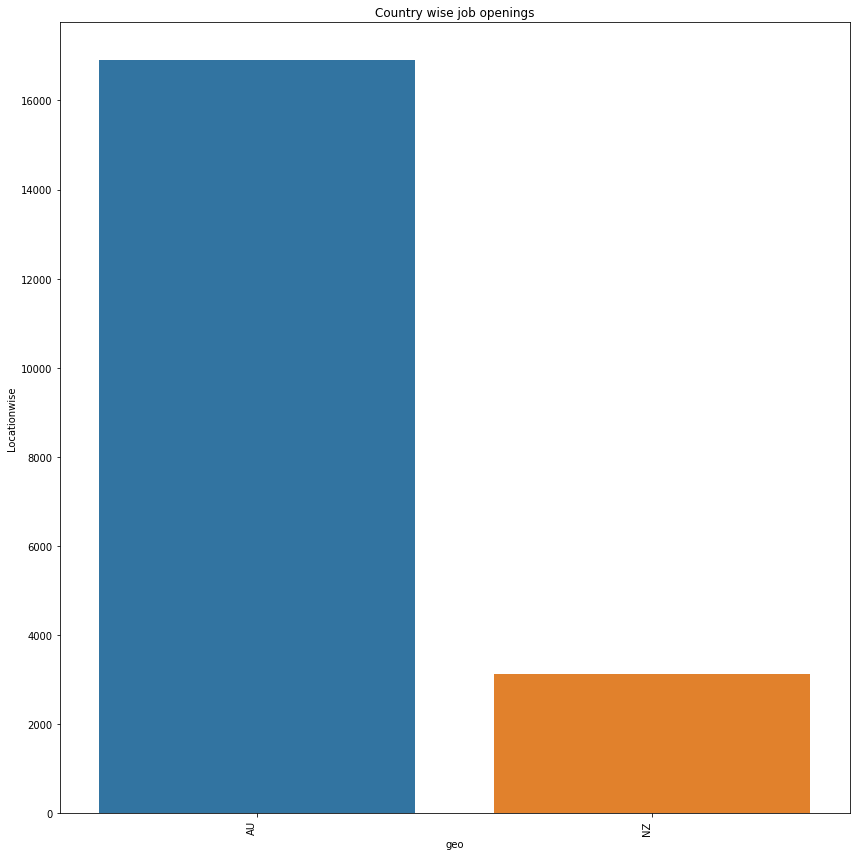

In [9]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="geo", y="Locationwise", data=country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

# **Pre-processing**

In [10]:
jobs_AU = df.loc[df['geo']=='AU']


In [11]:
jobs_AU[['city','state','geo']]

,city,state,geo
0,Perth,NaN,AU
1,Sydney,South West & M5 Corridor,AU
2,Sydney,Parramatta & Western Suburbs,AU
3,Bundaberg & Wide Bay Burnett,NaN,AU
4,Perth,NaN,AU
...,...,...,...
20024,Brisbane,CBD & Inner Suburbs,AU
20026,ACT,NaN,AU
20027,"Wollongong, Illawarra & South Coast",NaN,AU
20028,Northern QLD,NaN,AU


In [12]:
jobs_AU.groupby(['city','state','geo']).size().reset_index(name = 'Loactionwise')

,city,state,geo,Loactionwise
0,Brisbane,Bayside & Eastern Suburbs,AU,68
1,Brisbane,CBD & Inner Suburbs,AU,959
2,Brisbane,Northern Suburbs,AU,181
3,Brisbane,Southern Suburbs & Logan,AU,170
4,Brisbane,Western Suburbs & Ipswich,AU,107
5,Melbourne,Bayside & South Eastern Suburbs,AU,649
6,Melbourne,CBD & Inner Suburbs,AU,1781
7,Melbourne,Eastern Suburbs,AU,469
8,Melbourne,Northern Suburbs,AU,426
9,Melbourne,Western Suburbs,AU,355


In [13]:
city_wise_job_AU = jobs_AU.groupby(['city']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

In [14]:
city_wise_job_AU 

,city,Locationwise
59,Sydney,5288
40,Melbourne,4078
11,Brisbane,1802
48,Perth,1136
1,Adelaide,542
...,...,...
16,Central & South East,3
5,Albury Wodonga & Murray,3
24,Fleurieu Peninsula & Kangaroo Island,3
17,Central & South East TAS,2


In [15]:
city_wise_job_AU_th = city_wise_job_AU.loc[city_wise_job_AU['Locationwise'] >=100 ]

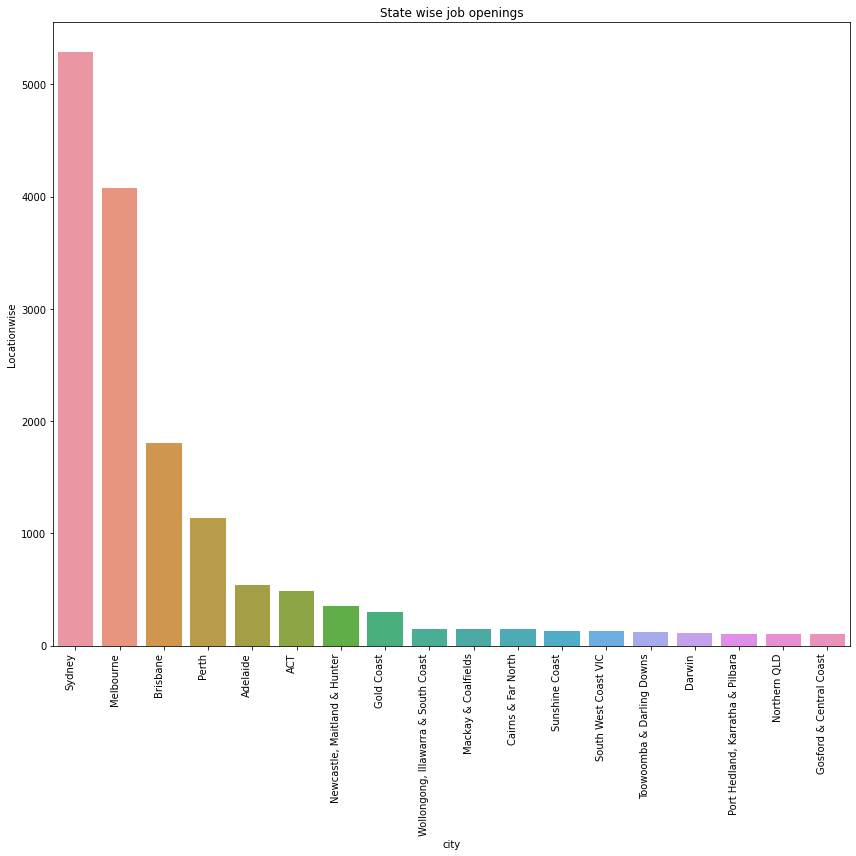

In [16]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="city", y="Locationwise",data=city_wise_job_AU_th)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

In [17]:
state_wise_job_AU = jobs_AU.groupby(['state']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

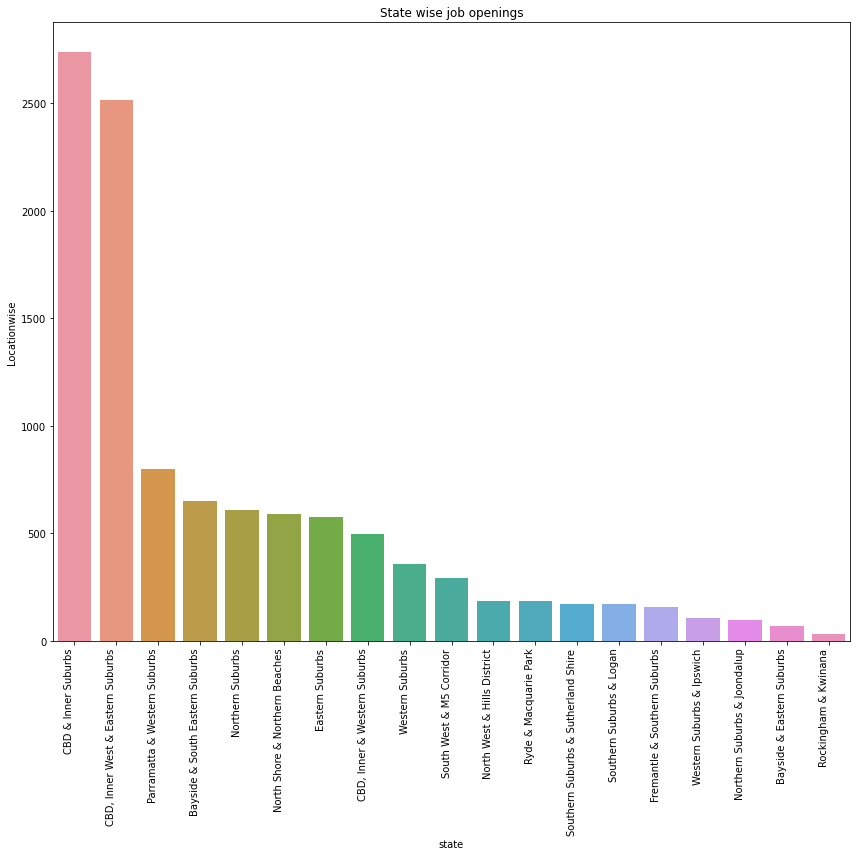

In [18]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="state", y="Locationwise",data=state_wise_job_AU)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

Find out Similar jobs

In [19]:
jobs_AU.columns

Index(['pageurl', 'crawl_timestamp', 'job_title', 'category', 'company_name',
       'city', 'post_date', 'job_description', 'job_type', 'job_board', 'geo',
       'state', 'salary_offered'],
      dtype='object')

In [20]:
jobs_AU.head().transpose()

,0,1,2,3,4
pageurl,https://www.seek.com.au/job/36028685,https://www.seek.com.au/job/36028693,https://www.seek.com.au/job/36027858,https://www.seek.com.au/job/36028687,https://www.seek.com.au/job/36026414
crawl_timestamp,2018-04-20 03:57:04 +0000,2018-04-20 03:52:46 +0000,2018-04-20 04:12:01 +0000,2018-04-20 03:51:23 +0000,2018-04-20 04:14:42 +0000
job_title,Package Lead - Pipeline Installation,Department Manager - Bakery - Campbelltown Region,Freight Handler,Warehouse Assistant,HR Truck Subcontractors
category,"Mining, Resources & Energy",Retail & Consumer Products,"Manufacturing, Transport & Logistics","Manufacturing, Transport & Logistics","Manufacturing, Transport & Logistics"
company_name,FIRCROFT AUSTRALIA PTY LTD,Coles,Zoom Recruitment & Training,Private Advertiser,Sands Fridge Lines
city,Perth,Sydney,Sydney,Bundaberg & Wide Bay Burnett,Perth
post_date,2018-04-19T05:41:52Z,2018-04-19T05:42:19Z,2018-04-19T04:51:51Z,2018-04-19T05:42:02Z,2018-04-19T03:22:40Z
job_description,The Role: General Execution Accountable for sa...,The role As a Coles Bakery Manager you will: w...,Our client is a leader within the Transport / ...,One of our Clients is looking for a Warehouse ...,Sands Fridge Lines WA is seeking Subcontractor...
job_type,Contract/Temp,Full Time,Casual/Vacation,Full Time,Contract/Temp
job_board,seek,seek,seek,seek,seek


In [21]:
print(jobs_AU.job_board.value_counts())

seek    16907
Name: job_board, dtype: int64


In [22]:
jobs_AU_base_line = jobs_AU.iloc[:,[2,3,4,5,7,8]]

In [23]:
jobs_AU_base_line.head().transpose()

,0,1,2,3,4
job_title,Package Lead - Pipeline Installation,Department Manager - Bakery - Campbelltown Region,Freight Handler,Warehouse Assistant,HR Truck Subcontractors
category,"Mining, Resources & Energy",Retail & Consumer Products,"Manufacturing, Transport & Logistics","Manufacturing, Transport & Logistics","Manufacturing, Transport & Logistics"
company_name,FIRCROFT AUSTRALIA PTY LTD,Coles,Zoom Recruitment & Training,Private Advertiser,Sands Fridge Lines
city,Perth,Sydney,Sydney,Bundaberg & Wide Bay Burnett,Perth
job_description,The Role: General Execution Accountable for sa...,The role As a Coles Bakery Manager you will: w...,Our client is a leader within the Transport / ...,One of our Clients is looking for a Warehouse ...,Sands Fridge Lines WA is seeking Subcontractor...
job_type,Contract/Temp,Full Time,Casual/Vacation,Full Time,Contract/Temp


In [24]:
jobs_AU_base_line['job_title'] = jobs_AU_base_line['job_title'].fillna('')
#jobs_AU_base_line['job_description'] = jobs_AU_base_line['job_description'].fillna('')

In [25]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [26]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [27]:
na_jd = dict(jobs_AU_base_line[jobs_AU_base_line['job_description'].isna()]['job_title'].apply(round1).apply(round2))
na_jd_index = list(na_jd.keys())
na_jd_values = list(na_jd.values())
nona_jd = dict(jobs_AU_base_line[jobs_AU_base_line['job_description'].notna()]['job_title'].apply(round1).apply(round2))
nona_jd_index = list(nona_jd.keys())
nona_jd_values = list(nona_jd.values())

In [28]:
#This takes an hour to run
#below cell has the pre-ran list and dictionary of no_similar and has_similar, you could use them directly
#no_similar = []
#has_similar = {}
#import difflib
#for ii in range(len(na_jd_values)):
   #jd = na_jd_values[ii]
   #similar_job = difflib.get_close_matches(jd, nona_jd_values,n = 1,cutoff = 0.5)
   #if similar_job != []:
     #similar_job = str.strip(str(similar_job),"[]'")
     #index_notna = (nona_jd_index[nona_jd_values.index(similar_job)])
     #{old index: substitute index}
     #has_similar[na_jt_index[ii]] = index_notna 
   #else:
     #no_similar.append(na_jt_index[ii])

In [29]:
no_similar = [19847, 19748, 19540, 19520, 19503, 19481, 19444, 19423, 19366, 19310, 19309, 19285, 19248, 19210, 19068, 19060, 19031, 19009, 18962, 18893, 18842, 18814, 18768, 18744, 18626, 18620, 18606, 17284, 17262, 17231, 17214, 17068, 17030, 17000, 16991, 16895, 16893, 16865, 16840, 16800, 16790, 16734, 16693, 16546, 16533, 16527, 16511, 16443, 16407, 16368, 16365, 16308, 16236, 16182, 16150, 16135, 16102, 16063, 16014, 15989, 15985, 15966, 15926, 15880, 15855, 15852, 15848, 15753, 15737, 15715, 15677, 15522, 15471, 15396, 15306, 15170, 15135, 14925, 14851, 14824, 14659, 14607, 14432, 14418, 14283, 14275, 14264, 14198, 14194, 14051, 13948, 13825, 13772, 13756, 13737, 13526, 13460, 13307, 13133, 13121, 13111, 13062, 13024, 12943, 12937, 12911, 12906, 12847, 12609, 12574, 12557, 12477, 12465, 12459, 12399, 12320, 12137, 12058, 11896, 11788, 11618, 11503, 11466, 11465, 11449, 11431, 11336, 11224, 11085, 11029, 10992, 10978, 10974, 10875, 10702, 10595, 10474, 10471, 10451, 10448, 10182, 10151, 10108, 10083, 9926, 9784, 9683, 9606, 9572, 9571, 9557, 9365, 9281, 9156, 9152, 9135, 9026, 8956, 8588, 8572, 8501, 8494, 8453, 8402, 8168, 8164, 8045, 8030, 7968, 7609, 7247, 7143, 6940, 6916, 6868, 6857, 6713, 6670, 6651, 6648, 6580, 6368, 6367, 6298, 6240, 6236, 6027, 5952, 5903, 5223, 5195, 5165, 5110, 5080, 5062, 5027, 4982, 4926, 4925, 4893, 4892, 4848, 4736, 4585, 4554, 4537, 4437, 4411, 2173, 2172, 2167, 2107, 2085, 2078, 2072, 2021, 1927, 1926, 1902, 1892, 1776, 1775, 1736]
has_similar = {81: 3778, 180: 2447, 442: 17928, 463: 832, 490: 3962, 538: 1511, 656: 2974, 683: 173, 737: 593, 742: 3115, 1140: 2681, 1187: 1566, 1267: 544, 1351: 456, 1443: 109, 1708: 3085, 1711: 2698, 1720: 1593, 1721: 3238, 1722: 3656, 1723: 2262, 1724: 594, 1725: 4050, 1726: 2543, 1727: 2470, 1728: 1627, 1729: 2491, 1730: 169, 1731: 553, 1733: 2261, 1734: 2207, 1735: 4068, 1737: 1097, 1738: 1634, 1739: 493, 1740: 1137, 1741: 1253, 1742: 913, 1743: 1562, 1744: 3610, 1745: 2754, 1746: 136, 1747: 25, 1748: 1159, 1749: 3565, 1751: 2203, 1752: 915, 1753: 3413, 1754: 3371, 1756: 325, 1758: 3700, 1759: 2285, 1760: 3839, 1761: 17924, 1763: 3749, 1764: 3118, 1765: 353, 1766: 566, 1767: 17817, 1768: 2983, 1769: 2909, 1770: 3059, 1771: 25, 1772: 53, 1773: 121, 1774: 2804, 1777: 1160, 1778: 4166, 1779: 1625, 1780: 2952, 1781: 2919, 1782: 2931, 1783: 3239, 1784: 3342, 1785: 17787, 1786: 618, 1787: 531, 1789: 708, 1790: 511, 1792: 4374, 1793: 3466, 1794: 20, 1795: 4127, 1796: 3659, 1797: 1457, 1798: 4290, 1799: 2285, 1800: 947, 1801: 1159, 1802: 832, 1803: 3336, 1804: 4374, 1805: 1081, 1807: 609, 1808: 25, 1810: 1137, 1812: 1307, 1813: 4017, 1815: 2941, 1817: 17599, 1818: 2357, 1819: 3180, 1820: 1031, 1821: 17861, 1822: 1562, 1823: 2727, 1824: 503, 1825: 1664, 1826: 3193, 1827: 3059, 1828: 17871, 1830: 169, 1831: 3245, 1832: 1390, 1833: 17916, 1834: 457, 1835: 3254, 1837: 3115, 1838: 3907, 1839: 807, 1840: 2682, 1841: 923, 1842: 17733, 1843: 1041, 1844: 4322, 1845: 2663, 1846: 797, 1847: 3663, 1848: 2426, 1850: 17699, 1851: 3749, 1852: 3821, 1853: 2242, 1854: 2238, 1855: 1253, 1856: 4210, 1857: 2583, 1858: 954, 1859: 17790, 1861: 1347, 1862: 916, 1863: 4290, 1864: 1169, 1865: 2594, 1866: 2580, 1867: 21, 1868: 17698, 1870: 2201, 1871: 229, 1872: 37, 1873: 609, 1874: 17739, 1875: 2790, 1876: 2878, 1877: 3, 1878: 1679, 1879: 1281, 1880: 25, 1881: 16, 1882: 215, 1883: 527, 1884: 214, 1887: 2691, 1888: 1592, 1889: 17787, 1890: 3244, 1893: 884, 1894: 1622, 1895: 154, 1896: 1196, 1897: 2703, 1898: 2941, 1900: 3920, 1901: 967, 1903: 2649, 1904: 745, 1905: 3218, 1906: 3659, 1907: 3415, 1908: 377, 1909: 3057, 1910: 2897, 1911: 3059, 1912: 1523, 1913: 3888, 1916: 496, 1917: 3001, 1918: 2664, 1919: 2849, 1920: 627, 1921: 3029, 1924: 1342, 1925: 1379, 1929: 4056, 1930: 169, 1931: 3087, 1932: 456, 1933: 2912, 1934: 873, 1935: 2757, 1938: 3927, 1940: 1076, 1941: 2478, 1942: 1332, 1943: 4041, 1944: 3, 1946: 428, 1947: 674, 1948: 915, 1949: 471, 1950: 2265, 1951: 17843, 1952: 3005, 1954: 1192, 1955: 3103, 1956: 4290, 1957: 704, 1958: 240, 1960: 2470, 1961: 2872, 1963: 3818, 1964: 2389, 1965: 3830, 1966: 3062, 1967: 626, 1968: 17902, 1969: 1319, 1970: 3766, 1971: 1053, 1972: 1264, 1973: 17890, 1974: 3678, 1976: 1490, 1977: 1378, 1978: 2946, 1979: 1202, 1980: 496, 1981: 3396, 1982: 3059, 1983: 566, 1984: 87, 1986: 3223, 1989: 761, 1990: 3948, 1992: 3492, 1993: 4061, 1994: 3446, 1996: 3418, 1997: 1347, 1998: 341, 1999: 406, 2000: 2458, 2002: 2939, 2003: 3620, 2005: 325, 2006: 1461, 2007: 1651, 2008: 4127, 2009: 1390, 2010: 576, 2011: 4324, 2012: 2736, 2013: 503, 2014: 4266, 2015: 3268, 2018: 454, 2019: 581, 2020: 1137, 2022: 3909, 2023: 2282, 2024: 1701, 2025: 4127, 2026: 2285, 2027: 2430, 2028: 3087, 2029: 1193, 2030: 3842, 2031: 3659, 2032: 1192, 2033: 2856, 2034: 3939, 2036: 393, 2037: 844, 2038: 3862, 2039: 2459, 2040: 3065, 2041: 563, 2042: 347, 2044: 2241, 2045: 2738, 2047: 109, 2049: 523, 2050: 3013, 2051: 3943, 2052: 2909, 2053: 220, 2054: 3892, 2056: 360, 2057: 493, 2058: 2474, 2059: 2649, 2060: 1713, 2061: 3254, 2062: 2513, 2063: 2949, 2064: 385, 2065: 213, 2066: 3182, 2068: 5197, 2069: 4226, 2071: 2846, 2073: 2816, 2074: 1497, 2075: 923, 2076: 415, 2077: 1160, 2079: 992, 2080: 4127, 2082: 736, 2083: 3010, 2084: 53, 2086: 3155, 2087: 380, 2090: 25, 2091: 3542, 2093: 4304, 2094: 1137, 2096: 2201, 2097: 2264, 2098: 3485, 2099: 3187, 2101: 4329, 2102: 2698, 2103: 3771, 2104: 1271, 2105: 503, 2106: 1538, 2108: 2807, 2109: 2259, 2111: 1627, 2112: 1193, 2113: 777, 2114: 492, 2115: 5197, 2116: 17676, 2118: 1253, 2119: 974, 2121: 3821, 2122: 411, 2123: 310, 2125: 154, 2126: 29, 2128: 1159, 2129: 382, 2130: 1460, 2131: 2727, 2135: 995, 2137: 1718, 2138: 134, 2139: 562, 2140: 2201, 2142: 2493, 2143: 3032, 2144: 17792, 2145: 503, 2146: 3893, 2149: 4066, 2150: 3175, 2151: 1137, 2152: 730, 2153: 2192, 2154: 670, 2157: 4167, 2158: 18140, 2160: 3404, 2161: 1490, 2162: 1701, 2163: 3568, 2164: 1406, 2165: 2234, 2166: 1114, 2168: 3315, 2170: 4267, 2171: 126, 2175: 3351, 2176: 3661, 2177: 594, 2178: 599, 2179: 2265, 2180: 3585, 2181: 852, 2182: 3848, 2183: 3622, 2184: 2939, 2186: 1009, 2187: 354, 2188: 296, 2333: 364, 2364: 3604, 2373: 898, 2561: 2524, 2730: 4360, 2874: 17872, 2921: 3018, 3208: 402, 3222: 3223, 3525: 17872, 3575: 2738, 3592: 2604, 3653: 109, 3690: 503, 3795: 2916, 3805: 20, 3885: 17872, 3915: 17836, 3922: 17922, 4223: 3438, 4231: 17927, 4272: 1152, 4293: 1327, 4390: 2234, 4391: 2531, 4392: 2495, 4393: 998, 4394: 677, 4395: 3593, 4396: 17720, 4397: 1339, 4398: 670, 4399: 1332, 4400: 1550, 4402: 2678, 4403: 4178, 4405: 4110, 4406: 3586, 4408: 3615, 4409: 3404, 4410: 3148, 4412: 2537, 4413: 1062, 4415: 478, 4416: 2607, 4417: 1701, 4418: 17890, 4419: 3866, 4421: 3443, 4422: 4116, 4423: 2593, 4424: 17724, 4425: 3104, 4426: 1613, 4427: 779, 4428: 315, 4429: 3641, 4430: 725, 4433: 2533, 4434: 25, 4435: 2467, 4436: 1224, 4438: 2848, 4439: 86, 4440: 3888, 4441: 3731, 4442: 2462, 4444: 2941, 4445: 1347, 4446: 2726, 4447: 342, 4448: 3879, 4449: 118, 4450: 949, 4451: 2580, 4453: 288, 4454: 2715, 4456: 2278, 4459: 3998, 4460: 2392, 4461: 2266, 4462: 2703, 4465: 325, 4466: 2486, 4467: 3349, 4468: 3625, 4469: 924, 4470: 130, 4471: 4021, 4472: 2565, 4473: 2880, 4474: 777, 4476: 2234, 4477: 1066, 4478: 670, 4480: 17783, 4481: 2758, 4482: 2698, 4483: 17827, 4484: 978, 4485: 3312, 4486: 4351, 4487: 3433, 4488: 2203, 4489: 2278, 4491: 890, 4492: 632, 4494: 1598, 4495: 3, 4496: 421, 4497: 1196, 4498: 2537, 4499: 406, 4500: 3628, 4501: 3948, 4503: 638, 4504: 1183, 4505: 290, 4506: 916, 4507: 3173, 4508: 2349, 4510: 2581, 4511: 17762, 4512: 133, 4513: 1258, 4514: 1664, 4515: 4168, 4516: 17667, 4517: 82, 4518: 3045, 4519: 1301, 4520: 113, 4521: 1264, 4522: 2672, 4523: 1701, 4524: 354, 4527: 113, 4529: 3440, 4530: 17667, 4531: 1045, 4533: 857, 4534: 4221, 4535: 2739, 4536: 2763, 4538: 5199, 4539: 765, 4540: 614, 4541: 3605, 4543: 4384, 4544: 1122, 4545: 1332, 4550: 3344, 4552: 2790, 4553: 3407, 4555: 688, 4557: 3109, 4558: 99, 4559: 2765, 4560: 17840, 4561: 2218, 4562: 3652, 4563: 17899, 4564: 2713, 4565: 48, 4566: 3991, 4567: 3836, 4568: 1558, 4569: 2431, 4570: 5199, 4571: 3383, 4572: 354, 4573: 17783, 4575: 45, 4577: 17830, 4579: 3115, 4580: 2964, 4581: 3362, 4582: 1151, 4583: 17916, 4586: 3064, 4587: 1490, 4589: 206, 4590: 2570, 4591: 2999, 4592: 2594, 4593: 3812, 4594: 136, 4595: 1701, 4597: 1253, 4598: 3327, 4600: 760, 4601: 486, 4602: 2193, 4603: 3369, 4604: 1527, 4605: 443, 4606: 3913, 4607: 2977, 4608: 2758, 4609: 179, 4610: 1097, 4611: 2713, 4613: 3217, 4614: 4040, 4615: 3374, 4616: 3254, 4617: 2649, 4618: 17638, 4619: 25, 4620: 276, 4622: 540, 4623: 915, 4624: 17651, 4625: 2218, 4626: 4204, 4627: 47, 4628: 147, 4630: 893, 4631: 3447, 4633: 3503, 4634: 4304, 4635: 17783, 4636: 2458, 4637: 2608, 4638: 138, 4640: 3751, 4641: 2894, 4643: 842, 4646: 3672, 4647: 38, 4648: 506, 4649: 3486, 4650: 3352, 4651: 2519, 4652: 614, 4653: 260, 4654: 3368, 4655: 2999, 4656: 3238, 4658: 3212, 4659: 680, 4660: 3287, 4662: 622, 4663: 363, 4664: 2192, 4665: 17590, 4666: 330, 4667: 3098, 4668: 3962, 4669: 4020, 4671: 107, 4672: 4089, 4673: 55, 4674: 367, 4675: 25, 4676: 1481, 4677: 2919, 4678: 17725, 4680: 777, 4682: 3384, 4683: 3617, 4684: 499, 4685: 866, 4686: 3148, 4687: 3807, 4688: 3599, 4689: 2875, 4690: 467, 4691: 3842, 4692: 1002, 4693: 3362, 4695: 3286, 4696: 17622, 4697: 1622, 4699: 579, 4700: 2389, 4701: 4146, 4702: 719, 4703: 1301, 4704: 2649, 4705: 3059, 4707: 2984, 4708: 749, 4709: 3254, 4710: 996, 4711: 4013, 4712: 1202, 4713: 421, 4714: 3682, 4715: 3749, 4716: 3103, 4717: 3457, 4718: 400, 4719: 3812, 4721: 447, 4722: 309, 4725: 2941, 4726: 518, 4727: 1030, 4728: 2221, 4729: 3443, 4730: 38, 4731: 3721, 4732: 3706, 4734: 3342, 4735: 2791, 4737: 938, 4738: 2682, 4739: 1607, 4740: 109, 4741: 2754, 4742: 3212, 4744: 492, 4745: 17590, 4746: 1521, 4748: 17762, 4750: 1569, 4751: 17916, 4753: 17616, 4754: 4035, 4755: 2766, 4756: 2402, 4757: 17924, 4760: 3812, 4762: 2919, 4764: 1233, 4765: 2698, 4766: 3467, 4768: 3442, 4770: 2316, 4771: 1301, 4772: 17930, 4774: 3826, 4775: 776, 4776: 232, 4777: 622, 4778: 320, 4779: 65, 4780: 3292, 4781: 1211, 4782: 1604, 4783: 3917, 4784: 3613, 4785: 1393, 4786: 2401, 4787: 2192, 4788: 2361, 4789: 912, 4790: 1592, 4791: 793, 4792: 2326, 4793: 3144, 4795: 2746, 4796: 4290, 4797: 1458, 4798: 1152, 4799: 581, 4800: 622, 4801: 2509, 4802: 832, 4803: 785, 4804: 2941, 4805: 736, 4806: 3642, 4808: 412, 4809: 625, 4810: 3117, 4811: 179, 4813: 1718, 4814: 1406, 4815: 2999, 4816: 2753, 4817: 1538, 4818: 2611, 4819: 4127, 4821: 2923, 4823: 1193, 4824: 2240, 4825: 17943, 4826: 1658, 4827: 1183, 4828: 525, 4829: 969, 4830: 3230, 4831: 2604, 4832: 17844, 4834: 2251, 4835: 57, 4836: 2224, 4837: 2810, 4839: 563, 4840: 3486, 4841: 623, 4842: 2740, 4843: 3680, 4844: 1709, 4845: 1347, 4846: 2565, 4847: 3450, 4850: 1619, 4851: 2447, 4853: 3706, 4854: 2404, 4856: 1211, 4857: 17783, 4858: 925, 4859: 2682, 4860: 17599, 4861: 712, 4862: 4105, 4863: 1319, 4865: 55, 4866: 2257, 4868: 2766, 4869: 185, 4871: 17919, 4872: 3187, 4876: 310, 4877: 3958, 4878: 1115, 4880: 3600, 4881: 17765, 4882: 1655, 4883: 3443, 4884: 17658, 4885: 3455, 4886: 2782, 4887: 3984, 4888: 78, 4889: 90, 4890: 705, 4891: 4290, 4895: 341, 4897: 2651, 4898: 2384, 4900: 1073, 4901: 1642, 4902: 807, 4904: 17916, 4905: 325, 4907: 498, 4908: 1215, 4909: 3180, 4910: 1011, 4911: 3503, 4912: 4374, 4913: 25, 4914: 2483, 4916: 3629, 4917: 3958, 4919: 135, 4922: 2810, 4924: 29, 4927: 2739, 4928: 17943, 4929: 325, 4930: 670, 4931: 17747, 4933: 360, 4934: 262, 4935: 17661, 4936: 1668, 4938: 3173, 4939: 2580, 4940: 3950, 4941: 1406, 4942: 4046, 4945: 915, 4946: 680, 4947: 268, 4949: 1009, 4951: 2706, 4953: 17827, 4954: 1527, 4955: 17942, 4956: 2533, 4957: 1631, 4958: 2534, 4959: 1247, 4960: 1672, 4961: 4281, 4963: 1233, 4964: 3683, 4965: 1303, 4966: 915, 4968: 17844, 4969: 1253, 4970: 1073, 4971: 4108, 4973: 1487, 4974: 973, 4975: 2537, 4976: 2740, 4978: 17643, 4979: 3103, 4981: 3927, 4983: 472, 4984: 1301, 4985: 3416, 4986: 2941, 4987: 1481, 4988: 2690, 4990: 4057, 4991: 2710, 4992: 685, 4993: 583, 4994: 17623, 4995: 568, 4996: 21, 4998: 670, 4999: 3271, 5000: 4068, 5001: 3703, 5002: 1694, 5003: 3959, 5004: 4140, 5005: 3733, 5006: 1411, 5008: 2696, 5009: 2447, 5010: 3443, 5011: 4284, 5012: 662, 5013: 3652, 5015: 253, 5016: 47, 5017: 183, 5018: 412, 5019: 428, 5020: 3078, 5021: 2261, 5023: 3319, 5024: 653, 5025: 464, 5026: 2272, 5028: 3646, 5029: 2707, 5030: 2810, 5032: 866, 5033: 2200, 5035: 4086, 5036: 475, 5037: 1264, 5040: 325, 5042: 248, 5044: 599, 5045: 2720, 5046: 17822, 5047: 3568, 5048: 1083, 5049: 17790, 5050: 3227, 5052: 3542, 5053: 3381, 5054: 2657, 5055: 1347, 5057: 185, 5058: 3771, 5059: 3413, 5060: 1131, 5061: 1700, 5063: 2567, 5064: 400, 5065: 3997, 5066: 3423, 5067: 609, 5068: 503, 5069: 2270, 5070: 423, 5071: 852, 5072: 2264, 5073: 2739, 5074: 2503, 5075: 1347, 5076: 3152, 5077: 1031, 5078: 2766, 5079: 3433, 5082: 3473, 5083: 2649, 5084: 3145, 5086: 3293, 5088: 640, 5089: 3134, 5091: 3404, 5092: 67, 5093: 2593, 5094: 2441, 5096: 2682, 5097: 3703, 5098: 3641, 5099: 179, 5100: 708, 5101: 1532, 5102: 3035, 5104: 17783, 5105: 17702, 5106: 260, 5107: 17759, 5109: 4056, 5111: 3486, 5112: 75, 5115: 481, 5117: 4374, 5118: 2611, 5119: 628, 5120: 159, 5121: 4040, 5122: 209, 5123: 2819, 5124: 1701, 5126: 235, 5127: 354, 5128: 2950, 5129: 261, 5131: 2791, 5132: 3917, 5133: 4138, 5135: 1664, 5136: 335, 5137: 604, 5138: 2819, 5139: 2635, 5141: 3649, 5142: 3383, 5143: 4121, 5144: 17782, 5145: 2950, 5146: 341, 5147: 3206, 5148: 4035, 5151: 3652, 5153: 25, 5154: 3680, 5155: 3373, 5156: 1133, 5157: 928, 5158: 4131, 5159: 636, 5163: 4139, 5164: 3087, 5166: 3547, 5167: 3659, 5168: 2911, 5170: 3927, 5171: 239, 5172: 364, 5173: 17838, 5174: 290, 5175: 949, 5176: 1583, 5178: 3397, 5179: 1253, 5180: 2522, 5181: 3974, 5182: 359, 5184: 17721, 5185: 333, 5186: 2580, 5187: 705, 5188: 949, 5189: 973, 5190: 3259, 5191: 1562, 5192: 2470, 5193: 4384, 5194: 2726, 5203: 273, 5204: 2729, 5205: 17843, 5206: 1068, 5207: 1230, 5208: 3554, 5209: 114, 5210: 393, 5211: 2214, 5212: 1406, 5213: 472, 5214: 113, 5215: 2580, 5216: 3013, 5217: 3373, 5218: 3001, 5219: 3449, 5220: 1233, 5221: 2963, 5222: 1186, 5224: 1186, 5225: 17942, 5226: 1593, 5227: 437, 5228: 2200, 5229: 3816, 5230: 3101, 5231: 503, 5232: 1474, 5233: 4013, 5234: 2847, 5235: 2618, 5236: 1466, 5237: 1627, 5238: 853, 5239: 99, 5240: 1472, 5241: 2740, 5242: 1562, 5243: 2663, 5244: 3254, 5245: 3417, 5246: 84, 5247: 41, 5248: 1619, 5249: 2190, 5250: 3026, 5251: 17860, 5252: 17714, 5253: 408, 5254: 692, 5255: 1192, 5256: 774, 5257: 797, 5258: 231, 5259: 2204, 5260: 109, 5261: 2522, 5262: 3694, 5263: 3535, 5264: 3804, 5265: 1717, 5266: 9, 5267: 3029, 5268: 1153, 5269: 2930, 5270: 17644, 5271: 3703, 5272: 423, 5273: 1128, 5274: 341, 5275: 293, 5276: 17929, 5277: 2931, 5278: 870, 5279: 335, 5280: 843, 5281: 240, 5282: 4265, 5283: 393, 5288: 113, 5292: 995, 5294: 1567, 5298: 1057, 5304: 301, 5305: 152, 5314: 3265, 5315: 2680, 5321: 40, 5324: 3731, 5328: 3751, 5339: 20, 5353: 1236, 5360: 1627, 5368: 311, 5370: 90, 5371: 3490, 5374: 3244, 5378: 215, 5388: 3669, 5393: 3649, 5399: 231, 5401: 163, 5404: 121, 5420: 1008, 5434: 3149, 5437: 503, 5438: 3535, 5446: 1226, 5454: 1404, 5457: 2395, 5467: 3018, 5471: 523, 5472: 4019, 5473: 1521, 5482: 828, 5484: 2906, 5485: 793, 5486: 2702, 5488: 4172, 5495: 3449, 5514: 2458, 5516: 1476, 5519: 3402, 5534: 3283, 5537: 2755, 5538: 3953, 5540: 2359, 5552: 1197, 5553: 1569, 5557: 1623, 5561: 1511, 5562: 725, 5576: 2394, 5579: 1303, 5587: 501, 5590: 3267, 5592: 133, 5601: 2559, 5602: 3425, 5609: 248, 5619: 1679, 5621: 126, 5627: 848, 5630: 17721, 5631: 563, 5632: 2210, 5636: 3292, 5642: 1634, 5644: 17739, 5645: 1658, 5655: 41, 5657: 1139, 5668: 1381, 5671: 1088, 5674: 354, 5677: 662, 5678: 1679, 5686: 2797, 5688: 3078, 5689: 732, 5694: 3013, 5695: 4045, 5696: 315, 5701: 17573, 5710: 2210, 5727: 2877, 5729: 297, 5732: 137, 5733: 3679, 5735: 3246, 5738: 2551, 5742: 2986, 5743: 3946, 5754: 670, 5755: 2285, 5757: 3287, 5765: 3102, 5768: 716, 5776: 818, 5782: 3349, 5794: 140, 5795: 2635, 5800: 566, 5805: 729, 5808: 3665, 5811: 3187, 5818: 2552, 5819: 45, 5820: 17854, 5822: 2933, 5827: 2295, 5829: 3669, 5833: 137, 5834: 92, 5835: 3455, 5843: 579, 5845: 17835, 5847: 4068, 5859: 17603, 5864: 1019, 5872: 1041, 5884: 526, 5887: 3512, 5889: 4082, 5895: 1506, 5899: 1553, 5904: 1466, 5905: 983, 5907: 228, 5912: 4176, 5913: 1242, 5925: 4076, 5928: 2559, 5929: 380, 5933: 3638, 5934: 3669, 5948: 136, 5951: 4034, 5953: 29, 5960: 833, 5962: 3526, 5970: 3718, 5971: 1262, 5972: 3839, 5973: 123, 5974: 1558, 5975: 2861, 5976: 2916, 5977: 3884, 5978: 2385, 5979: 3283, 5980: 2302, 5981: 2994, 5982: 622, 5983: 1045, 5984: 335, 5985: 3825, 5986: 1114, 5987: 1280, 5988: 25, 5989: 3402, 5990: 17736, 5991: 314, 5992: 2343, 5993: 3151, 5994: 17839, 5995: 297, 5996: 702, 5997: 2196, 5998: 1619, 5999: 638, 6000: 1001, 6001: 4191, 6002: 4338, 6003: 2403, 6004: 1417, 6005: 53, 6006: 2369, 6007: 3051, 6008: 17838, 6009: 4265, 6010: 2262, 6011: 2903, 6012: 3680, 6013: 3169, 6014: 667, 6015: 2511, 6016: 3948, 6017: 832, 6018: 1352, 6019: 821, 6020: 3547, 6021: 2813, 6022: 1424, 6023: 3248, 6024: 631, 6025: 2691, 6026: 17682, 6028: 472, 6029: 4107, 6030: 1137, 6031: 2906, 6032: 4035, 6033: 944, 6034: 3197, 6035: 20, 6036: 29, 6037: 2772, 6038: 182, 6039: 615, 6040: 503, 6041: 1148, 6042: 92, 6043: 2931, 6044: 4295, 6045: 3511, 6046: 3404, 6047: 17858, 6048: 17831, 6049: 461, 6050: 105, 6051: 3504, 6052: 75, 6053: 478, 6054: 297, 6055: 2221, 6056: 1172, 6057: 467, 6058: 531, 6059: 4266, 6060: 3466, 6061: 288, 6062: 915, 6063: 461, 6064: 1461, 6065: 1280, 6066: 3417, 6067: 3151, 6068: 3074, 6069: 69, 6070: 1669, 6071: 1560, 6072: 1496, 6073: 1066, 6074: 4228, 6075: 256, 6076: 113, 6077: 123, 6078: 29, 6079: 20, 6080: 3529, 6081: 3769, 6082: 3943, 6083: 3517, 6084: 3991, 6085: 3450, 6086: 377, 6087: 257, 6088: 3032, 6089: 566, 6090: 20, 6091: 503, 6092: 129, 6093: 2201, 6094: 3254, 6095: 17859, 6096: 456, 6097: 3404, 6098: 1658, 6099: 777, 6100: 2498, 6101: 892, 6102: 2853, 6103: 17843, 6104: 17650, 6105: 2278, 6106: 620, 6107: 1464, 6108: 17805, 6109: 17599, 6110: 3542, 6111: 2593, 6112: 777, 6113: 2193, 6114: 2676, 6115: 1303, 6116: 3669, 6117: 3107, 6118: 686, 6119: 353, 6120: 17739, 6121: 2702, 6122: 670, 6123: 2270, 6124: 3420, 6125: 3249, 6126: 503, 6127: 2867, 6128: 222, 6129: 1610, 6130: 183, 6131: 36, 6132: 969, 6133: 17631, 6134: 2663, 6135: 11, 6136: 17755, 6137: 17740, 6138: 17919, 6139: 399, 6140: 2258, 6141: 1263, 6142: 4034, 6143: 1644, 6144: 327, 6145: 3549, 6146: 17933, 6147: 622, 6148: 2948, 6149: 142, 6150: 2740, 6151: 2960, 6152: 3227, 6153: 4226, 6154: 3236, 6155: 1164, 6156: 3622, 6157: 1466, 6158: 3628, 6159: 263, 6160: 17760, 6161: 2524, 6162: 3661, 6163: 347, 6164: 17946, 6165: 4086, 6166: 2483, 6167: 4044, 6168: 17586, 6169: 2284, 6170: 685, 6171: 3344, 6172: 2260, 6173: 1665, 6174: 346, 6175: 17858, 6176: 7, 6177: 17765, 6178: 260, 6179: 2828, 6180: 36, 6181: 4077, 6182: 1368, 6183: 3315, 6184: 17739, 6185: 3006, 6186: 1417, 6187: 3536, 6188: 267, 6189: 615, 6190: 3905, 6191: 913, 6192: 260, 6193: 3731, 6194: 1468, 6195: 3301, 6196: 17933, 6197: 1565, 6198: 2197, 6199: 17643, 6200: 892, 6201: 3975, 6202: 1065, 6203: 2654, 6204: 1397, 6205: 1159, 6206: 3056, 6207: 3862, 6208: 4247, 6209: 946, 6210: 290, 6211: 301, 6212: 3554, 6213: 1592, 6214: 2999, 6215: 2699, 6216: 3431, 6217: 1466, 6218: 2797, 6219: 144, 6220: 3759, 6221: 441, 6222: 3654, 6223: 4097, 6224: 574, 6225: 2267, 6226: 338, 6227: 3503, 6228: 3655, 6229: 2639, 6230: 1141, 6231: 2741, 6232: 3752, 6233: 17882, 6234: 3502, 6235: 1137, 6237: 456, 6238: 2264, 6239: 3189, 6241: 194, 6242: 602, 6243: 17676, 6244: 3517, 6245: 25, 6246: 2608, 6247: 2769, 6248: 1293, 6249: 17783, 6250: 377, 6251: 40, 6252: 215, 6253: 3703, 6254: 3240, 6255: 3091, 6256: 779, 6257: 2215, 6258: 2509, 6259: 3736, 6260: 17839, 6261: 2853, 6262: 17616, 6263: 2882, 6264: 1186, 6265: 136, 6266: 421, 6267: 260, 6268: 200, 6269: 354, 6270: 1604, 6271: 175, 6272: 2734, 6273: 3705, 6274: 2791, 6275: 2618, 6276: 916, 6277: 987, 6278: 892, 6279: 1558, 6280: 1603, 6281: 1271, 6282: 3078, 6283: 3374, 6284: 206, 6285: 171, 6286: 477, 6287: 2931, 6288: 375, 6289: 1097, 6290: 640, 6291: 707, 6292: 3182, 6293: 2941, 6294: 2380, 6295: 2649, 6296: 3767, 6297: 808, 6299: 106, 6300: 449, 6301: 1381, 6302: 3848, 6303: 518, 6304: 17787, 6305: 74, 6306: 2676, 6307: 1243, 6308: 409, 6309: 3669, 6310: 2877, 6311: 4304, 6312: 2265, 6313: 17635, 6314: 4332, 6315: 17805, 6316: 3055, 6317: 4134, 6318: 1294, 6319: 157, 6320: 2265, 6321: 4328, 6322: 2201, 6323: 1164, 6324: 1303, 6325: 2585, 6326: 17752, 6327: 2853, 6328: 2411, 6329: 4121, 6330: 488, 6331: 29, 6332: 728, 6333: 17707, 6334: 135, 6335: 437, 6336: 3545, 6337: 183, 6338: 2911, 6339: 2211, 6340: 4290, 6341: 3389, 6342: 4086, 6343: 2890, 6344: 3157, 6345: 640, 6346: 2916, 6347: 1124, 6348: 2605, 6349: 4332, 6350: 3413, 6351: 3672, 6352: 2431, 6353: 456, 6354: 5199, 6355: 1602, 6356: 1498, 6357: 4173, 6358: 1630, 6359: 1262, 6360: 206, 6361: 3046, 6362: 2791, 6363: 580, 6364: 2862, 6365: 4015, 6366: 3535, 6369: 480, 6370: 797, 6371: 1336, 6372: 2294, 6373: 255, 6374: 4383, 6375: 121, 6376: 4003, 6377: 2210, 6378: 4214, 6379: 2565, 6380: 1574, 6381: 17817, 6382: 851, 6383: 311, 6384: 503, 6385: 458, 6386: 1045, 6387: 1614, 6388: 3687, 6389: 2576, 6390: 1262, 6391: 3622, 6392: 622, 6393: 17804, 6394: 4254, 6395: 306, 6396: 297, 6397: 622, 6398: 17895, 6399: 428, 6400: 3868, 6401: 1527, 6402: 3918, 6403: 4017, 6404: 17681, 6405: 2860, 6406: 890, 6407: 3423, 6408: 1404, 6409: 17836, 6410: 17924, 6411: 1159, 6412: 4203, 6413: 1489, 6414: 621, 6415: 654, 6416: 3078, 6417: 1424, 6418: 118, 6419: 2599, 6420: 1183, 6421: 2699, 6422: 1657, 6423: 454, 6424: 4164, 6425: 1008, 6426: 2914, 6427: 397, 6428: 3657, 6429: 3173, 6430: 3792, 6431: 415, 6432: 923, 6433: 3659, 6434: 2676, 6435: 192, 6436: 3604, 6437: 2740, 6438: 915, 6439: 740, 6440: 456, 6441: 284, 6442: 3275, 6443: 29, 6444: 3613, 6445: 2455, 6446: 235, 6447: 2797, 6448: 186, 6449: 3680, 6450: 59, 6451: 1658, 6452: 1669, 6453: 2352, 6454: 2797, 6455: 17695, 6456: 1268, 6457: 1066, 6458: 811, 6459: 848, 6460: 2570, 6461: 3142, 6462: 3641, 6463: 2505, 6464: 833, 6465: 817, 6466: 1137, 6467: 4363, 6468: 17897, 6469: 318, 6470: 1585, 6471: 1191, 6472: 17824, 6473: 2274, 6474: 17918, 6475: 109, 6476: 17859, 6477: 2705, 6478: 851, 6479: 2618, 6480: 574, 6481: 20, 6482: 284, 6483: 86, 6484: 2614, 6485: 17787, 6486: 744, 6487: 1624, 6488: 1262, 6489: 2696, 6490: 576, 6491: 17821, 6492: 1716, 6493: 3385, 6494: 1660, 6495: 3943, 6496: 2766, 6497: 3193, 6498: 2565, 6499: 1544, 6500: 2652, 6501: 4167, 6502: 4015, 6503: 920, 6504: 472, 6505: 3360, 6506: 267, 6507: 1371, 6508: 134, 6509: 17783, 6510: 1687, 6511: 728, 6512: 17831, 6513: 4041, 6514: 4167, 6515: 3127, 6516: 654, 6517: 3519, 6518: 1632, 6519: 882, 6520: 3986, 6521: 1088, 6522: 3230, 6523: 3826, 6524: 505, 6525: 3535, 6526: 2670, 6527: 3649, 6528: 4295, 6529: 998, 6530: 1706, 6531: 2426, 6532: 3059, 6533: 2791, 6534: 2860, 6535: 2270, 6536: 3833, 6537: 17924, 6538: 2431, 6539: 17651, 6540: 2215, 6541: 4097, 6542: 240, 6543: 2763, 6544: 1506, 6545: 1403, 6546: 898, 6547: 1393, 6548: 2326, 6549: 3984, 6550: 1604, 6551: 4351, 6552: 949, 6553: 230, 6554: 3557, 6555: 503, 6556: 423, 6557: 578, 6558: 915, 6559: 437, 6560: 4348, 6561: 706, 6562: 2929, 6563: 797, 6564: 4339, 6565: 916, 6566: 1427, 6567: 3381, 6568: 17582, 6569: 2273, 6570: 2952, 6571: 1221, 6572: 608, 6573: 4286, 6574: 3535, 6575: 3812, 6576: 3117, 6577: 4121, 6578: 179, 6579: 4210, 6581: 828, 6582: 3181, 6583: 1166, 6584: 284, 6585: 1355, 6586: 3645, 6587: 162, 6588: 3672, 6589: 17594, 6590: 3169, 6591: 2644, 6592: 1247, 6593: 2786, 6594: 1019, 6595: 2765, 6596: 421, 6597: 3243, 6598: 619, 6599: 2718, 6600: 1709, 6601: 400, 6602: 2853, 6603: 830, 6604: 4385, 6605: 250, 6606: 2682, 6607: 3417, 6608: 2238, 6609: 620, 6610: 350, 6611: 3011, 6612: 527, 6613: 427, 6614: 646, 6615: 3679, 6616: 1262, 6617: 3824, 6618: 3832, 6619: 1392, 6620: 794, 6621: 3101, 6622: 4080, 6623: 51, 6624: 3065, 6625: 4133, 6626: 2866, 6627: 3157, 6628: 82, 6629: 1159, 6630: 959, 6631: 1572, 6632: 2930, 6633: 32, 6634: 1060, 6635: 2891, 6636: 908, 6637: 1192, 6638: 2429, 6639: 3679, 6640: 2563, 6641: 504, 6642: 2394, 6643: 621, 6644: 626, 6645: 3128, 6646: 1349, 6647: 2532, 6649: 4064, 6650: 1183, 6652: 17573, 6653: 2696, 6654: 1410, 6655: 427, 6656: 4091, 6657: 466, 6658: 52, 6659: 3929, 6660: 379, 6661: 272, 6662: 547, 6663: 2811, 6664: 2766, 6665: 1188, 6666: 434, 6667: 3905, 6668: 2802, 6669: 198, 6671: 785, 6672: 3011, 6673: 289, 6674: 206, 6675: 4254, 6676: 3404, 6677: 746, 6678: 17888, 6679: 4167, 6680: 167, 6681: 17600, 6682: 3555, 6683: 1117, 6684: 2415, 6685: 1039, 6686: 93, 6687: 17927, 6688: 1011, 6689: 4306, 6690: 1404, 6691: 3995, 6692: 1624, 6693: 5199, 6694: 3142, 6695: 3191, 6696: 17643, 6697: 139, 6698: 1517, 6699: 422, 6700: 17710, 6701: 3273, 6702: 2452, 6703: 3136, 6704: 67, 6705: 3932, 6706: 17942, 6707: 253, 6708: 2945, 6709: 2467, 6710: 79, 6711: 354, 6712: 46, 6714: 2848, 6715: 4265, 6716: 1424, 6717: 90, 6718: 3123, 6719: 2998, 6720: 92, 6721: 3969, 6722: 480, 6723: 3548, 6724: 483, 6725: 339, 6726: 3418, 6727: 3057, 6728: 3986, 6729: 17746, 6730: 3263, 6731: 2705, 6732: 62, 6733: 3995, 6734: 3051, 6735: 17943, 6736: 136, 6737: 780, 6738: 3919, 6739: 2544, 6740: 3066, 6741: 2345, 6742: 3457, 6743: 647, 6744: 4134, 6745: 1496, 6746: 147, 6747: 3545, 6748: 1619, 6749: 3502, 6750: 393, 6751: 4046, 6752: 828, 6753: 17834, 6754: 4295, 6755: 2358, 6756: 29, 6757: 189, 6758: 208, 6759: 2284, 6760: 29, 6761: 876, 6762: 17749, 6763: 2919, 6764: 17783, 6765: 3920, 6766: 17650, 6767: 4047, 6768: 231, 6769: 111, 6770: 281, 6771: 563, 6772: 2880, 6773: 3418, 6774: 640, 6775: 411, 6776: 1233, 6777: 62, 6778: 3460, 6779: 17942, 6780: 17685, 6781: 3613, 6782: 4346, 6783: 2690, 6784: 3777, 6785: 2215, 6786: 4286, 6787: 3152, 6788: 17800, 6789: 2262, 6790: 3001, 6791: 912, 6792: 846, 6793: 1031, 6794: 3236, 6795: 17831, 6796: 456, 6797: 1150, 6798: 3371, 6799: 535, 6800: 3513, 6801: 17768, 6802: 2931, 6803: 3663, 6804: 640, 6805: 3283, 6806: 4035, 6807: 3594, 6808: 3122, 6809: 314, 6810: 3620, 6811: 360, 6812: 3074, 6813: 310, 6814: 17837, 6815: 637, 6816: 1701, 6817: 1253, 6818: 3649, 6819: 17690, 6820: 3986, 6821: 578, 6822: 3861, 6823: 892, 6824: 17760, 6825: 17621, 6826: 3610, 6827: 868, 6828: 17898, 6829: 2218, 6830: 3724, 6831: 828, 6832: 2930, 6833: 1232, 6834: 3089, 6835: 566, 6836: 4074, 6837: 320, 6838: 526, 6839: 4108, 6840: 1330, 6841: 3232, 6842: 2302, 6843: 2414, 6844: 3733, 6845: 3074, 6846: 17891, 6847: 3027, 6848: 3218, 6849: 1196, 6850: 614, 6851: 2240, 6852: 2240, 6853: 2258, 6854: 689, 6855: 3659, 6856: 3308, 6858: 3117, 6859: 3062, 6860: 2984, 6861: 855, 6862: 812, 6863: 185, 6864: 154, 6865: 3639, 6866: 120, 6867: 3180, 6869: 609, 6870: 2831, 6871: 3212, 6872: 3117, 6873: 2649, 6874: 4265, 6875: 380, 6876: 411, 6877: 2758, 6878: 2627, 6879: 777, 6880: 3122, 6881: 3742, 6882: 4013, 6883: 17680, 6884: 3710, 6885: 1567, 6886: 987, 6887: 3862, 6888: 3368, 6889: 1131, 6890: 527, 6891: 2735, 6892: 17733, 6893: 1481, 6894: 3348, 6895: 1159, 6896: 1416, 6897: 159, 6898: 3620, 6899: 3189, 6900: 4064, 6901: 673, 6902: 2782, 6903: 2531, 6904: 2478, 6905: 3557, 6906: 801, 6907: 548, 6908: 2907, 6909: 17699, 6910: 862, 6911: 672, 6912: 2963, 6913: 2250, 6914: 49, 6915: 428, 6917: 670, 6918: 2288, 6919: 17916, 6920: 2738, 6921: 393, 6922: 17810, 6923: 213, 6924: 20, 6925: 1192, 6926: 17659, 6927: 1119, 6928: 4086, 6929: 20, 6930: 670, 6931: 3084, 6932: 25, 6933: 2315, 6934: 289, 6935: 786, 6936: 3404, 6937: 828, 6938: 2880, 6939: 3195, 6941: 1076, 6942: 1705, 6943: 2803, 6944: 411, 6945: 3178, 6946: 2700, 6947: 1481, 6948: 2933, 6949: 2261, 6950: 1159, 6951: 2805, 6952: 4294, 6953: 2656, 6954: 3064, 6955: 4070, 6956: 935, 6957: 4044, 6958: 1526, 6959: 2950, 6960: 2671, 6961: 3531, 6962: 108, 6963: 4227, 6964: 186, 6965: 3894, 6966: 2729, 6967: 1562, 6968: 25, 6969: 3482, 6970: 3502, 6971: 707, 6972: 566, 6973: 1705, 6974: 567, 6977: 3847, 6978: 1561, 6981: 515, 6982: 3632, 6986: 2233, 6987: 560, 6989: 2695, 6990: 3526, 6992: 3086, 6993: 4034, 6994: 3029, 6996: 239, 6997: 3403, 6999: 3482, 7000: 17610, 7001: 3103, 7002: 3204, 7004: 2971, 7005: 3529, 7006: 226, 7007: 226, 7008: 4227, 7009: 2326, 7012: 3845, 7013: 3453, 7014: 17613, 7015: 445, 7016: 3446, 7017: 99, 7018: 3459, 7019: 3349, 7021: 3535, 7022: 1301, 7023: 577, 7024: 3659, 7025: 2857, 7026: 3004, 7027: 2190, 7029: 97, 7030: 4208, 7031: 2766, 7032: 3761, 7033: 499, 7035: 3878, 7037: 3336, 7038: 4176, 7039: 3474, 7041: 2828, 7042: 3320, 7043: 2878, 7045: 2495, 7046: 4325, 7047: 2903, 7048: 777, 7050: 456, 7051: 3920, 7052: 2537, 7053: 3249, 7054: 690, 7057: 3610, 7059: 4104, 7061: 122, 7062: 288, 7063: 185, 7064: 594, 7065: 777, 7066: 134, 7067: 4159, 7068: 3815, 7069: 353, 7070: 1489, 7071: 3542, 7073: 1651, 7074: 3170, 7075: 383, 7076: 341, 7077: 936, 7078: 140, 7079: 179, 7080: 142, 7081: 3024, 7082: 2813, 7083: 2505, 7084: 3842, 7085: 3035, 7086: 1598, 7087: 17635, 7088: 3604, 7089: 4191, 7090: 576, 7091: 3117, 7092: 3412, 7093: 3907, 7094: 1303, 7095: 4354, 7096: 499, 7097: 290, 7098: 157, 7099: 3387, 7100: 3149, 7102: 2596, 7103: 176, 7104: 459, 7105: 2355, 7106: 2210, 7107: 2703, 7108: 884, 7109: 4134, 7111: 4322, 7113: 1227, 7115: 3450, 7117: 581, 7118: 2754, 7120: 2854, 7123: 2283, 7124: 17898, 7126: 2358, 7127: 1670, 7128: 1347, 7130: 56, 7131: 17587, 7133: 3078, 7135: 2678, 7136: 3352, 7137: 17603, 7138: 3975, 7139: 789, 7140: 3304, 7141: 2218, 7142: 3516, 7144: 3283, 7146: 3398, 7147: 817, 7148: 310, 7149: 183, 7150: 2400, 7151: 2239, 7152: 347, 7153: 1403, 7154: 258, 7155: 808, 7156: 318, 7157: 17791, 7158: 1417, 7160: 2699, 7161: 159, 7162: 1271, 7163: 453, 7164: 2298, 7166: 2875, 7167: 868, 7168: 109, 7169: 1305, 7170: 93, 7171: 17802, 7172: 3433, 7173: 2557, 7174: 4210, 7175: 3109, 7176: 2210, 7177: 3201, 7179: 401, 7180: 2279, 7181: 281, 7182: 5199, 7183: 3610, 7185: 2328, 7186: 1060, 7188: 472, 7189: 1088, 7190: 228, 7193: 160, 7194: 109, 7197: 836, 7198: 134, 7199: 484, 7200: 848, 7201: 936, 7203: 295, 7204: 3898, 7205: 3917, 7206: 3201, 7207: 788, 7208: 2928, 7209: 809, 7210: 1559, 7211: 17733, 7212: 2854, 7213: 1114, 7214: 2359, 7215: 959, 7216: 492, 7217: 4141, 7218: 3788, 7219: 3737, 7220: 121, 7222: 3731, 7223: 1162, 7224: 3116, 7225: 122, 7226: 4010, 7227: 3831, 7228: 527, 7229: 3093, 7230: 1423, 7231: 3246, 7232: 122, 7235: 1383, 7236: 510, 7237: 4133, 7238: 2861, 7239: 2986, 7240: 578, 7241: 17842, 7242: 17916, 7244: 4294, 7245: 1052, 7246: 1517, 7248: 1558, 7249: 745, 7250: 17739, 7251: 5, 7252: 1303, 7253: 14, 7254: 1390, 7255: 3804, 7256: 3997, 7257: 3144, 7259: 3027, 7260: 3116, 7261: 3622, 7262: 4261, 7264: 492, 7265: 3095, 7266: 2241, 7267: 956, 7268: 2190, 7269: 3059, 7270: 2380, 7271: 1457, 7273: 3446, 7274: 3755, 7275: 2379, 7276: 2366, 7277: 2505, 7278: 2195, 7279: 228, 7280: 3118, 7281: 122, 7282: 239, 7283: 183, 7284: 1367, 7285: 2835, 7286: 3661, 7288: 1200, 7289: 2897, 7291: 728, 7292: 17570, 7293: 3535, 7294: 274, 7295: 1588, 7296: 1339, 7301: 315, 7302: 3842, 7303: 4038, 7304: 36, 7306: 1566, 7307: 3766, 7308: 1427, 7310: 1261, 7311: 743, 7312: 2810, 7315: 4324, 7316: 795, 7317: 3969, 7318: 17900, 7319: 4265, 7336: 310, 7338: 17817, 7343: 185, 7349: 1150, 7356: 5199, 7371: 17641, 7379: 2537, 7382: 3271, 7383: 3542, 7385: 649, 7409: 652, 7415: 163, 7416: 4196, 7421: 1377, 7429: 2902, 7431: 3349, 7444: 3201, 7445: 1011, 7461: 57, 7463: 2649, 7464: 1718, 7476: 4265, 7482: 4034, 7486: 2633, 7500: 25, 7521: 3056, 7527: 3027, 7530: 2736, 7532: 2928, 7533: 3263, 7543: 2217, 7546: 1400, 7560: 284, 7563: 841, 7564: 2285, 7572: 566, 7573: 1139, 7578: 3517, 7581: 811, 7583: 1066, 7589: 964, 7595: 456, 7599: 1192, 7602: 29, 7603: 3978, 7607: 3700, 7613: 616, 7618: 1149, 7620: 41, 7623: 971, 7625: 4227, 7627: 2215, 7633: 496, 7637: 3441, 7644: 121, 7649: 3678, 7650: 1083, 7654: 1084, 7657: 1176, 7661: 3146, 7666: 2522, 7672: 428, 7675: 4120, 7682: 6, 7684: 3949, 7688: 3149, 7689: 2663, 7694: 3604, 7695: 2806, 7701: 2488, 7709: 3623, 7714: 1301, 7717: 3866, 7721: 4017, 7729: 5199, 7730: 614, 7748: 297, 7755: 492, 7756: 2729, 7757: 3404, 7760: 341, 7761: 4227, 7776: 3201, 7779: 547, 7780: 2688, 7788: 956, 7819: 3056, 7820: 4110, 7826: 1258, 7829: 134, 7831: 1233, 7832: 121, 7834: 3280, 7841: 4150, 7844: 649, 7846: 336, 7853: 3623, 7870: 134, 7884: 121, 7911: 3707, 7912: 61, 7913: 4354, 7914: 3512, 7915: 152, 7916: 3416, 7917: 705, 7918: 3564, 7919: 2649, 7920: 467, 7921: 2262, 7922: 2998, 7923: 1211, 7924: 1665, 7925: 17836, 7926: 3830, 7927: 2909, 7928: 3742, 7929: 3627, 7930: 483, 7931: 1283, 7932: 93, 7933: 2740, 7934: 3663, 7935: 2537, 7936: 777, 7937: 2660, 7938: 17737, 7939: 1311, 7940: 1182, 7941: 186, 7942: 3812, 7943: 19, 7944: 828, 7945: 17842, 7946: 1404, 7947: 2647, 7948: 1111, 7949: 1538, 7950: 17643, 7951: 157, 7952: 2488, 7953: 3466, 7954: 2847, 7955: 2963, 7956: 2672, 7957: 312, 7958: 2249, 7959: 2495, 7960: 1104, 7961: 3516, 7962: 2875, 7963: 3848, 7964: 1097, 7965: 717, 7966: 17634, 7967: 687, 7969: 2738, 7970: 3433, 7971: 262, 7972: 3804, 7973: 630, 7974: 2757, 7975: 3416, 7976: 3848, 7977: 329, 7978: 86, 7979: 2215, 7980: 2206, 7981: 1406, 7982: 3268, 7983: 17805, 7984: 2923, 7985: 222, 7986: 2273, 7987: 954, 7988: 2909, 7989: 777, 7990: 2199, 7991: 3466, 7992: 1461, 7993: 998, 7994: 1258, 7995: 2933, 7996: 4226, 7997: 3146, 7998: 3248, 7999: 2888, 8000: 24, 8001: 2538, 8002: 1718, 8003: 2219, 8004: 2928, 8005: 17854, 8006: 2262, 8007: 3109, 8008: 393, 8009: 637, 8010: 3001, 8011: 3513, 8012: 4121, 8013: 2580, 8014: 2267, 8015: 2897, 8016: 1114, 8017: 2952, 8018: 1583, 8019: 134, 8020: 566, 8021: 135, 8022: 793, 8023: 3739, 8024: 1258, 8025: 2589, 8026: 25, 8027: 3457, 8028: 2261, 8029: 1355, 8031: 2928, 8032: 3680, 8033: 2909, 8034: 3552, 8035: 3912, 8036: 17629, 8037: 41, 8038: 3320, 8039: 2391, 8040: 228, 8041: 2356, 8042: 1041, 8043: 1235, 8044: 1253, 8046: 17595, 8047: 264, 8048: 4134, 8049: 74, 8050: 492, 8051: 364, 8052: 2227, 8053: 136, 8054: 3874, 8055: 3627, 8056: 1273, 8057: 3362, 8058: 3417, 8059: 4064, 8060: 2285, 8061: 3404, 8062: 3294, 8063: 25, 8064: 2982, 8065: 3969, 8066: 3298, 8067: 2933, 8068: 2803, 8069: 3432, 8070: 2537, 8071: 807, 8072: 17692, 8073: 3283, 8074: 4040, 8075: 281, 8076: 1646, 8077: 3086, 8078: 4101, 8079: 17824, 8080: 2495, 8081: 667, 8082: 2933, 8083: 335, 8084: 2811, 8085: 3057, 8086: 2681, 8087: 1435, 8088: 2939, 8089: 17790, 8090: 1590, 8091: 363, 8092: 3528, 8093: 1406, 8094: 456, 8095: 1404, 8096: 4031, 8097: 17597, 8098: 688, 8099: 17892, 8100: 3706, 8101: 4227, 8102: 2782, 8103: 1283, 8104: 335, 8105: 2540, 8106: 43, 8107: 2218, 8108: 194, 8109: 1061, 8110: 17667, 8111: 313, 8112: 1055, 8113: 594, 8114: 3901, 8115: 721, 8116: 1373, 8117: 3117, 8118: 93, 8119: 297, 8120: 1066, 8121: 669, 8122: 1517, 8123: 2919, 8124: 282, 8125: 430, 8126: 2639, 8127: 1406, 8128: 335, 8129: 3524, 8130: 2250, 8131: 456, 8132: 272, 8133: 347, 8134: 298, 8135: 954, 8136: 1706, 8137: 3846, 8138: 3918, 8139: 3605, 8140: 1097, 8141: 2538, 8142: 1303, 8143: 2813, 8144: 4080, 8145: 3600, 8146: 82, 8147: 3683, 8148: 2676, 8149: 3103, 8150: 4066, 8151: 428, 8152: 2272, 8153: 1665, 8154: 1347, 8155: 1616, 8156: 46, 8157: 3622, 8158: 2740, 8159: 2262, 8160: 2892, 8161: 2668, 8162: 2660, 8163: 561, 8165: 927, 8166: 3218, 8167: 1046, 8169: 527, 8170: 339, 8171: 2217, 8172: 3236, 8173: 289, 8174: 793, 8175: 824, 8176: 16, 8177: 3674, 8178: 441, 8179: 3109, 8180: 4306, 8181: 1045, 8182: 2984, 8183: 4339, 8184: 1284, 8185: 2203, 8186: 1439, 8187: 415, 8188: 2281, 8189: 3907, 8190: 2316, 8191: 528, 8192: 577, 8193: 572, 8194: 113, 8195: 1524, 8196: 456, 8197: 3766, 8198: 17808, 8199: 727, 8200: 1253, 8201: 185, 8202: 2538, 8203: 2347, 8204: 17942, 8205: 3309, 8206: 3884, 8207: 2524, 8208: 4074, 8209: 1215, 8210: 3935, 8211: 483, 8212: 3381, 8213: 3997, 8214: 17623, 8215: 122, 8216: 3661, 8217: 183, 8218: 1600, 8219: 842, 8220: 3661, 8221: 3939, 8222: 503, 8223: 1538, 8224: 3134, 8225: 1283, 8226: 2442, 8227: 1461, 8228: 2494, 8229: 2265, 8230: 3076, 8231: 777, 8232: 3680, 8233: 2713, 8234: 2380, 8235: 1092, 8236: 2633, 8237: 506, 8238: 1137, 8239: 17658, 8240: 2654, 8241: 2909, 8242: 609, 8243: 3731, 8244: 348, 8245: 2734, 8246: 17864, 8247: 2740, 8248: 643, 8249: 2868, 8250: 29, 8251: 403, 8252: 1227, 8253: 1080, 8254: 2698, 8255: 398, 8256: 90, 8257: 24, 8258: 2992, 8259: 1242, 8260: 17886, 8261: 186, 8262: 4062, 8263: 4026, 8264: 842, 8265: 282, 8266: 39, 8267: 3012, 8268: 3603, 8269: 1527, 8270: 1282, 8271: 2453, 8272: 1587, 8273: 478, 8274: 763, 8275: 1373, 8276: 3464, 8277: 1457, 8278: 3742, 8279: 17771, 8280: 680, 8281: 1474, 8282: 17806, 8283: 25, 8284: 3652, 8285: 1223, 8286: 1406, 8287: 3056, 8288: 3404, 8289: 2853, 8290: 4044, 8291: 1588, 8292: 600, 8293: 2676, 8294: 17861, 8295: 17680, 8296: 3884, 8297: 2907, 8298: 2971, 8299: 2810, 8300: 4055, 8301: 3623, 8302: 700, 8303: 325, 8304: 3117, 8305: 646, 8306: 2974, 8307: 29, 8308: 130, 8309: 348, 8310: 3632, 8311: 82, 8312: 527, 8313: 3078, 8314: 2987, 8315: 3267, 8316: 3327, 8317: 2576, 8318: 760, 8319: 3526, 8320: 369, 8321: 1246, 8322: 620, 8323: 3257, 8324: 3652, 8325: 3900, 8326: 3371, 8327: 653, 8328: 2597, 8329: 3828, 8330: 3568, 8331: 1404, 8332: 1386, 8333: 2853, 8334: 1553, 8335: 3087, 8336: 3848, 8337: 390, 8338: 17604, 8339: 2663, 8340: 1379, 8341: 2259, 8342: 1599, 8343: 2755, 8344: 17852, 8345: 3975, 8346: 3, 8347: 2703, 8348: 148, 8349: 17784, 8350: 2923, 8351: 2816, 8352: 3988, 8353: 341, 8354: 3491, 8355: 367, 8356: 1561, 8357: 3117, 8358: 3404, 8359: 785, 8360: 154, 8361: 1139, 8362: 404, 8363: 495, 8364: 572, 8365: 17768, 8366: 1656, 8367: 675, 8368: 1592, 8369: 3508, 8370: 2565, 8371: 2215, 8372: 1607, 8373: 2552, 8374: 1383, 8375: 3374, 8376: 3870, 8377: 2285, 8378: 3763, 8379: 3423, 8380: 3103, 8381: 3939, 8382: 2537, 8383: 3652, 8384: 875, 8385: 17733, 8386: 185, 8387: 4214, 8388: 3961, 8389: 3737, 8390: 3423, 8391: 2401, 8392: 761, 8393: 2941, 8394: 364, 8395: 3986, 8396: 3773, 8397: 17663, 8398: 3894, 8399: 2196, 8400: 2538, 8401: 397, 8403: 107, 8404: 17817, 8405: 185, 8406: 716, 8407: 1527, 8408: 1607, 8409: 3361, 8410: 600, 8411: 3928, 8412: 17799, 8413: 1243, 8414: 2861, 8415: 33, 8416: 3283, 8417: 78, 8418: 3800, 8419: 3759, 8420: 3486, 8421: 3855, 8422: 911, 8423: 846, 8424: 3049, 8425: 2870, 8426: 2230, 8427: 3652, 8428: 531, 8429: 3462, 8430: 2699, 8431: 2740, 8432: 273, 8433: 959, 8434: 2952, 8435: 2718, 8436: 797, 8437: 3473, 8438: 2839, 8439: 1077, 8440: 4321, 8441: 620, 8442: 17783, 8443: 2258, 8444: 423, 8445: 990, 8446: 3, 8447: 3025, 8448: 3943, 8449: 1671, 8450: 2741, 8451: 3059, 8452: 17650, 8454: 2825, 8455: 4107, 8456: 2912, 8457: 3660, 8458: 339, 8459: 1665, 8460: 3397, 8461: 456, 8462: 136, 8463: 2695, 8464: 850, 8465: 3847, 8466: 17627, 8467: 4172, 8468: 4241, 8469: 3418, 8470: 82, 8471: 3770, 8472: 2628, 8473: 1364, 8474: 3190, 8475: 3101, 8476: 669, 8477: 2872, 8478: 535, 8479: 1543, 8480: 3466, 8481: 2593, 8482: 47, 8483: 1570, 8484: 2919, 8485: 3438, 8486: 3146, 8487: 3025, 8488: 3246, 8489: 832, 8490: 3545, 8491: 783, 8492: 17610, 8493: 17825, 8495: 9, 8496: 3115, 8497: 1159, 8498: 17714, 8499: 3627, 8500: 637, 8502: 3178, 8503: 456, 8504: 779, 8505: 359, 8506: 671, 8507: 260, 8508: 728, 8509: 705, 8510: 17606, 8511: 51, 8512: 17916, 8513: 288, 8514: 2757, 8515: 1285, 8516: 1202, 8517: 222, 8518: 3417, 8519: 3623, 8520: 3078, 8521: 72, 8522: 858, 8523: 1717, 8524: 1388, 8525: 258, 8526: 935, 8527: 2934, 8528: 17783, 8529: 2218, 8530: 3025, 8531: 4040, 8532: 2649, 8533: 17899, 8534: 3028, 8535: 2237, 8536: 1044, 8537: 3, 8538: 4387, 8539: 17709, 8540: 3542, 8541: 1097, 8542: 1253, 8543: 1131, 8544: 483, 8545: 377, 8546: 2880, 8547: 2649, 8548: 372, 8549: 3219, 8550: 2877, 8551: 1371, 8552: 4228, 8553: 228, 8554: 2265, 8555: 2462, 8556: 769, 8557: 17594, 8558: 47, 8559: 17635, 8560: 4325, 8561: 670, 8562: 842, 8563: 990, 8564: 2544, 8565: 215, 8566: 346, 8567: 684, 8568: 61, 8569: 3491, 8570: 4346, 8571: 3342, 8573: 330, 8574: 3930, 8575: 182, 8576: 2316, 8577: 1665, 8578: 1075, 8579: 2615, 8580: 3706, 8581: 82, 8582: 234, 8583: 3940, 8584: 1687, 8585: 1504, 8586: 2313, 8587: 3117, 8589: 3830, 8590: 1137, 8591: 122, 8592: 3943, 8593: 803, 8594: 4292, 8595: 636, 8596: 3942, 8597: 2861, 8598: 579, 8599: 3362, 8600: 330, 8601: 4332, 8602: 76, 8603: 29, 8604: 3935, 8605: 3940, 8606: 1123, 8607: 1186, 8608: 1018, 8609: 2537, 8610: 670, 8611: 17923, 8612: 17626, 8613: 959, 8614: 1607, 8615: 708, 8616: 3725, 8617: 2951, 8618: 129, 8619: 17805, 8620: 3733, 8621: 185, 8622: 1632, 8623: 1658, 8624: 3751, 8625: 3604, 8626: 2270, 8627: 1679, 8628: 4026, 8629: 2552, 8630: 439, 8631: 818, 8632: 404, 8633: 3262, 8634: 1182, 8635: 3342, 8636: 17946, 8637: 1574, 8638: 2897, 8639: 816, 8640: 1117, 8641: 707, 8642: 920, 8643: 2782, 8644: 252, 8645: 3550, 8646: 1476, 8647: 2879, 8648: 560, 8649: 2931, 8650: 17644, 8651: 3259, 8652: 2392, 8653: 3074, 8654: 2919, 8655: 500, 8656: 2698, 8657: 3597, 8658: 2336, 8659: 913, 8660: 2196, 8661: 25, 8662: 3678, 8663: 82, 8664: 4031, 8665: 2499, 8666: 55, 8667: 122, 8668: 1283, 8669: 60, 8670: 3026, 8671: 258, 8672: 974, 8673: 93, 8674: 1281, 8675: 1560, 8676: 2853, 8677: 3705, 8678: 2215, 8679: 428, 8680: 3536, 8681: 125, 8682: 1000, 8683: 686, 8684: 443, 8685: 3584, 8686: 3547, 8687: 3065, 8688: 323, 8689: 3746, 8690: 17794, 8691: 4228, 8692: 635, 8693: 17699, 8694: 3672, 8695: 338, 8696: 1110, 8697: 3455, 8698: 260, 8699: 2262, 8700: 3019, 8701: 3113, 8702: 17902, 8703: 65, 8704: 427, 8705: 2699, 8706: 1388, 8707: 3109, 8708: 1339, 8709: 3101, 8710: 3088, 8711: 3117, 8712: 2698, 8713: 213, 8714: 3578, 8715: 1515, 8716: 1603, 8717: 1343, 8718: 3362, 8719: 2740, 8720: 1303, 8721: 2210, 8722: 1527, 8723: 1701, 8724: 421, 8725: 427, 8726: 3154, 8727: 2265, 8728: 3466, 8729: 17923, 8730: 456, 8731: 1347, 8732: 2847, 8733: 3845, 8734: 3637, 8735: 913, 8736: 17899, 8737: 4154, 8738: 501, 8739: 230, 8740: 1303, 8741: 3362, 8742: 388, 8743: 2749, 8744: 134, 8745: 1280, 8746: 1543, 8747: 3762, 8748: 17932, 8749: 17875, 8750: 341, 8751: 1461, 8752: 255, 8753: 17739, 8754: 179, 8755: 1182, 8756: 1068, 8757: 2397, 8758: 2878, 8759: 82, 8760: 2600, 8761: 53, 8762: 2846, 8763: 3830, 8764: 52, 8765: 4013, 8766: 2649, 8767: 1619, 8768: 232, 8769: 1112, 8770: 828, 8771: 17916, 8772: 4363, 8773: 1622, 8774: 1092, 8775: 477, 8776: 17912, 8777: 3645, 8778: 428, 8779: 2431, 8780: 2230, 8781: 17898, 8782: 393, 8783: 1283, 8784: 3664, 8785: 2719, 8786: 2931, 8787: 3062, 8788: 17933, 8789: 507, 8790: 248, 8791: 326, 8792: 1137, 8793: 456, 8794: 859, 8795: 552, 8796: 2285, 8797: 3381, 8798: 2671, 8799: 3672, 8800: 1011, 8801: 239, 8802: 2564, 8803: 25, 8804: 3664, 8805: 1001, 8806: 3918, 8807: 4217, 8808: 17685, 8809: 17794, 8810: 571, 8811: 4326, 8812: 74, 8813: 4354, 8814: 552, 8815: 2687, 8816: 1670, 8817: 526, 8818: 2309, 8819: 1327, 8820: 3103, 8821: 667, 8822: 3362, 8823: 2805, 8824: 1110, 8825: 1161, 8826: 1570, 8827: 705, 8828: 664, 8829: 88, 8830: 17886, 8831: 5196, 8832: 185, 8833: 1592, 8834: 5199, 8835: 93, 8836: 3383, 8837: 4035, 8838: 3423, 8839: 92, 8840: 2295, 8841: 3320, 8842: 134, 8843: 2524, 8844: 109, 8845: 1404, 8846: 1383, 8847: 17842, 8848: 3117, 8849: 3659, 8850: 3353, 8851: 2468, 8852: 3377, 8853: 1071, 8854: 2438, 8855: 935, 8856: 3604, 8857: 3055, 8858: 503, 8859: 722, 8860: 135, 8861: 594, 8862: 260, 8863: 4265, 8864: 2218, 8865: 708, 8866: 891, 8867: 560, 8868: 2596, 8869: 3129, 8870: 314, 8871: 3404, 8872: 3773, 8873: 4265, 8874: 135, 8875: 3663, 8876: 213, 8877: 2389, 8878: 17721, 8879: 3267, 8880: 2992, 8881: 183, 8882: 1221, 8883: 2831, 8884: 2226, 8885: 257, 8886: 974, 8887: 4091, 8888: 860, 8889: 841, 8890: 2933, 8891: 351, 8892: 423, 8893: 3961, 8894: 1607, 8895: 959, 8896: 1270, 8897: 33, 8898: 2841, 8899: 3759, 8900: 501, 8901: 3405, 8902: 3861, 8903: 4274, 8904: 428, 8905: 1177, 8906: 2210, 8907: 3293, 8908: 2262, 8909: 4185, 8910: 3652, 8911: 2453, 8912: 3991, 8913: 4109, 8914: 2559, 8915: 1646, 8916: 168, 8917: 113, 8918: 306, 8919: 853, 8920: 2597, 8921: 29, 8922: 17850, 8923: 4295, 8924: 6, 8925: 17752, 8926: 3201, 8927: 4376, 8928: 3405, 8929: 2285, 8930: 3259, 8931: 1616, 8932: 3953, 8933: 1071, 8934: 3751, 8935: 3654, 8936: 2338, 8937: 3331, 8938: 2984, 8939: 1124, 8940: 2471, 8941: 1446, 8942: 2319, 8943: 4216, 8944: 93, 8945: 3212, 8946: 915, 8947: 3403, 8948: 4290, 8949: 1233, 8950: 3528, 8951: 518, 8952: 3152, 8953: 3815, 8954: 3918, 8955: 4122, 8957: 3826, 8958: 1001, 8959: 62, 8960: 3283, 8961: 3101, 8962: 3513, 8963: 360, 8964: 923, 8965: 1701, 8966: 1700, 8967: 130, 8968: 4110, 8969: 503, 8970: 17783, 8971: 1046, 8972: 3149, 8973: 3029, 8974: 3146, 8975: 1713, 8976: 1139, 8977: 93, 8978: 3618, 8979: 1664, 8980: 796, 8981: 17805, 8982: 2285, 8983: 705, 8984: 17810, 8985: 383, 8986: 2813, 8987: 3293, 8988: 620, 8989: 122, 8990: 2552, 8991: 883, 8992: 4204, 8993: 3737, 8994: 923, 8995: 2747, 8996: 3086, 8997: 20, 8998: 778, 8999: 670, 9000: 814, 9001: 17662, 9002: 574, 9003: 769, 9004: 1705, 9005: 17695, 9006: 3527, 9007: 4170, 9008: 2295, 9009: 1337, 9010: 2248, 9011: 3344, 9012: 3874, 9013: 912, 9014: 2385, 9015: 3416, 9016: 348, 9017: 1301, 9018: 1368, 9019: 3894, 9020: 2919, 9021: 4276, 9022: 305, 9023: 377, 9024: 2351, 9025: 0, 9027: 50, 9028: 17807, 9029: 3480, 9030: 3218, 9031: 4023, 9032: 2218, 9033: 276, 9034: 122, 9035: 93, 9036: 3413, 9037: 1117, 9038: 50, 9039: 3069, 9040: 1007, 9041: 711, 9042: 14, 9043: 4064, 9044: 850, 9045: 477, 9046: 2916, 9047: 53, 9048: 2663, 9049: 913, 9050: 296, 9051: 1383, 9052: 421, 9053: 1131, 9054: 3651, 9055: 2411, 9056: 2859, 9057: 935, 9058: 267, 9059: 3861, 9060: 640, 9061: 3001, 9062: 206, 9063: 2803, 9064: 797, 9065: 540, 9066: 17768, 9067: 17796, 9068: 3092, 9069: 1366, 9070: 3400, 9071: 3292, 9072: 563, 9073: 2395, 9074: 17765, 9075: 17617, 9076: 2880, 9077: 4294, 9078: 288, 9079: 3634, 9080: 2872, 9081: 2790, 9082: 3672, 9083: 876, 9084: 1527, 9085: 296, 9086: 721, 9087: 17946, 9088: 3597, 9089: 213, 9090: 933, 9091: 3961, 9092: 819, 9093: 2298, 9094: 4109, 9095: 2802, 9096: 228, 9097: 969, 9098: 331, 9099: 4276, 9100: 1174, 9101: 17842, 9102: 3412, 9103: 2524, 9104: 2489, 9105: 679, 9106: 909, 9107: 1390, 9108: 2273, 9109: 1182, 9110: 3086, 9111: 3035, 9112: 1364, 9113: 2697, 9114: 912, 9115: 3913, 9116: 2898, 9117: 376, 9118: 3839, 9119: 705, 9120: 619, 9121: 3678, 9122: 3224, 9123: 2384, 9124: 88, 9125: 503, 9126: 467, 9127: 428, 9128: 296, 9129: 1306, 9130: 53, 9131: 4351, 9132: 3974, 9133: 231, 9134: 2356, 9136: 1718, 9137: 17642, 9138: 3848, 9139: 1305, 9140: 428, 9141: 2326, 9142: 137, 9143: 1215, 9144: 1031, 9145: 3250, 9146: 3927, 9147: 399, 9148: 3369, 9149: 4360, 9150: 2203, 9151: 870, 9153: 3068, 9154: 2385, 9155: 3775, 9157: 1196, 9158: 2235, 9159: 2727, 9160: 3884, 9161: 916, 9162: 17811, 9163: 1567, 9164: 2404, 9165: 1410, 9166: 670, 9167: 619, 9168: 1660, 9169: 29, 9170: 1156, 9171: 3104, 9172: 428, 9173: 3835, 9174: 232, 9175: 3191, 9176: 1159, 9177: 4180, 9178: 1623, 9179: 4039, 9180: 2680, 9181: 3259, 9182: 4048, 9183: 45, 9184: 690, 9185: 2853, 9186: 3672, 9187: 262, 9188: 1019, 9189: 1550, 9190: 2992, 9191: 1094, 9192: 138, 9193: 500, 9194: 6975, 9195: 1045, 9196: 17811, 9197: 17681, 9198: 122, 9199: 271, 9200: 2913, 9201: 3236, 9202: 2663, 9203: 2604, 9204: 19, 9205: 222, 9206: 3870, 9207: 487, 9208: 2559, 9209: 4310, 9210: 3812, 9211: 2987, 9212: 1404, 9213: 1131, 9214: 3046, 9215: 1490, 9216: 2570, 9217: 776, 9218: 14, 9219: 2436, 9220: 503, 9221: 3385, 9222: 1160, 9223: 3439, 9224: 1352, 9225: 3845, 9226: 122, 9227: 3067, 9228: 1284, 9229: 309, 9230: 365, 9231: 3124, 9232: 912, 9233: 1280, 9234: 2916, 9235: 341, 9236: 3527, 9237: 1039, 9238: 206, 9239: 2831, 9240: 2698, 9241: 1220, 9242: 2414, 9243: 496, 9244: 3633, 9245: 129, 9246: 846, 9247: 3273, 9248: 2878, 9249: 1114, 9250: 1377, 9251: 3672, 9252: 821, 9253: 17873, 9254: 3990, 9255: 850, 9256: 338, 9257: 137, 9258: 17825, 9259: 1085, 9260: 2924, 9261: 2782, 9262: 2396, 9263: 3672, 9264: 1664, 9265: 1657, 9266: 428, 9267: 17859, 9268: 3604, 9269: 4265, 9270: 2475, 9271: 17942, 9272: 3652, 9273: 260, 9274: 268, 9275: 2262, 9276: 3023, 9277: 3766, 9278: 2846, 9279: 107, 9280: 109, 9282: 240, 9283: 1131, 9284: 2952, 9285: 17631, 9286: 1264, 9287: 3146, 9288: 3996, 9289: 1303, 9290: 3879, 9291: 2740, 9292: 17603, 9293: 527, 9294: 20, 9295: 1160, 9296: 916, 9297: 93, 9298: 427, 9299: 1350, 9300: 585, 9301: 62, 9302: 2867, 9303: 298, 9304: 4203, 9305: 4265, 9306: 2257, 9307: 4002, 9308: 3428, 9309: 127, 9310: 4385, 9311: 2190, 9312: 355, 9313: 3159, 9314: 1229, 9315: 3894, 9316: 4167, 9317: 2564, 9318: 4178, 9319: 1082, 9320: 17771, 9321: 3710, 9322: 2262, 9323: 2846, 9324: 664, 9325: 3679, 9326: 2916, 9327: 2220, 9328: 363, 9329: 2772, 9330: 418, 9331: 670, 9332: 3087, 9333: 2487, 9334: 4045, 9335: 503, 9336: 295, 9337: 3206, 9338: 4173, 9339: 531, 9340: 3398, 9341: 3502, 9342: 2624, 9343: 1390, 9344: 850, 9345: 3742, 9346: 3152, 9347: 4340, 9348: 3627, 9349: 17793, 9350: 2594, 9351: 2556, 9352: 1159, 9353: 900, 9354: 588, 9355: 69, 9356: 2593, 9357: 3128, 9358: 17912, 9359: 3604, 9360: 3496, 9361: 959, 9362: 127, 9363: 2805, 9364: 2919, 9366: 4384, 9367: 1177, 9368: 17946, 9369: 17910, 9370: 3655, 9371: 267, 9372: 2853, 9373: 1484, 9374: 956, 9375: 3373, 9376: 488, 9377: 17946, 9378: 17654, 9379: 2499, 9380: 282, 9381: 1376, 9382: 3514, 9383: 3102, 9384: 2700, 9385: 807, 9386: 158, 9387: 1679, 9388: 150, 9389: 391, 9390: 3034, 9391: 4078, 9392: 3826, 9393: 17854, 9394: 2647, 9395: 3001, 9396: 3181, 9397: 4091, 9398: 2924, 9399: 2638, 9400: 466, 9401: 2984, 9402: 3005, 9403: 235, 9404: 3737, 9405: 2337, 9406: 571, 9407: 4345, 9408: 506, 9409: 3086, 9410: 2928, 9411: 1382, 9412: 1103, 9413: 2649, 9414: 1166, 9415: 915, 9416: 300, 9417: 2861, 9418: 127, 9419: 926, 9420: 3773, 9421: 2916, 9422: 2484, 9423: 4178, 9424: 4328, 9425: 17927, 9426: 959, 9427: 718, 9428: 2220, 9429: 4020, 9430: 17692, 9431: 3059, 9432: 3604, 9433: 3731, 9434: 2551, 9435: 3609, 9436: 3943, 9437: 2909, 9438: 4142, 9439: 3302, 9440: 469, 9441: 961, 9442: 1066, 9443: 3835, 9444: 835, 9445: 2402, 9446: 779, 9447: 17895, 9448: 3369, 9449: 2362, 9450: 418, 9451: 1411, 9452: 20, 9453: 2941, 9454: 450, 9455: 3988, 9456: 2220, 9457: 3218, 9458: 3089, 9459: 288, 9460: 1011, 9461: 2729, 9462: 2431, 9463: 1131, 9464: 17897, 9465: 563, 9466: 2913, 9467: 1114, 9468: 4104, 9469: 3455, 9470: 1200, 9471: 2854, 9472: 1144, 9473: 2873, 9474: 1200, 9475: 1606, 9476: 2334, 9477: 3353, 9545: 2316, 9546: 1085, 9547: 2906, 9548: 3996, 9549: 2931, 9550: 3144, 9551: 1114, 9552: 3109, 9553: 3005, 9554: 3661, 9555: 3418, 9556: 17943, 9558: 638, 9559: 3948, 9560: 147, 9561: 4214, 9562: 4167, 9563: 3078, 9564: 3536, 9565: 17821, 9566: 3146, 9567: 109, 9568: 3845, 9569: 4154, 9570: 3617, 9573: 5196, 9574: 2470, 9575: 2253, 9576: 2813, 9577: 1262, 9578: 17942, 9579: 4193, 9580: 167, 9581: 2763, 9582: 4058, 9583: 2853, 9584: 120, 9585: 1192, 9586: 17893, 9587: 2414, 9588: 901, 9589: 3732, 9590: 17892, 9591: 4234, 9592: 3297, 9593: 456, 9594: 913, 9595: 1223, 9596: 17946, 9597: 1718, 9598: 1632, 9599: 527, 9600: 2711, 9601: 29, 9602: 411, 9603: 1385, 9604: 2941, 9605: 670, 9607: 1658, 9608: 1164, 9609: 1141, 9610: 1215, 9611: 17859, 9612: 1393, 9613: 2964, 9614: 116, 9615: 3608, 9616: 135, 9617: 2729, 9618: 3678, 9619: 2257, 9620: 1177, 9621: 718, 9622: 899, 9623: 4003, 9624: 3599, 9625: 1114, 9626: 3831, 9627: 17631, 9628: 378, 9629: 3536, 9630: 2244, 9631: 2710, 9632: 90, 9633: 937, 9634: 113, 9635: 842, 9636: 3731, 9637: 9, 9638: 1403, 9639: 271, 9640: 801, 9641: 3095, 9642: 2418, 9643: 4017, 9644: 4276, 9645: 1141, 9646: 17721, 9647: 965, 9648: 3638, 9649: 2919, 9650: 9, 9651: 185, 9652: 2806, 9653: 3377, 9654: 2601, 9655: 456, 9656: 122, 9657: 2909, 9658: 2740, 9659: 1572, 9660: 1182, 9661: 3056, 9662: 4374, 9663: 717, 9664: 654, 9665: 1446, 9666: 526, 9667: 4264, 9668: 2880, 9669: 566, 9670: 2663, 9671: 4217, 9672: 2265, 9673: 1607, 9674: 1117, 9675: 616, 9676: 17624, 9677: 113, 9678: 69, 9679: 3703, 9680: 17914, 9681: 238, 9682: 4124, 9684: 708, 9685: 90, 9686: 1404, 9687: 307, 9688: 1414, 9689: 4354, 9690: 342, 9691: 296, 9692: 653, 9693: 2653, 9694: 363, 9695: 4360, 9696: 411, 9697: 1085, 9698: 633, 9699: 527, 9700: 183, 9701: 17595, 9702: 2604, 9703: 47, 9704: 3654, 9705: 17676, 9706: 3014, 9707: 2442, 9708: 239, 9709: 4066, 9710: 3189, 9711: 1222, 9712: 453, 9713: 4086, 9714: 609, 9715: 987, 9716: 384, 9717: 2262, 9718: 662, 9719: 3597, 9720: 3622, 9721: 3157, 9722: 17595, 9723: 4387, 9724: 506, 9725: 185, 9726: 2678, 9727: 1668, 9728: 17617, 9729: 526, 9730: 2698, 9731: 526, 9732: 477, 9733: 766, 9734: 1616, 9735: 260, 9736: 2860, 9737: 4131, 9738: 17838, 9739: 206, 9740: 2270, 9741: 127, 9742: 17922, 9743: 2740, 9744: 2486, 9745: 356, 9746: 430, 9747: 122, 9748: 995, 9749: 503, 9750: 3473, 9751: 2803, 9752: 2746, 9753: 3667, 9754: 2691, 9755: 3652, 9756: 2807, 9757: 596, 9758: 1216, 9759: 639, 9760: 740, 9761: 3201, 9762: 17859, 9763: 17587, 9764: 3474, 9765: 3971, 9766: 1139, 9767: 4299, 9768: 2983, 9769: 3144, 9770: 793, 9771: 2411, 9772: 481, 9773: 2376, 9774: 2238, 9775: 1041, 9776: 401, 9777: 17782, 9778: 3707, 9779: 670, 9780: 3642, 9781: 456, 9782: 1698, 9783: 1705, 9785: 127, 9786: 2523, 9787: 973, 9788: 1406, 9789: 17943, 9790: 215, 9791: 828, 9792: 3502, 9793: 3383, 9794: 189, 9795: 1572, 9796: 1690, 9797: 1404, 9798: 156, 9799: 423, 9800: 510, 9801: 2234, 9802: 504, 9803: 2272, 9804: 631, 9805: 4332, 9806: 17823, 9807: 169, 9808: 4325, 9809: 3986, 9810: 1496, 9811: 185, 9812: 430, 9813: 1142, 9814: 1214, 9815: 3848, 9816: 3860, 9817: 3891, 9818: 2411, 9819: 2529, 9820: 503, 9821: 3399, 9822: 4363, 9823: 637, 9824: 3842, 9825: 4358, 9826: 74, 9827: 2656, 9828: 17891, 9829: 339, 9830: 724, 9831: 2225, 9832: 1404, 9833: 1536, 9834: 29, 9835: 3502, 9836: 2991, 9837: 3269, 9838: 3971, 9839: 2522, 9840: 2189, 9841: 2866, 9842: 3144, 9843: 3655, 9844: 1591, 9845: 566, 9846: 577, 9847: 797, 9848: 935, 9849: 1653, 9850: 3095, 9851: 3161, 9852: 2845, 9853: 17620, 9854: 1137, 9855: 3932, 9856: 3997, 9857: 670, 9858: 560, 9859: 2449, 9860: 2385, 9861: 3027, 9862: 216, 9863: 1423, 9864: 3412, 9865: 4134, 9866: 2220, 9867: 1159, 9868: 3117, 9869: 2813, 9870: 588, 9871: 527, 9872: 3097, 9873: 1446, 9874: 501, 9875: 3141, 9876: 17783, 9877: 4310, 9878: 17792, 9879: 2491, 9880: 1632, 9881: 3362, 9882: 1004, 9883: 1137, 9884: 577, 9885: 3397, 9886: 17663, 9887: 228, 9888: 4059, 9889: 3529, 9890: 25, 9891: 17691, 9892: 17780, 9893: 3605, 9894: 17714, 9895: 2952, 9896: 2678, 9897: 1123, 9898: 314, 9899: 3527, 9900: 384, 9901: 399, 9902: 3117, 9903: 1242, 9904: 1141, 9905: 471, 9906: 705, 9907: 3095, 9908: 2952, 9909: 1457, 9910: 399, 9911: 3905, 9912: 1457, 9913: 1063, 9914: 1472, 9915: 1587, 9916: 4027, 9917: 3721, 9918: 2289, 9919: 3750, 9920: 1141, 9921: 3437, 9922: 566, 9923: 3731, 9924: 17623, 9925: 17650, 9927: 341, 9928: 1474, 9929: 2271, 9930: 17786, 9931: 260, 9932: 1701, 9933: 2283, 9934: 1346, 9935: 1246, 9936: 3618, 9937: 1646, 9938: 891, 9939: 354, 9940: 9, 9941: 198, 9942: 2880, 9943: 38, 9944: 1186, 9945: 344, 9946: 1141, 9947: 437, 9948: 1504, 9949: 548, 9950: 3527, 9951: 16, 9952: 74, 9953: 2540, 9954: 3029, 9955: 3929, 9956: 17663, 9957: 17943, 9958: 3352, 9959: 17859, 9960: 92, 9961: 2196, 9962: 2503, 9963: 457, 9964: 854, 9965: 17943, 9966: 2924, 9967: 3584, 9968: 3001, 9969: 17853, 9970: 17929, 9971: 2537, 9972: 11, 9973: 548, 9974: 3866, 9975: 5199, 9976: 17639, 9977: 639, 9978: 3446, 9979: 2672, 9980: 266, 9981: 3442, 9982: 2618, 9983: 2658, 9984: 3939, 9985: 2509, 9986: 638, 9987: 2431, 9988: 3180, 9989: 3479, 9990: 2593, 9991: 3466, 9992: 3152, 9993: 1277, 9994: 899, 9995: 278, 9996: 4214, 9997: 2868, 9998: 974, 9999: 1390, 10000: 2262, 10001: 1235, 10002: 4023, 10003: 11, 10004: 17687, 10005: 387, 10006: 2478, 10007: 3152, 10008: 2611, 10009: 3648, 10010: 4061, 10011: 17893, 10012: 3417, 10013: 1139, 10014: 4064, 10015: 456, 10016: 25, 10017: 113, 10018: 2575, 10019: 3604, 10020: 3049, 10021: 1527, 10022: 2261, 10023: 2365, 10024: 3655, 10025: 3152, 10026: 90, 10027: 1559, 10028: 1452, 10029: 2636, 10030: 2564, 10031: 3835, 10032: 17652, 10033: 2338, 10034: 116, 10035: 1417, 10036: 3759, 10037: 1678, 10038: 2380, 10039: 1619, 10040: 2803, 10041: 4028, 10042: 4035, 10043: 3678, 10044: 1131, 10045: 3610, 10046: 4017, 10047: 2727, 10048: 701, 10049: 342, 10050: 527, 10051: 1319, 10052: 17587, 10053: 436, 10054: 3788, 10055: 2203, 10056: 3692, 10057: 1604, 10058: 2498, 10059: 547, 10060: 17859, 10061: 1300, 10062: 3655, 10063: 1233, 10064: 959, 10065: 415, 10066: 3645, 10067: 3240, 10068: 307, 10069: 3294, 10070: 1061, 10071: 2556, 10072: 1137, 10073: 2739, 10074: 511, 10075: 4147, 10076: 2450, 10077: 4292, 10078: 3860, 10079: 17825, 10080: 4150, 10081: 553, 10082: 3620, 10084: 4264, 10085: 1110, 10086: 3939, 10087: 1587, 10088: 3696, 10089: 495, 10090: 415, 10091: 3649, 10092: 3151, 10093: 522, 10094: 3615, 10095: 2678, 10096: 3503, 10097: 3669, 10098: 271, 10099: 1142, 10100: 2663, 10101: 4172, 10102: 3860, 10103: 4252, 10104: 4035, 10105: 852, 10106: 1504, 10107: 926, 10109: 3383, 10110: 1560, 10111: 17817, 10112: 2623, 10113: 2442, 10114: 2933, 10115: 3820, 10116: 198, 10117: 1164, 10118: 2740, 10119: 1392, 10120: 17858, 10121: 3, 10122: 619, 10123: 503, 10124: 392, 10125: 341, 10126: 2196, 10127: 17817, 10128: 1585, 10129: 3280, 10130: 2323, 10131: 2963, 10132: 2649, 10133: 2939, 10134: 785, 10135: 17660, 10136: 3254, 10137: 4147, 10138: 19, 10139: 2989, 10140: 17927, 10141: 436, 10142: 1313, 10143: 3023, 10144: 3399, 10145: 3663, 10146: 3948, 10147: 78, 10148: 3169, 10149: 2539, 10150: 4328, 10152: 3927, 10153: 842, 10154: 3181, 10155: 447, 10156: 1303, 10157: 17890, 10158: 2494, 10159: 4302, 10160: 3235, 10161: 3084, 10162: 3812, 10163: 85, 10164: 1406, 10165: 4026, 10166: 3634, 10167: 20, 10168: 3927, 10169: 4328, 10170: 17720, 10171: 434, 10172: 17699, 10173: 131, 10174: 3519, 10175: 17848, 10176: 3937, 10177: 1498, 10178: 138, 10179: 17710, 10180: 619, 10181: 4276, 10183: 17883, 10184: 2470, 10185: 314, 10186: 4384, 10187: 1655, 10188: 705, 10189: 5197, 10190: 17817, 10191: 602, 10192: 2471, 10193: 215, 10194: 183, 10195: 1066, 10196: 17621, 10197: 2924, 10198: 278, 10199: 594, 10200: 90, 10201: 1233, 10202: 2736, 10203: 2405, 10204: 2392, 10205: 3079, 10206: 3154, 10207: 2219, 10208: 2789, 10209: 411, 10210: 913, 10211: 206, 10212: 377, 10213: 3837, 10214: 959, 10215: 501, 10216: 2599, 10217: 3248, 10218: 2411, 10219: 74, 10220: 248, 10221: 1258, 10222: 21, 10223: 3395, 10224: 1630, 10225: 1535, 10226: 1186, 10227: 289, 10228: 3898, 10229: 3645, 10230: 157, 10231: 4227, 10232: 17710, 10233: 260, 10234: 503, 10235: 1097, 10236: 568, 10237: 3128, 10238: 4147, 10239: 2698, 10240: 53, 10241: 950, 10242: 631, 10243: 105, 10244: 17888, 10245: 2540, 10246: 2589, 10247: 4228, 10248: 2533, 10249: 926, 10250: 959, 10251: 3791, 10252: 2540, 10253: 2829, 10254: 3286, 10255: 1385, 10256: 3919, 10257: 3961, 10258: 3134, 10259: 271, 10260: 1457, 10261: 17932, 10262: 527, 10263: 428, 10264: 1631, 10265: 2740, 10266: 3479, 10267: 437, 10268: 456, 10269: 1037, 10270: 2727, 10271: 2928, 10272: 2470, 10273: 3849, 10274: 17725, 10275: 17588, 10276: 1030, 10277: 2441, 10278: 182, 10279: 857, 10280: 2413, 10281: 713, 10282: 109, 10283: 3057, 10284: 2989, 10285: 721, 10286: 740, 10287: 3929, 10288: 854, 10289: 4264, 10290: 2939, 10291: 3680, 10292: 1137, 10293: 83, 10294: 1410, 10295: 510, 10296: 2551, 10297: 1698, 10298: 503, 10299: 428, 10300: 3949, 10301: 3951, 10302: 130, 10303: 1275, 10304: 3512, 10305: 4035, 10306: 4013, 10307: 2190, 10308: 3731, 10309: 1631, 10310: 179, 10311: 913, 10312: 3368, 10313: 127, 10314: 4073, 10315: 17834, 10316: 4169, 10317: 614, 10318: 2203, 10319: 17797, 10320: 3148, 10321: 122, 10322: 3018, 10323: 3672, 10324: 3352, 10325: 1457, 10326: 2649, 10327: 441, 10328: 2678, 10329: 846, 10330: 17710, 10331: 2289, 10332: 3502, 10333: 3900, 10334: 527, 10335: 594, 10336: 17770, 10337: 3878, 10338: 17802, 10339: 3286, 10340: 17588, 10341: 477, 10342: 1504, 10343: 2861, 10344: 4026, 10345: 3961, 10346: 936, 10347: 719, 10348: 563, 10349: 2425, 10350: 503, 10351: 1347, 10352: 99, 10353: 2258, 10354: 17826, 10355: 113, 10356: 2663, 10357: 4264, 10358: 2657, 10359: 2817, 10360: 325, 10361: 2411, 10362: 869, 10363: 4196, 10364: 842, 10365: 1705, 10366: 3647, 10367: 2744, 10368: 3893, 10369: 456, 10370: 1327, 10371: 271, 10372: 3542, 10373: 1717, 10374: 3823, 10375: 3894, 10376: 2338, 10377: 1076, 10378: 916, 10379: 633, 10380: 3845, 10381: 2252, 10382: 4276, 10383: 3681, 10384: 1372, 10385: 1472, 10386: 1424, 10387: 3924, 10388: 121, 10389: 17831, 10390: 1071, 10391: 632, 10392: 3707, 10393: 4358, 10394: 17899, 10395: 540, 10396: 1027, 10397: 1591, 10398: 890, 10399: 946, 10400: 3604, 10401: 940, 10402: 1336, 10403: 3078, 10404: 793, 10405: 3640, 10406: 3087, 10407: 134, 10408: 622, 10409: 3514, 10410: 17631, 10411: 230, 10412: 3763, 10413: 1425, 10414: 222, 10415: 2931, 10416: 1347, 10417: 3138, 10418: 2265, 10419: 17892, 10420: 232, 10421: 17682, 10422: 2827, 10423: 41, 10424: 17632, 10425: 713, 10426: 1141, 10427: 565, 10428: 6975, 10429: 2719, 10430: 3455, 10431: 436, 10432: 3086, 10433: 3175, 10434: 4164, 10435: 3109, 10436: 4291, 10437: 3900, 10438: 4167, 10439: 807, 10440: 1280, 10441: 946, 10442: 4141, 10443: 17923, 10444: 1515, 10445: 2767, 10446: 3294, 10447: 17823, 10449: 958, 10450: 17733, 10452: 3599, 10453: 2405, 10454: 3839, 10455: 461, 10456: 852, 10457: 998, 10458: 3368, 10459: 3606, 10460: 1606, 10461: 688, 10462: 3301, 10463: 2196, 10464: 3002, 10465: 2285, 10466: 3250, 10467: 545, 10468: 3117, 10469: 2255, 10470: 17584, 10472: 609, 10473: 2499, 10475: 4081, 10476: 17765, 10477: 341, 10478: 633, 10479: 824, 10480: 2919, 10481: 298, 10482: 1159, 10483: 2823, 10484: 1281, 10485: 1427, 10486: 912, 10487: 4217, 10488: 3148, 10489: 3027, 10490: 662, 10491: 3674, 10492: 17783, 10493: 3588, 10494: 1504, 10495: 17676, 10496: 17631, 10497: 17600, 10498: 2402, 10499: 828, 10500: 4150, 10501: 2594, 10502: 2853, 10503: 496, 10504: 4064, 10505: 1131, 10506: 2698, 10507: 2470, 10508: 2285, 10509: 46, 10510: 1061, 10511: 2736, 10512: 2959, 10513: 2344, 10514: 959, 10515: 2218, 10516: 456, 10517: 296, 10518: 3610, 10519: 113, 10520: 24, 10521: 1030, 10522: 1282, 10523: 828, 10524: 1490, 10525: 136, 10526: 17944, 10527: 297, 10528: 61, 10529: 17854, 10530: 436, 10531: 2772, 10532: 3957, 10533: 17797, 10534: 3308, 10535: 428, 10536: 38, 10537: 3564, 10538: 464, 10539: 3678, 10540: 3815, 10541: 17825, 10542: 2203, 10543: 2618, 10544: 29, 10545: 99, 10546: 2344, 10547: 260, 10548: 2768, 10549: 1303, 10550: 41, 10551: 2878, 10552: 875, 10553: 3548, 10554: 1383, 10555: 4289, 10556: 2880, 10557: 2806, 10558: 2803, 10559: 2939, 10560: 3652, 10561: 2503, 10562: 151, 10563: 4134, 10564: 1642, 10565: 3369, 10566: 3087, 10567: 2812, 10568: 17639, 10569: 566, 10570: 1137, 10571: 3293, 10572: 4383, 10573: 17733, 10574: 2218, 10575: 2237, 10576: 2594, 10577: 3669, 10578: 913, 10579: 1476, 10580: 2289, 10581: 17916, 10582: 3545, 10583: 2853, 10584: 3114, 10585: 341, 10586: 3706, 10587: 4167, 10588: 1052, 10589: 2234, 10590: 17806, 10591: 1544, 10592: 3435, 10593: 4126, 10594: 109, 10596: 3496, 10597: 1392, 10598: 2471, 10599: 2595, 10600: 710, 10601: 1406, 10602: 2453, 10603: 4040, 10604: 3975, 10605: 4097, 10606: 1123, 10607: 17864, 10608: 2254, 10609: 62, 10610: 2734, 10611: 1061, 10612: 1131, 10613: 535, 10614: 1607, 10615: 3128, 10616: 457, 10617: 4326, 10618: 4291, 10619: 2894, 10620: 4290, 10621: 134, 10622: 17783, 10623: 1216, 10624: 3712, 10625: 25, 10626: 1560, 10627: 2249, 10628: 1658, 10629: 4013, 10630: 2478, 10631: 2420, 10632: 4278, 10633: 3383, 10634: 4173, 10635: 639, 10636: 3301, 10637: 279, 10638: 2239, 10639: 17676, 10640: 3056, 10641: 1587, 10642: 2964, 10643: 3297, 10644: 2356, 10645: 3434, 10646: 3036, 10647: 2700, 10648: 1085, 10649: 4264, 10650: 3076, 10651: 9, 10652: 2736, 10653: 3625, 10654: 3353, 10655: 1494, 10656: 2832, 10657: 1131, 10658: 3731, 10659: 4217, 10660: 2836, 10661: 1352, 10662: 4134, 10663: 445, 10664: 99, 10665: 540, 10666: 17631, 10667: 3034, 10668: 2403, 10669: 185, 10670: 192, 10671: 17790, 10672: 2754, 10673: 3459, 10674: 2940, 10675: 2471, 10676: 341, 10677: 310, 10678: 1404, 10679: 3027, 10680: 3349, 10681: 917, 10682: 2552, 10683: 17726, 10684: 2593, 10685: 2220, 10686: 456, 10687: 4204, 10688: 2603, 10689: 705, 10690: 46, 10691: 1517, 10692: 3219, 10693: 842, 10694: 2848, 10695: 4150, 10696: 157, 10697: 843, 10698: 2253, 10699: 131, 10700: 883, 10701: 4233, 10703: 1694, 10704: 3665, 10705: 1182, 10706: 3514, 10707: 1623, 10708: 3503, 10709: 4302, 10710: 20, 10711: 899, 10712: 428, 10713: 3680, 10714: 3249, 10715: 3751, 10716: 849, 10717: 456, 10718: 3193, 10719: 141, 10720: 17634, 10721: 4027, 10722: 1141, 10723: 271, 10724: 2384, 10725: 3659, 10726: 3177, 10727: 3649, 10728: 1275, 10729: 3383, 10730: 3672, 10731: 2557, 10732: 17944, 10733: 2471, 10734: 3349, 10735: 2755, 10736: 1174, 10737: 335, 10738: 4125, 10739: 1658, 10740: 2282, 10741: 3417, 10742: 2991, 10743: 4162, 10744: 272, 10745: 510, 10746: 1192, 10747: 90, 10748: 882, 10749: 4027, 10750: 2315, 10751: 2740, 10752: 2566, 10753: 2282, 10754: 2262, 10755: 1447, 10756: 1599, 10757: 2285, 10758: 1417, 10759: 1519, 10760: 347, 10761: 47, 10762: 2769, 10763: 339, 10764: 947, 10765: 3349, 10766: 492, 10767: 488, 10768: 3345, 10769: 260, 10770: 4295, 10771: 1139, 10772: 67, 10773: 24, 10774: 2258, 10775: 2201, 10776: 2782, 10777: 3680, 10778: 817, 10779: 1439, 10780: 3876, 10781: 2654, 10782: 1461, 10783: 2287, 10784: 4213, 10785: 915, 10786: 3812, 10787: 713, 10788: 893, 10789: 2981, 10790: 1141, 10791: 828, 10792: 526, 10793: 92, 10794: 3486, 10795: 61, 10796: 591, 10797: 224, 10798: 17939, 10799: 295, 10800: 2220, 10801: 3620, 10802: 29, 10803: 842, 10804: 17709, 10805: 4375, 10806: 2539, 10807: 495, 10808: 2565, 10809: 1233, 10810: 3417, 10811: 2309, 10812: 216, 10813: 2797, 10814: 107, 10815: 3034, 10816: 528, 10817: 456, 10818: 3749, 10819: 174, 10820: 2370, 10821: 184, 10822: 4294, 10823: 3530, 10824: 719, 10825: 3879, 10826: 2803, 10827: 288, 10828: 1559, 10829: 4150, 10830: 1378, 10831: 2495, 10832: 3731, 10833: 542, 10834: 1002, 10835: 1141, 10836: 2649, 10837: 17643, 10838: 2389, 10839: 17843, 10840: 2791, 10841: 55, 10842: 368, 10843: 375, 10844: 2825, 10845: 3604, 10846: 2907, 10847: 3604, 10848: 3039, 10849: 2952, 10850: 492, 10851: 113, 10852: 2509, 10853: 185, 10854: 1085, 10855: 3336, 10856: 1224, 10857: 3342, 10858: 14, 10859: 3416, 10860: 118, 10861: 139, 10862: 1698, 10863: 956, 10864: 25, 10865: 4384, 10866: 4324, 10867: 1141, 10868: 17928, 10869: 3254, 10870: 3984, 10871: 3639, 10872: 1127, 10873: 3446, 10874: 17702, 10876: 3245, 10877: 131, 10878: 3029, 10879: 4227, 10880: 1202, 10881: 3680, 10882: 578, 10883: 2431, 10884: 2797, 10885: 3433, 10886: 3189, 10887: 3847, 10888: 639, 10889: 4290, 10890: 1057, 10891: 3351, 10892: 4264, 10893: 804, 10894: 3404, 10895: 185, 10896: 222, 10897: 17620, 10898: 17927, 10899: 377, 10900: 3542, 10901: 3010, 10902: 2241, 10903: 1687, 10904: 4334, 10905: 17588, 10906: 235, 10907: 260, 10908: 305, 10909: 17621, 10910: 3128, 10911: 1538, 10912: 654, 10913: 231, 10914: 157, 10915: 196, 10916: 17725, 10917: 2589, 10918: 3404, 10919: 2738, 10920: 1630, 10921: 3230, 10922: 2699, 10923: 1197, 10924: 3446, 10925: 619, 10926: 973, 10927: 1123, 10928: 2852, 10929: 1046, 10930: 707, 10931: 2192, 10932: 2698, 10933: 3497, 10934: 936, 10935: 2247, 10936: 548, 10937: 2878, 10938: 2346, 10939: 3231, 10940: 1150, 10941: 17802, 10942: 155, 10943: 1523, 10944: 3055, 10945: 1250, 10946: 59, 10947: 475, 10948: 3416, 10949: 3554, 10950: 260, 10951: 2592, 10952: 3683, 10953: 17823, 10954: 388, 10955: 3280, 10956: 3957, 10957: 779, 10958: 2199, 10959: 2737, 10960: 3117, 10961: 4021, 10962: 1303, 10963: 640, 10964: 75, 10965: 1585, 10966: 899, 10967: 3420, 10968: 3395, 10969: 357, 10970: 3815, 10971: 3002, 10972: 518, 10973: 704, 10975: 2207, 10976: 16, 10977: 17875, 10979: 563, 10980: 1193, 10981: 2565, 10982: 366, 10983: 3298, 10984: 17745, 10985: 1622, 10986: 17859, 10987: 1698, 10988: 2271, 10989: 1141, 10990: 4150, 10991: 17872, 10993: 260, 10994: 3230, 10995: 2649, 10996: 721, 10997: 3453, 10998: 2685, 10999: 952, 11000: 3900, 11001: 2941, 11002: 17859, 11003: 1574, 11004: 2785, 11005: 798, 11006: 987, 11007: 2604, 11008: 2440, 11009: 3345, 11010: 600, 11011: 2204, 11012: 3894, 11013: 3342, 11014: 5197, 11015: 1393, 11016: 3446, 11017: 3659, 11018: 159, 11019: 1262, 11020: 1205, 11021: 2780, 11022: 418, 11023: 4121, 11024: 2289, 11025: 323, 11026: 3416, 11027: 3078, 11028: 3286, 11030: 67, 11031: 609, 11032: 4265, 11033: 2709, 11034: 136, 11035: 133, 11036: 3672, 11037: 1352, 11038: 501, 11039: 3956, 11040: 1718, 11041: 4246, 11042: 2890, 11043: 2941, 11044: 2622, 11045: 3949, 11046: 3680, 11047: 3517, 11048: 3845, 11049: 4265, 11050: 2740, 11051: 3648, 11052: 17631, 11053: 1141, 11054: 228, 11055: 99, 11056: 2846, 11057: 2952, 11058: 1264, 11059: 428, 11060: 3708, 11061: 493, 11062: 3362, 11063: 4027, 11064: 1056, 11065: 3059, 11066: 17703, 11067: 2262, 11068: 4058, 11069: 4334, 11070: 1141, 11071: 3975, 11072: 531, 11073: 1622, 11074: 3527, 11075: 1656, 11076: 3920, 11077: 3348, 11078: 82, 11079: 62, 11080: 4265, 11081: 4239, 11082: 121, 11083: 3866, 11084: 199, 11086: 609, 11087: 3144, 11088: 518, 11089: 17702, 11090: 9, 11091: 2791, 11092: 4226, 11093: 3157, 11094: 3773, 11095: 4241, 11096: 255, 11097: 17839, 11098: 21, 11099: 320, 11100: 47, 11101: 1457, 11102: 2523, 11103: 171, 11104: 17723, 11105: 2291, 11106: 613, 11107: 148, 11108: 2491, 11109: 3459, 11110: 1141, 11111: 1303, 11112: 17610, 11113: 2430, 11114: 1183, 11115: 4078, 11116: 2952, 11117: 17685, 11118: 208, 11119: 820, 11120: 597, 11121: 2262, 11122: 132, 11123: 2880, 11124: 2885, 11125: 17634, 11126: 2596, 11127: 17685, 11128: 16, 11129: 363, 11130: 1569, 11131: 3804, 11132: 2971, 11133: 3089, 11134: 1417, 11135: 4044, 11136: 3519, 11137: 1579, 11138: 2853, 11139: 3113, 11140: 2580, 11141: 29, 11142: 1483, 11143: 3623, 11144: 414, 11145: 1243, 11146: 418, 11147: 2880, 11148: 60, 11149: 17937, 11150: 1280, 11151: 436, 11152: 40, 11153: 17665, 11154: 3957, 11155: 396, 11156: 17909, 11157: 1496, 11158: 3395, 11159: 4, 11160: 1424, 11161: 3849, 11162: 778, 11163: 3788, 11164: 1110, 11165: 17783, 11166: 3773, 11167: 2963, 11168: 2908, 11169: 382, 11170: 620, 11171: 40, 11172: 1701, 11173: 52, 11174: 17734, 11175: 164, 11176: 4304, 11177: 3902, 11178: 620, 11179: 3345, 11180: 447, 11181: 2201, 11182: 3502, 11183: 17644, 11184: 3824, 11185: 2749, 11186: 3320, 11187: 3415, 11188: 817, 11189: 121, 11190: 2411, 11191: 17638, 11192: 1558, 11193: 844, 11194: 2763, 11195: 1662, 11196: 637, 11197: 2963, 11198: 3849, 11199: 1570, 11200: 2490, 11201: 3604, 11202: 3413, 11203: 1124, 11204: 3751, 11205: 122, 11206: 3622, 11207: 2436, 11208: 1474, 11209: 3731, 11210: 3218, 11211: 3414, 11212: 613, 11213: 17631, 11214: 2994, 11215: 1427, 11216: 649, 11217: 17927, 11218: 1560, 11219: 386, 11220: 848, 11221: 619, 11222: 2849, 11223: 240, 11225: 2285, 11226: 707, 11227: 4264, 11228: 330, 11229: 3344, 11230: 1622, 11231: 3517, 11232: 228, 11233: 3273, 11234: 134, 11235: 3773, 11236: 2537, 11237: 126, 11238: 4120, 11239: 3018, 11240: 428, 11241: 2596, 11242: 17794, 11243: 3074, 11244: 1088, 11245: 3588, 11246: 518, 11247: 17677, 11248: 3455, 11249: 1610, 11250: 17588, 11251: 2470, 11252: 2852, 11253: 2700, 11254: 3539, 11255: 1085, 11256: 454, 11257: 69, 11258: 2908, 11259: 3493, 11260: 4255, 11261: 2543, 11262: 1393, 11263: 578, 11264: 456, 11265: 3189, 11266: 2283, 11267: 2917, 11268: 2285, 11269: 3884, 11270: 262, 11271: 339, 11272: 2218, 11273: 1220, 11274: 967, 11275: 525, 11276: 131, 11277: 854, 11278: 1056, 11279: 310, 11280: 1608, 11281: 4162, 11282: 1619, 11283: 206, 11284: 2538, 11285: 3134, 11286: 3548, 11287: 3149, 11288: 427, 11289: 2536, 11290: 380, 11291: 3672, 11292: 40, 11293: 1222, 11294: 308, 11295: 3519, 11296: 3960, 11297: 2803, 11298: 25, 11299: 3594, 11300: 958, 11301: 2906, 11302: 3450, 11303: 17783, 11304: 958, 11305: 4305, 11306: 3320, 11307: 2718, 11308: 3757, 11309: 3086, 11310: 4294, 11311: 3092, 11312: 2377, 11313: 2411, 11314: 3395, 11315: 25, 11316: 1, 11317: 9, 11318: 17875, 11319: 88, 11320: 64, 11321: 503, 11322: 4267, 11323: 1624, 11324: 819, 11325: 563, 11326: 17685, 11327: 25, 11328: 3025, 11329: 579, 11330: 2852, 11331: 2538, 11332: 748, 11333: 4061, 11334: 525, 11335: 288, 11337: 3512, 11338: 1343, 11339: 369, 11340: 3134, 11341: 60, 11342: 136, 11343: 240, 11344: 4105, 11345: 2197, 11346: 52, 11347: 456, 11348: 3179, 11349: 1000, 11350: 2698, 11351: 4285, 11352: 1527, 11353: 705, 11354: 4221, 11355: 3149, 11356: 812, 11357: 4380, 11358: 3485, 11359: 3864, 11360: 1137, 11361: 3554, 11362: 2846, 11363: 3622, 11364: 2259, 11365: 3678, 11366: 4264, 11367: 3663, 11368: 29, 11369: 3190, 11370: 940, 11371: 4172, 11372: 17895, 11373: 2192, 11374: 109, 11375: 17765, 11376: 3949, 11377: 1018, 11378: 17854, 11379: 1349, 11380: 2191, 11381: 1327, 11382: 1579, 11383: 2344, 11384: 3027, 11385: 2493, 11386: 818, 11387: 2649, 11388: 946, 11389: 3153, 11390: 4139, 11391: 4264, 11392: 688, 11393: 883, 11394: 122, 11395: 2309, 11396: 3731, 11397: 109, 11398: 2252, 11399: 310, 11400: 20, 11401: 547, 11402: 312, 11403: 797, 11404: 2389, 11405: 3565, 11406: 1061, 11407: 637, 11408: 29, 11409: 3237, 11410: 17922, 11411: 3733, 11412: 40, 11413: 3117, 11414: 958, 11415: 253, 11416: 1706, 11417: 29, 11418: 1403, 11419: 2215, 11420: 1574, 11421: 341, 11422: 2464, 11423: 3982, 11424: 4264, 11425: 17866, 11426: 183, 11427: 958, 11428: 1508, 11429: 1149, 11430: 257, 11432: 17591, 11433: 3112, 11434: 2402, 11435: 3678, 11436: 707, 11437: 1604, 11438: 1352, 11439: 3623, 11440: 1306, 11441: 900, 11442: 457, 11443: 2663, 11444: 3056, 11445: 4040, 11446: 3123, 11447: 2837, 11448: 2691, 11450: 3668, 11451: 1606, 11452: 4276, 11453: 3460, 11454: 206, 11455: 2464, 11456: 17929, 11457: 47, 11458: 17896, 11459: 848, 11460: 3045, 11461: 1461, 11462: 4264, 11463: 1476, 11464: 2388, 11467: 824, 11468: 2766, 11469: 785, 11470: 29, 11471: 2845, 11472: 1319, 11473: 40, 11474: 2854, 11475: 310, 11476: 3119, 11477: 562, 11478: 1046, 11479: 288, 11480: 3025, 11481: 2699, 11482: 1235, 11483: 722, 11484: 4264, 11485: 677, 11486: 4047, 11487: 40, 11488: 4189, 11489: 134, 11490: 17682, 11491: 1367, 11492: 17866, 11493: 3519, 11494: 471, 11495: 3845, 11496: 133, 11497: 436, 11498: 2343, 11499: 3483, 11500: 1252, 11501: 3651, 11502: 169, 11504: 485, 11505: 400, 11506: 1160, 11507: 3778, 11508: 1588, 11509: 579, 11510: 3866, 11511: 848, 11512: 2285, 11513: 2248, 11514: 637, 11515: 1464, 11516: 3799, 11517: 887, 11518: 926, 11519: 2397, 11520: 2924, 11521: 637, 11522: 2615, 11523: 17899, 11524: 3057, 11525: 614, 11526: 233, 11527: 3212, 11528: 2218, 11529: 17617, 11530: 3436, 11531: 670, 11532: 2451, 11533: 1496, 11534: 17616, 11535: 3344, 11536: 1424, 11537: 2470, 11538: 1159, 11539: 271, 11540: 3086, 11541: 869, 11542: 909, 11543: 4265, 11544: 29, 11545: 422, 11546: 411, 11547: 3680, 11548: 1381, 11549: 842, 11550: 341, 11551: 3005, 11552: 3731, 11553: 206, 11554: 2219, 11555: 90, 11556: 40, 11557: 1137, 11558: 639, 11559: 3928, 11560: 3519, 11561: 17831, 11562: 3146, 11563: 3024, 11564: 2431, 11565: 4383, 11566: 1216, 11567: 297, 11568: 1598, 11569: 4196, 11570: 1068, 11571: 17703, 11572: 2261, 11573: 143, 11574: 3830, 11575: 467, 11576: 1406, 11577: 743, 11578: 484, 11579: 670, 11580: 3680, 11581: 689, 11582: 1367, 11583: 2544, 11584: 2339, 11585: 4229, 11586: 4208, 11587: 3517, 11588: 2241, 11589: 17589, 11590: 931, 11591: 456, 11592: 2670, 11593: 3452, 11594: 2441, 11595: 552, 11596: 2671, 11597: 2234, 11598: 17715, 11599: 1538, 11600: 2367, 11601: 2710, 11602: 1656, 11603: 29, 11604: 4285, 11605: 3349, 11606: 248, 11607: 1137, 11608: 456, 11609: 828, 11610: 260, 11611: 1149, 11612: 2279, 11613: 3117, 11614: 17626, 11615: 1698, 11616: 3089, 11617: 2201, 11619: 185, 11620: 109, 11621: 848, 11622: 341, 11623: 600, 11624: 2766, 11625: 3786, 11626: 17872, 11627: 614, 11628: 3281, 11629: 2697, 11630: 2523, 11631: 3557, 11632: 840, 11633: 107, 11634: 2853, 11635: 1642, 11636: 2740, 11637: 3898, 11638: 2416, 11639: 4191, 11640: 3149, 11641: 25, 11642: 1224, 11643: 2201, 11644: 456, 11645: 17805, 11646: 1558, 11647: 3331, 11648: 4257, 11649: 2649, 11650: 3074, 11651: 4233, 11652: 3545, 11653: 4123, 11654: 3117, 11655: 1592, 11656: 320, 11657: 407, 11658: 17784, 11659: 185, 11660: 3218, 11661: 4134, 11662: 4203, 11663: 3705, 11664: 47, 11665: 456, 11666: 17642, 11667: 3189, 11668: 2738, 11669: 3749, 11670: 17866, 11671: 3943, 11672: 935, 11673: 835, 11674: 3352, 11675: 2908, 11676: 40, 11677: 3502, 11678: 3361, 11679: 447, 11680: 2854, 11681: 4229, 11682: 3668, 11683: 4264, 11684: 4026, 11685: 4125, 11686: 3529, 11687: 913, 11688: 2584, 11689: 380, 11690: 899, 11691: 17892, 11692: 17631, 11693: 1532, 11694: 4264, 11695: 1176, 11696: 1277, 11697: 4189, 11698: 1634, 11699: 3432, 11700: 1308, 11701: 3117, 11702: 1084, 11703: 260, 11704: 17914, 11705: 2440, 11706: 1137, 11707: 17899, 11708: 987, 11709: 29, 11710: 17768, 11711: 63, 11712: 177, 11713: 3266, 11714: 2532, 11715: 2698, 11716: 3864, 11717: 4064, 11718: 3087, 11719: 9, 11720: 17783, 11721: 4150, 11722: 2405, 11723: 2924, 11724: 3308, 11725: 3587, 11726: 3103, 11727: 3349, 11728: 20, 11729: 395, 11730: 3087, 11731: 797, 11732: 483, 11733: 2315, 11734: 354, 11735: 958, 11736: 25, 11737: 44, 11738: 17623, 11739: 276, 11740: 721, 11741: 1484, 11742: 1702, 11743: 17894, 11744: 3103, 11745: 3645, 11746: 4154, 11747: 1675, 11748: 4066, 11749: 2653, 11750: 1662, 11751: 1102, 11752: 782, 11753: 17848, 11754: 2242, 11755: 3613, 11756: 1411, 11757: 579, 11758: 17586, 11759: 4290, 11760: 1378, 11761: 71, 11762: 239, 11763: 3182, 11764: 2952, 11765: 2880, 11766: 296, 11767: 1064, 11768: 2663, 11769: 3848, 11770: 3413, 11771: 481, 11772: 456, 11773: 4233, 11774: 4035, 11775: 1658, 11776: 2817, 11777: 4061, 11778: 228, 11779: 4270, 11780: 2470, 11781: 1115, 11782: 4302, 11783: 3744, 11784: 503, 11785: 364, 11786: 109, 11787: 3801, 11789: 395, 11790: 75, 11791: 1347, 11792: 4340, 11793: 2939, 11794: 3344, 11795: 121, 11796: 4351, 11797: 4154, 11798: 3087, 11799: 341, 11800: 2644, 11801: 17707, 11802: 198, 11803: 1280, 11804: 2779, 11805: 3087, 11806: 3281, 11807: 2740, 11808: 3306, 11809: 3493, 11810: 730, 11811: 2713, 11812: 568, 11813: 998, 11814: 4017, 11815: 2994, 11816: 1378, 11817: 185, 11818: 198, 11819: 433, 11820: 206, 11821: 29, 11822: 2441, 11823: 3455, 11824: 726, 11825: 38, 11826: 600, 11827: 2877, 11828: 3149, 11829: 3494, 11830: 393, 11831: 3818, 11832: 2601, 11833: 2964, 11834: 2671, 11835: 139, 11836: 3103, 11837: 4120, 11838: 637, 11839: 1678, 11840: 1223, 11841: 3483, 11842: 2593, 11843: 341, 11844: 2923, 11845: 25, 11846: 3821, 11847: 40, 11848: 40, 11849: 1694, 11850: 17883, 11851: 88, 11852: 1215, 11853: 2237, 11854: 967, 11855: 41, 11856: 1718, 11857: 1192, 11858: 713, 11859: 2470, 11860: 2554, 11861: 2740, 11862: 2475, 11863: 1559, 11864: 4044, 11865: 1377, 11866: 2852, 11867: 295, 11868: 3739, 11869: 2240, 11870: 2326, 11871: 2952, 11872: 25, 11873: 2437, 11874: 566, 11875: 2629, 11876: 17893, 11877: 510, 11878: 2569, 11879: 1424, 11880: 4084, 11881: 3896, 11882: 531, 11883: 4015, 11884: 2546, 11885: 1131, 11886: 3450, 11887: 1000, 11888: 1303, 11889: 2605, 11890: 1355, 11891: 3907, 11892: 3474, 11893: 3369, 11894: 17837, 11895: 503, 11897: 271, 11898: 3134, 11899: 2524, 11900: 3821, 11901: 736, 11902: 311, 11903: 311, 11904: 4205, 11905: 3672, 11906: 133, 11907: 342, 11908: 107, 11909: 17595, 11910: 185, 11911: 3, 11912: 3570, 11913: 566, 11914: 3369, 11915: 1280, 11916: 3281, 11917: 2538, 11918: 2971, 11919: 3588, 11920: 2431, 11921: 4264, 11922: 4216, 11923: 848, 11924: 2514, 11925: 3820, 11926: 3606, 11927: 1378, 11928: 320, 11929: 29, 11930: 848, 11931: 923, 11932: 693, 11933: 1424, 11934: 945, 11935: 518, 11936: 3868, 11937: 17576, 11938: 1406, 11939: 2394, 11940: 2663, 11941: 2190, 11942: 3906, 11943: 2663, 11944: 17866, 11945: 3153, 11946: 819, 11947: 3205, 11948: 38, 11949: 2524, 11950: 127, 11951: 157, 11952: 186, 11953: 3604, 11954: 17876, 11955: 53, 11956: 1607, 11957: 2807, 11958: 809, 11959: 17810, 11960: 3416, 11961: 67, 11962: 428, 11963: 3917, 11964: 2218, 11965: 1066, 11966: 588, 11967: 3603, 11968: 4167, 11969: 1334, 11970: 3325, 11971: 40, 11972: 2660, 11973: 2803, 11974: 740, 11975: 456, 11976: 842, 11977: 531, 11978: 842, 11979: 109, 11980: 414, 11981: 2384, 11982: 2220, 11983: 1386, 11984: 887, 11985: 135, 11986: 17909, 11987: 2719, 11988: 584, 11989: 4292, 11990: 721, 11991: 1590, 11992: 3927, 11993: 2315, 11994: 1316, 11995: 3763, 11996: 4241, 11997: 456, 11998: 17854, 11999: 17794, 12000: 25, 12001: 17737, 12002: 3982, 12003: 2593, 12004: 20, 12005: 900, 12006: 2431, 12007: 2221, 12008: 1624, 12009: 1253, 12010: 3939, 12011: 3842, 12012: 1073, 12013: 4292, 12014: 3328, 12015: 600, 12016: 29, 12017: 324, 12018: 4290, 12019: 17864, 12020: 1164, 12021: 1334, 12022: 3446, 12023: 846, 12024: 1303, 12025: 4387, 12026: 954, 12027: 688, 12028: 2402, 12029: 670, 12030: 967, 12031: 2285, 12032: 307, 12033: 281, 12034: 824, 12035: 325, 12036: 3436, 12037: 3281, 12038: 17916, 12039: 20, 12040: 3126, 12041: 325, 12042: 1393, 12043: 527, 12044: 17823, 12045: 46, 12046: 17600, 12047: 4236, 12048: 495, 12049: 1196, 12050: 3071, 12051: 25, 12052: 763, 12053: 1583, 12054: 781, 12055: 777, 12056: 3395, 12057: 17895, 12059: 604, 12060: 2491, 12061: 527, 12062: 2278, 12063: 390, 12064: 1280, 12065: 2553, 12066: 71, 12067: 1080, 12068: 2594, 12069: 2237, 12070: 109, 12071: 503, 12072: 185, 12073: 129, 12074: 2803, 12075: 3798, 12076: 2649, 12077: 333, 12078: 3291, 12079: 503, 12080: 615, 12081: 1192, 12082: 2326, 12083: 551, 12084: 78, 12085: 4346, 12086: 3074, 12087: 800, 12088: 2744, 12089: 17706, 12090: 3093, 12091: 2497, 12092: 213, 12093: 591, 12094: 4194, 12095: 1131, 12096: 3201, 12097: 2947, 12098: 439, 12099: 3849, 12100: 3045, 12101: 287, 12102: 721, 12103: 1229, 12104: 848, 12105: 2589, 12106: 17608, 12107: 17834, 12108: 551, 12109: 177, 12110: 2221, 12111: 4086, 12112: 578, 12113: 705, 12114: 3724, 12115: 260, 12116: 25, 12117: 1646, 12118: 4265, 12119: 1041, 12120: 3460, 12121: 3510, 12122: 447, 12123: 614, 12124: 2218, 12125: 454, 12129: 3274, 12130: 353, 12132: 2804, 12133: 2332, 12134: 467, 12136: 75, 12138: 2971, 12141: 3227, 12142: 17891, 12143: 2605, 12144: 296, 12145: 1280, 12146: 3215, 12147: 2934, 12148: 2825, 12149: 3526, 12150: 2889, 12151: 647, 12152: 3526, 12153: 4264, 12154: 3705, 12155: 820, 12156: 472, 12157: 288, 12160: 4276, 12161: 819, 12162: 2247, 12164: 3264, 12166: 61, 12167: 17663, 12168: 1406, 12169: 31, 12172: 113, 12173: 2397, 12174: 916, 12176: 260, 12177: 383, 12178: 1193, 12180: 341, 12181: 586, 12183: 511, 12184: 3215, 12185: 2663, 12187: 3103, 12188: 213, 12189: 76, 12190: 2987, 12191: 3836, 12193: 230, 12194: 2330, 12197: 17594, 12199: 4059, 12200: 2491, 12202: 2796, 12203: 3883, 12204: 3145, 12205: 17843, 12206: 3361, 12207: 2196, 12208: 179, 12210: 1211, 12212: 1306, 12213: 17597, 12214: 1327, 12215: 2491, 12216: 179, 12217: 232, 12218: 783, 12219: 14, 12221: 1160, 12222: 1675, 12223: 560, 12224: 185, 12226: 3485, 12227: 1383, 12229: 3698, 12231: 783, 12233: 3243, 12234: 718, 12235: 1266, 12236: 3134, 12237: 623, 12238: 4370, 12239: 1604, 12240: 3757, 12241: 17734, 12242: 1378, 12244: 17838, 12245: 260, 12246: 3761, 12247: 3246, 12248: 1595, 12250: 3446, 12251: 25, 12252: 17685, 12253: 1622, 12254: 206, 12255: 2317, 12256: 4368, 12257: 478, 12258: 17782, 12260: 3570, 12261: 2877, 12262: 3821, 12263: 2278, 12264: 3943, 12265: 478, 12266: 3707, 12268: 2749, 12269: 3893, 12270: 3672, 12271: 17793, 12272: 84, 12273: 2569, 12274: 2196, 12275: 17900, 12276: 1192, 12277: 748, 12278: 3498, 12279: 62, 12280: 795, 12283: 1332, 12284: 3078, 12285: 1347, 12286: 3982, 12287: 1197, 12288: 4290, 12289: 2875, 12290: 2833, 12291: 1237, 12292: 3960, 12293: 109, 12295: 843, 12296: 460, 12297: 2611, 12298: 434, 12299: 2664, 12300: 325, 12303: 294, 12306: 17935, 12307: 3267, 12308: 1332, 12310: 3195, 12311: 857, 12313: 134, 12315: 614, 12316: 4318, 12317: 3847, 12318: 2660, 12321: 2602, 12322: 871, 12324: 3731, 12325: 4064, 12328: 2845, 12329: 1371, 12331: 2842, 12332: 360, 12333: 3149, 12334: 566, 12335: 3552, 12337: 17717, 12338: 154, 12339: 917, 12342: 1150, 12343: 3632, 12344: 4118, 12345: 2917, 12346: 338, 12347: 1196, 12348: 3669, 12349: 2262, 12350: 2739, 12351: 994, 12352: 1622, 12353: 1202, 12354: 886, 12356: 234, 12357: 1304, 12359: 2754, 12360: 1489, 12361: 4154, 12362: 2735, 12363: 1352, 12364: 131, 12365: 501, 12366: 69, 12367: 99, 12370: 3385, 12373: 3057, 12374: 314, 12376: 1131, 12377: 1591, 12378: 354, 12379: 2311, 12380: 2642, 12381: 17817, 12382: 4094, 12385: 1478, 12386: 17679, 12387: 3706, 12389: 2271, 12390: 1137, 12391: 3629, 12392: 2346, 12396: 2579, 12397: 2959, 12398: 3371, 12400: 20, 12401: 2949, 12403: 60, 12404: 527, 12405: 3056, 12406: 1383, 12407: 3681, 12408: 3453, 12409: 2931, 12410: 1104, 12412: 2389, 12413: 2604, 12414: 1183, 12415: 3835, 12416: 3548, 12417: 2622, 12418: 3530, 12419: 4046, 12421: 393, 12422: 4178, 12423: 525, 12425: 277, 12427: 1370, 12428: 1141, 12429: 717, 12431: 3610, 12432: 797, 12433: 4110, 12434: 2237, 12435: 135, 12436: 661, 12437: 3103, 12438: 1446, 12439: 4185, 12440: 1056, 12442: 3293, 12444: 3353, 12445: 17928, 12446: 212, 12447: 2379, 12448: 3816, 12449: 3622, 12450: 4266, 12451: 25, 12452: 433, 12453: 935, 12454: 427, 12455: 3663, 12456: 2406, 12457: 4278, 12458: 290, 12460: 3191, 12461: 4164, 12463: 2971, 12466: 1159, 12467: 3149, 12469: 1371, 12471: 3368, 12472: 935, 12473: 3227, 12474: 3672, 12476: 3374, 12478: 360, 12481: 832, 12482: 2358, 12483: 3456, 12486: 3425, 12487: 2845, 12488: 3149, 12489: 17709, 12490: 3269, 12491: 99, 12492: 3568, 12493: 3189, 12494: 3215, 12495: 135, 12497: 456, 12498: 17758, 12499: 296, 12501: 17790, 12504: 1233, 12505: 25, 12507: 4056, 12509: 3685, 12512: 154, 12513: 434, 12514: 566, 12515: 17841, 12516: 2406, 12518: 2847, 12519: 2985, 12520: 1377, 12521: 196, 12522: 3847, 12524: 3494, 12527: 257, 12528: 4290, 12529: 2664, 12531: 1192, 12532: 2952, 12533: 4307, 12534: 337, 12535: 1709, 12536: 3123, 12537: 1460, 12538: 2740, 12539: 3151, 12542: 453, 12543: 4044, 12544: 290, 12547: 1539, 12548: 536, 12549: 456, 12550: 240, 12551: 3957, 12552: 398, 12553: 399, 12554: 1233, 12555: 2, 12556: 2218, 12558: 2847, 12559: 956, 12561: 1139, 12562: 3178, 12563: 416, 12564: 3918, 12567: 2425, 12568: 3800, 12569: 2265, 12570: 2358, 12571: 1085, 12573: 3425, 12575: 3949, 12576: 3117, 12577: 696, 12579: 4275, 12580: 1209, 12581: 1379, 12582: 1631, 12583: 288, 12584: 17684, 12585: 2258, 12586: 17690, 12589: 3218, 12593: 518, 12594: 390, 12595: 3645, 12596: 785, 12597: 1658, 12598: 272, 12599: 566, 12600: 2664, 12603: 4023, 12604: 1233, 12606: 3678, 12607: 2727, 12608: 998, 12610: 1371, 12611: 621, 12612: 2897, 12613: 330, 12614: 1009, 12615: 1404, 12616: 196, 12618: 1233, 12623: 2265, 12624: 1237, 12625: 915, 12626: 331, 12629: 3353, 12630: 2503, 12632: 3218, 12634: 29, 12635: 2949, 12636: 4077, 12637: 2772, 12638: 3084, 12640: 364, 12641: 2698, 12642: 1583, 12643: 196, 12644: 2930, 12647: 2537, 12648: 1474, 12649: 2406, 12650: 2420, 12652: 3190, 12653: 4174, 12654: 2870, 12655: 2853, 12656: 1395, 12658: 1196, 12659: 2980, 12660: 3917, 12661: 707, 12662: 2622, 12663: 1698, 12664: 1406, 12665: 662, 12666: 2839, 12667: 17893, 12668: 4358, 12670: 2552, 12671: 3189, 12672: 3251, 12673: 3065, 12674: 3826, 12675: 25, 12676: 53, 12679: 3166, 12680: 3828, 12681: 937, 12685: 3462, 12686: 2934, 12687: 2676, 12688: 2234, 12689: 17727, 12690: 1352, 12691: 3259, 12692: 2629, 12694: 182, 12695: 60, 12698: 1271, 12699: 454, 12700: 1500, 12701: 2931, 12702: 711, 12704: 2204, 12706: 17842, 12707: 671, 12708: 707, 12710: 1230, 12712: 1243, 12713: 2537, 12714: 1192, 12715: 2580, 12720: 122, 12723: 3975, 12725: 1592, 12726: 4265, 12727: 17723, 12728: 17853, 12730: 53, 12733: 1630, 12734: 47, 12735: 992, 12737: 3927, 12738: 4118, 12739: 4051, 12741: 915, 12742: 3026, 12743: 25, 12745: 1233, 12746: 17942, 12749: 1625, 12750: 748, 12754: 526, 12755: 3130, 12757: 378, 12758: 3246, 12759: 267, 12760: 288, 12761: 2344, 12762: 17922, 12764: 503, 12765: 1057, 12766: 4265, 12767: 17792, 12768: 1414, 12769: 1524, 12770: 2403, 12771: 4023, 12772: 2654, 12773: 3969, 12774: 998, 12775: 3117, 12776: 650, 12777: 3496, 12778: 2767, 12779: 260, 12780: 3646, 12781: 3369, 12782: 17621, 12783: 3867, 12784: 2306, 12785: 2405, 12788: 2389, 12790: 17838, 12792: 4228, 12793: 2559, 12794: 288, 12796: 3057, 12797: 2430, 12799: 2758, 12800: 3736, 12801: 17937, 12802: 481, 12803: 17854, 12805: 192, 12806: 2604, 12807: 571, 12808: 1544, 12809: 599, 12810: 3893, 12811: 3665, 12812: 1347, 12813: 3152, 12814: 159, 12816: 1687, 12817: 3244, 12818: 1305, 12819: 702, 12820: 3639, 12821: 3634, 12822: 2757, 12823: 614, 12824: 2552, 12825: 619, 12826: 2917, 12827: 90, 12828: 3842, 12831: 2301, 12832: 2394, 12833: 3385, 12834: 4118, 12836: 17794, 12838: 2971, 12839: 3927, 12841: 2244, 12842: 1391, 12844: 1186, 12845: 2999, 12846: 708, 12848: 3683, 12849: 3586, 12850: 383, 12851: 560, 12852: 1332, 12853: 664, 12854: 3074, 12855: 4241, 12856: 3156, 12857: 639, 12858: 560, 12859: 294, 12860: 2389, 12861: 1653, 12862: 4017, 12863: 1465, 12865: 3815, 12867: 127, 12868: 568, 12870: 535, 12871: 2971, 12872: 3190, 12873: 17609, 12874: 3638, 12875: 1221, 12877: 4066, 12878: 2676, 12880: 2593, 12883: 3964, 12884: 2265, 12885: 832, 12886: 137, 12887: 3551, 12888: 503, 12889: 522, 12890: 868, 12891: 3825, 12892: 3912, 12893: 3400, 12895: 3594, 12896: 353, 12900: 2853, 12904: 2884, 12905: 2218, 12907: 3117, 12908: 1460, 12909: 4055, 12910: 916, 12913: 364, 12914: 2716, 12916: 1540, 12917: 3751, 12918: 622, 12919: 4097, 12921: 2919, 12922: 361, 12923: 3948, 12924: 79, 12925: 2478, 12926: 62, 12927: 341, 12928: 3022, 12929: 4097, 12930: 456, 12931: 839, 12932: 1481, 12933: 3853, 12935: 1233, 12938: 3246, 12940: 4126, 12941: 2593, 12942: 1192, 12944: 2766, 12945: 17597, 12946: 1233, 12947: 2564, 12948: 57, 12949: 2868, 12950: 2221, 12951: 1653, 12954: 17643, 12955: 1334, 12956: 4294, 12957: 3577, 12958: 2934, 12959: 2740, 12960: 1336, 12962: 1103, 12963: 1427, 12964: 2782, 12965: 949, 12966: 3850, 12968: 3428, 12970: 3273, 12971: 17675, 12973: 3526, 12974: 3526, 12975: 673, 12976: 1347, 12977: 2470, 12978: 828, 12979: 2543, 12980: 2813, 12981: 17611, 12982: 3359, 12983: 4302, 12984: 4034, 12985: 3522, 12986: 2478, 12987: 4091, 12988: 17859, 12990: 1301, 12991: 354, 12993: 2976, 12994: 1424, 12995: 52, 12996: 3731, 12997: 1413, 12998: 33, 12999: 2682, 13000: 2406, 13002: 2425, 13003: 2664, 13004: 4154, 13006: 670, 13007: 1137, 13008: 1191, 13009: 17922, 13010: 1027, 13011: 2565, 13012: 176, 13013: 2389, 13014: 2949, 13015: 17927, 13016: 3797, 13017: 17699, 13018: 1325, 13019: 560, 13020: 1119, 13023: 609, 13025: 1266, 13027: 1371, 13029: 17676, 13030: 3647, 13031: 3927, 13034: 3362, 13035: 2914, 13036: 467, 13037: 709, 13038: 3539, 13039: 2845, 13040: 3536, 13041: 1371, 13042: 169, 13043: 2952, 13044: 1150, 13046: 3134, 13047: 2983, 13049: 3703, 13050: 1185, 13051: 133, 13054: 1280, 13055: 1298, 13056: 1085, 13057: 348, 13058: 579, 13059: 918, 13061: 4177, 13063: 456, 13064: 1716, 13065: 2649, 13066: 2494, 13067: 2595, 13068: 1383, 13070: 847, 13071: 3859, 13072: 1467, 13073: 3731, 13074: 2914, 13075: 456, 13076: 1141, 13077: 937, 13079: 1634, 13080: 2218, 13084: 834, 13085: 17700, 13086: 325, 13087: 2648, 13088: 2262, 13089: 1427, 13090: 17690, 13092: 4091, 13093: 2845, 13094: 2471, 13095: 2933, 13097: 1502, 13098: 17624, 13099: 2577, 13100: 3321, 13101: 3512, 13102: 528, 13103: 2833, 13104: 3610, 13105: 296, 13107: 4035, 13109: 2581, 13110: 1632, 13113: 4097, 13114: 509, 13115: 4068, 13116: 2226, 13118: 11, 13122: 109, 13123: 1565, 13124: 1137, 13125: 2980, 13126: 577, 13127: 868, 13128: 3622, 13129: 3517, 13130: 377, 13131: 2803, 13132: 3623, 13134: 2566, 13135: 341, 13136: 380, 13137: 2328, 13138: 3001, 13139: 1347, 13140: 1660, 13141: 360, 13142: 585, 13143: 238, 13144: 17915, 13145: 2952, 13146: 3896, 13147: 563, 13148: 3517, 13149: 25, 13152: 17805, 13153: 4015, 13154: 17853, 13155: 967, 13157: 52, 13159: 17900, 13161: 4292, 13162: 3668, 13164: 17685, 13165: 17739, 13167: 183, 13168: 4165, 13170: 3070, 13171: 2594, 13172: 17888, 13173: 3005, 13174: 1404, 13175: 393, 13176: 1366, 13177: 632, 13179: 17942, 13180: 17783, 13181: 2403, 13183: 472, 13185: 1085, 13186: 3207, 13187: 3988, 13188: 3161, 13189: 325, 13190: 4077, 13191: 4021, 13193: 783, 13194: 3309, 13195: 713, 13196: 2790, 13197: 1031, 13198: 296, 13199: 3672, 13200: 2790, 13202: 3984, 13203: 1658, 13204: 17617, 13205: 1517, 13210: 515, 13211: 17793, 13212: 812, 13213: 4118, 13214: 614, 13215: 1403, 13216: 4306, 13217: 2848, 13218: 393, 13219: 2237, 13220: 281, 13221: 3439, 13222: 1237, 13223: 3103, 13224: 478, 13225: 110, 13226: 4146, 13227: 755, 13229: 3984, 13230: 262, 13232: 17703, 13233: 1253, 13234: 17578, 13235: 492, 13237: 1109, 13238: 325, 13239: 4265, 13242: 2580, 13243: 1280, 13244: 3146, 13245: 348, 13246: 3244, 13247: 92, 13249: 364, 13250: 3884, 13251: 2710, 13252: 528, 13254: 4268, 13256: 3372, 13257: 903, 13258: 222, 13260: 2719, 13261: 62, 13262: 3433, 13263: 2295, 13264: 4044, 13266: 3920, 13268: 135, 13269: 2695, 13270: 2288, 13272: 1638, 13273: 2207, 13274: 17675, 13275: 708, 13276: 1421, 13277: 1658, 13279: 341, 13280: 3078, 13281: 3984, 13282: 257, 13283: 2777, 13284: 3301, 13286: 109, 13287: 437, 13288: 75, 13291: 484, 13292: 2662, 13293: 1110, 13294: 4120, 13296: 3383, 13297: 785, 13299: 882, 13300: 2924, 13301: 271, 13303: 327, 13304: 1332, 13305: 3349, 13306: 4185, 13309: 3716, 13310: 1700, 13313: 4134, 13314: 267, 13315: 3924, 13316: 3622, 13317: 1461, 13318: 86, 13323: 973, 13324: 1097, 13325: 1623, 13327: 110, 13329: 320, 13330: 1528, 13331: 1600, 13332: 17703, 13334: 2274, 13335: 2765, 13336: 3812, 13338: 3308, 13339: 1535, 13340: 1303, 13341: 2964, 13342: 2971, 13343: 481, 13344: 1388, 13345: 99, 13346: 518, 13347: 3583, 13348: 4276, 13349: 4383, 13350: 1383, 13351: 133, 13352: 3292, 13353: 127, 13354: 29, 13356: 2196, 13357: 25, 13358: 503, 13359: 1347, 13360: 956, 13361: 1508, 13362: 4276, 13363: 3645, 13365: 3900, 13366: 260, 13368: 108, 13369: 17900, 13370: 2971, 13372: 2593, 13373: 840, 13374: 1713, 13376: 26, 13377: 449, 13379: 1332, 13380: 901, 13382: 288, 13383: 271, 13384: 15, 13385: 2826, 13386: 3924, 13387: 1424, 13388: 330, 13389: 25, 13390: 1404, 13392: 255, 13393: 3189, 13394: 1273, 13395: 418, 13396: 163, 13397: 3685, 13398: 2611, 13399: 17762, 13400: 3151, 13401: 640, 13402: 3667, 13403: 1307, 13404: 3782, 13406: 3453, 13408: 1246, 13409: 3416, 13412: 2452, 13414: 1467, 13415: 3417, 13416: 1329, 13419: 700, 13420: 1131, 13421: 3455, 13422: 335, 13424: 79, 13425: 4160, 13426: 263, 13427: 5197, 13428: 17658, 13431: 1192, 13435: 913, 13436: 3438, 13437: 3298, 13438: 1404, 13439: 1536, 13441: 694, 13442: 456, 13443: 290, 13444: 17946, 13445: 3939, 13446: 793, 13447: 1383, 13448: 2853, 13450: 17676, 13452: 4116, 13453: 12, 13454: 1141, 13456: 2915, 13457: 137, 13458: 1404, 13459: 3755, 13461: 3578, 13462: 3316, 13463: 296, 13464: 496, 13466: 1591, 13467: 2999, 13468: 3628, 13469: 95, 13471: 1209, 13472: 496, 13473: 17, 13475: 3502, 13479: 3446, 13480: 472, 13481: 53, 13482: 120, 13483: 3094, 13484: 809, 13485: 4035, 13486: 858, 13487: 3165, 13488: 3446, 13489: 17842, 13490: 296, 13491: 3721, 13492: 17942, 13494: 949, 13496: 1009, 13497: 3264, 13498: 1503, 13499: 807, 13500: 185, 13502: 1560, 13503: 17831, 13504: 206, 13505: 497, 13508: 702, 13509: 594, 13510: 609, 13511: 1031, 13512: 841, 13513: 3599, 13515: 3297, 13516: 1115, 13517: 3669, 13518: 3982, 13519: 1622, 13521: 314, 13522: 3963, 13523: 563, 13524: 3422, 13528: 2252, 13529: 17878, 13530: 475, 13531: 599, 13532: 2734, 13533: 2523, 13537: 4073, 13538: 3218, 13540: 869, 13542: 1698, 13543: 17893, 13544: 17613, 13545: 1160, 13546: 15, 13547: 2488, 13549: 3161, 13550: 2818, 13612: 6, 13613: 4302, 13614: 309, 13615: 3833, 13616: 2404, 13617: 17650, 13618: 2729, 13619: 487, 13620: 974, 13621: 2194, 13622: 1011, 13623: 3620, 13624: 17793, 13625: 708, 13626: 857, 13627: 959, 13628: 3404, 13629: 4375, 13630: 17671, 13631: 2491, 13632: 1055, 13633: 913, 13634: 3349, 13635: 2681, 13636: 2846, 13637: 3217, 13638: 1080, 13639: 3102, 13640: 566, 13641: 380, 13642: 3536, 13643: 2566, 13644: 1332, 13645: 1632, 13646: 566, 13647: 271, 13648: 3876, 13649: 17573, 13650: 2288, 13651: 3502, 13652: 2478, 13653: 2851, 13654: 17749, 13655: 506, 13656: 2782, 13657: 1283, 13658: 3604, 13659: 2478, 13660: 2376, 13661: 1702, 13662: 637, 13663: 360, 13664: 3218, 13665: 3698, 13666: 1379, 13667: 3860, 13668: 2963, 13669: 2758, 13670: 1631, 13671: 215, 13672: 1243, 13673: 17866, 13674: 4094, 13675: 3703, 13676: 3014, 13677: 1347, 13678: 3294, 13679: 2882, 13680: 17839, 13681: 1562, 13682: 3074, 13683: 3536, 13684: 2372, 13685: 635, 13686: 456, 13687: 2344, 13688: 3418, 13689: 2431, 13690: 17759, 13691: 4228, 13692: 4264, 13693: 17685, 13694: 2262, 13695: 400, 13696: 2892, 13697: 4304, 13698: 1660, 13699: 3961, 13700: 1679, 13701: 1622, 13702: 2939, 13703: 3527, 13704: 2791, 13705: 3151, 13706: 4357, 13707: 1630, 13708: 573, 13709: 2853, 13710: 707, 13711: 288, 13712: 349, 13713: 780, 13714: 785, 13715: 3514, 13716: 2629, 13717: 79, 13718: 21, 13719: 2278, 13720: 3661, 13721: 843, 13722: 3626, 13723: 807, 13724: 3271, 13725: 566, 13726: 2576, 13727: 17758, 13728: 3842, 13729: 2593, 13730: 17854, 13731: 2897, 13732: 3195, 13733: 2763, 13734: 2916, 13735: 2773, 13736: 1104, 13738: 434, 13739: 78, 13740: 1270, 13741: 17768, 13742: 2740, 13743: 3149, 13744: 1137, 13745: 661, 13746: 17817, 13747: 933, 13748: 2543, 13749: 1343, 13750: 17626, 13751: 3900, 13752: 1424, 13753: 3886, 13754: 566, 13755: 17891, 13757: 3352, 13758: 206, 13759: 2324, 13760: 1631, 13761: 1193, 13762: 694, 13763: 2839, 13764: 3746, 13765: 2882, 13766: 2285, 13767: 560, 13768: 185, 13769: 670, 13770: 943, 13771: 121, 13773: 3269, 13774: 2440, 13775: 1283, 13776: 2602, 13777: 1363, 13778: 585, 13779: 2682, 13780: 2438, 13781: 3240, 13782: 17627, 13783: 2220, 13784: 3029, 13785: 2777, 13786: 1080, 13787: 380, 13788: 3025, 13789: 17898, 13790: 4086, 13791: 1032, 13792: 1323, 13793: 2298, 13794: 2917, 13795: 1656, 13796: 2897, 13797: 3127, 13798: 1303, 13799: 2270, 13800: 2265, 13801: 1347, 13802: 1589, 13803: 1208, 13804: 1137, 13805: 306, 13806: 2729, 13807: 327, 13808: 1606, 13809: 763, 13810: 2727, 13811: 4295, 13812: 609, 13813: 17653, 13814: 630, 13815: 278, 13816: 1347, 13817: 25, 13818: 2611, 13819: 1705, 13820: 3480, 13821: 3610, 13822: 3195, 13823: 3894, 13824: 665, 13826: 17807, 13827: 260, 13828: 3445, 13829: 4175, 13830: 2642, 13831: 456, 13832: 3142, 13833: 3445, 13834: 1384, 13835: 572, 13836: 456, 13837: 3151, 13838: 2663, 13839: 2755, 13840: 1066, 13841: 2272, 13842: 1391, 13843: 3398, 13844: 17765, 13845: 2482, 13846: 3989, 13847: 1192, 13848: 3663, 13849: 4266, 13850: 399, 13851: 224, 13852: 677, 13853: 429, 13854: 3362, 13855: 3663, 13856: 1424, 13857: 3622, 13858: 713, 13859: 360, 13860: 3731, 13861: 345, 13862: 983, 13863: 4278, 13864: 2238, 13865: 926, 13866: 2596, 13867: 17921, 13868: 3664, 13869: 3772, 13870: 1566, 13871: 1700, 13872: 503, 13873: 3866, 13874: 1329, 13875: 1343, 13876: 4126, 13877: 2698, 13878: 2911, 13879: 439, 13880: 1323, 13881: 3369, 13882: 1183, 13883: 17902, 13884: 3514, 13885: 3195, 13886: 134, 13887: 3510, 13888: 1211, 13889: 1066, 13890: 60, 13891: 3138, 13892: 3455, 13893: 3328, 13894: 2801, 13895: 3146, 13896: 4110, 13897: 2215, 13898: 1503, 13899: 17726, 13900: 160, 13901: 123, 13902: 745, 13903: 16, 13904: 2740, 13905: 3724, 13906: 503, 13907: 3736, 13908: 2215, 13909: 2648, 13910: 278, 13911: 2896, 13912: 609, 13913: 786, 13914: 2480, 13915: 3560, 13916: 160, 13917: 3381, 13918: 400, 13919: 998, 13920: 4150, 13921: 3195, 13922: 2624, 13923: 1097, 13924: 1196, 13925: 3791, 13926: 17899, 13927: 239, 13928: 1200, 13929: 258, 13930: 1047, 13931: 632, 13932: 728, 13933: 113, 13934: 567, 13935: 1243, 13936: 2379, 13937: 438, 13938: 551, 13939: 974, 13940: 1084, 13941: 341, 13942: 3103, 13943: 154, 13944: 268, 13945: 467, 13946: 1237, 13947: 3496, 13949: 662, 13950: 585, 13951: 1042, 13952: 2846, 13953: 2671, 13954: 17650, 13955: 3681, 13956: 3842, 13957: 3416, 13958: 2593, 13959: 1371, 13960: 2651, 13961: 1474, 13962: 1460, 13963: 17891, 13964: 3565, 13965: 186, 13966: 3652, 13967: 2846, 13968: 3812, 13969: 62, 13970: 4252, 13971: 887, 13972: 17842, 13973: 2298, 13974: 2220, 13975: 1303, 13976: 2803, 13977: 3620, 13978: 3293, 13979: 1080, 13980: 1109, 13981: 297, 13982: 2676, 13983: 614, 13984: 1588, 13985: 614, 13986: 1406, 13987: 848, 13988: 2772, 13989: 2604, 13990: 309, 13991: 3731, 13992: 17929, 13993: 185, 13994: 4386, 13995: 492, 13996: 3474, 13997: 3224, 13998: 1197, 13999: 2215, 14000: 3800, 14001: 295, 14002: 4265, 14003: 3025, 14004: 17783, 14005: 20, 14006: 17944, 14007: 335, 14008: 969, 14009: 480, 14010: 160, 14011: 2297, 14012: 17892, 14013: 4044, 14014: 3230, 14015: 62, 14016: 1406, 14017: 4318, 14018: 3604, 14019: 1599, 14020: 3710, 14021: 2903, 14022: 3087, 14023: 2553, 14024: 4125, 14025: 1018, 14026: 4080, 14027: 17758, 14028: 17760, 14029: 3820, 14030: 17839, 14031: 2262, 14032: 2727, 14033: 20, 14034: 109, 14035: 607, 14036: 1102, 14037: 3373, 14038: 2949, 14039: 3459, 14040: 3502, 14041: 1085, 14042: 1472, 14043: 1658, 14044: 109, 14045: 4211, 14046: 3568, 14047: 2285, 14048: 2755, 14049: 360, 14050: 4121, 14052: 3035, 14053: 2939, 14054: 456, 14055: 456, 14056: 17616, 14057: 1382, 14058: 3233, 14059: 2298, 14060: 3123, 14061: 908, 14062: 620, 14063: 17823, 14064: 1139, 14065: 1608, 14066: 3273, 14067: 2740, 14068: 1193, 14069: 2853, 14070: 2973, 14071: 3860, 14072: 3195, 14073: 17570, 14074: 4122, 14075: 2467, 14076: 531, 14077: 3362, 14078: 4170, 14079: 842, 14080: 3977, 14081: 17737, 14082: 56, 14083: 2522, 14084: 1607, 14085: 553, 14086: 1660, 14087: 3886, 14088: 1498, 14089: 925, 14090: 2324, 14091: 447, 14092: 869, 14093: 2240, 14094: 692, 14095: 2326, 14096: 17770, 14097: 2950, 14098: 2767, 14099: 3161, 14100: 3512, 14101: 364, 14102: 4328, 14103: 3236, 14104: 3246, 14105: 2470, 14106: 1706, 14107: 3362, 14108: 2654, 14109: 3571, 14110: 456, 14111: 2552, 14112: 1630, 14113: 817, 14114: 738, 14115: 296, 14116: 622, 14117: 1283, 14118: 2439, 14119: 3894, 14120: 17886, 14121: 2681, 14122: 1373, 14123: 1177, 14124: 287, 14125: 3280, 14126: 2624, 14127: 2370, 14128: 3977, 14129: 3039, 14130: 17902, 14131: 2934, 14132: 3845, 14133: 1550, 14134: 851, 14135: 2215, 14136: 3397, 14137: 1417, 14138: 1114, 14139: 1092, 14140: 1653, 14141: 1197, 14142: 3394, 14143: 2361, 14144: 1215, 14145: 104, 14146: 601, 14147: 973, 14148: 380, 14149: 2565, 14150: 1595, 14151: 17873, 14152: 17922, 14153: 1371, 14154: 17792, 14155: 3074, 14156: 3061, 14157: 3342, 14158: 959, 14159: 777, 14160: 2763, 14161: 893, 14162: 428, 14164: 17588, 14165: 996, 14166: 2605, 14167: 1678, 14168: 1679, 14169: 3057, 14173: 2218, 14174: 670, 14175: 2552, 14176: 17677, 14179: 1452, 14180: 824, 14181: 17805, 14182: 3835, 14184: 1196, 14186: 1111, 14187: 3535, 14188: 926, 14189: 3932, 14190: 2961, 14191: 529, 14192: 3041, 14193: 2403, 14196: 17914, 14197: 3991, 14200: 138, 14201: 3103, 14202: 17700, 14203: 3344, 14206: 4015, 14207: 4034, 14208: 708, 14209: 418, 14210: 1585, 14211: 2446, 14212: 2604, 14214: 369, 14215: 2976, 14217: 1461, 14219: 670, 14221: 1073, 14222: 17839, 14223: 527, 14224: 2819, 14225: 798, 14226: 2278, 14227: 3517, 14228: 1313, 14229: 1378, 14231: 2262, 14232: 454, 14233: 3433, 14234: 17631, 14235: 216, 14237: 3101, 14238: 2241, 14239: 4226, 14241: 4322, 14243: 3230, 14244: 622, 14245: 17703, 14247: 17685, 14248: 547, 14249: 4255, 14250: 21, 14251: 3486, 14252: 2931, 14253: 439, 14254: 17915, 14255: 2846, 14256: 661, 14257: 1526, 14258: 341, 14260: 66, 14261: 3907, 14262: 3767, 14265: 3502, 14266: 3623, 14268: 772, 14269: 2265, 14272: 1698, 14274: 228, 14276: 4343, 14277: 1393, 14279: 1192, 14281: 1404, 14282: 262, 14284: 17745, 14287: 2753, 14289: 2853, 14290: 17836, 14291: 157, 14292: 2290, 14293: 151, 14295: 2594, 14296: 4003, 14297: 563, 14300: 970, 14301: 4309, 14302: 4017, 14303: 1550, 14304: 2782, 14306: 377, 14307: 670, 14309: 718, 14310: 3655, 14312: 3117, 14313: 17836, 14314: 2633, 14317: 181, 14318: 3349, 14319: 17690, 14320: 4034, 14321: 1109, 14322: 4180, 14323: 3548, 14325: 2698, 14326: 3103, 14327: 2651, 14328: 3622, 14329: 3087, 14330: 698, 14331: 17923, 14332: 3020, 14334: 1604, 14335: 1592, 14337: 2524, 14338: 4015, 14340: 1176, 14342: 4015, 14343: 2591, 14344: 670, 14345: 4380, 14346: 670, 14347: 2790, 14348: 17909, 14349: 712, 14350: 288, 14351: 2367, 14352: 1137, 14353: 4234, 14354: 3957, 14355: 3227, 14357: 3751, 14359: 17807, 14360: 1149, 14361: 3683, 14363: 852, 14365: 403, 14366: 2938, 14367: 503, 14368: 2681, 14369: 2288, 14370: 4074, 14371: 341, 14373: 848, 14374: 3593, 14375: 29, 14377: 850, 14379: 2805, 14382: 3620, 14384: 1588, 14385: 2263, 14387: 61, 14389: 1114, 14390: 478, 14392: 3548, 14393: 992, 14394: 3430, 14395: 3861, 14397: 3252, 14398: 3599, 14400: 1461, 14401: 260, 14402: 20, 14403: 2601, 14404: 4040, 14407: 1622, 14408: 848, 14409: 2866, 14410: 2740, 14411: 1031, 14414: 232, 14415: 21, 14417: 170, 14423: 17633, 14424: 3078, 14425: 3095, 14426: 3811, 14427: 137, 14428: 3117, 14431: 17659, 14434: 1342, 14436: 2238, 14437: 2931, 14438: 2853, 14439: 937, 14440: 2897, 14441: 29, 14443: 1404, 14444: 637, 14445: 1585, 14447: 3613, 14448: 1150, 14449: 3706, 14450: 25, 14452: 3295, 14455: 3118, 14456: 1698, 14457: 3056, 14458: 99, 14460: 3161, 14461: 17667, 14462: 3878, 14463: 3407, 14464: 3939, 14466: 2356, 14467: 3920, 14468: 3466, 14469: 4290, 14470: 2399, 14471: 3035, 14472: 3292, 14473: 3084, 14474: 17897, 14475: 2520, 14476: 545, 14477: 2693, 14478: 3526, 14479: 92, 14480: 2841, 14482: 1376, 14483: 127, 14484: 670, 14485: 4013, 14486: 3035, 14487: 3177, 14488: 2713, 14489: 2916, 14490: 483, 14491: 17790, 14495: 2695, 14496: 2431, 14498: 2819, 14499: 4121, 14500: 795, 14501: 3655, 14502: 3604, 14503: 2912, 14505: 2948, 14506: 3703, 14507: 846, 14508: 108, 14509: 503, 14511: 4304, 14512: 288, 14513: 3853, 14516: 2258, 14517: 1184, 14518: 390, 14519: 842, 14520: 17720, 14521: 3186, 14522: 2890, 14523: 588, 14524: 763, 14526: 2218, 14527: 1625, 14528: 3494, 14529: 17854, 14531: 2663, 14532: 3684, 14533: 3345, 14535: 17743, 14537: 1300, 14538: 940, 14539: 17783, 14540: 3586, 14541: 1011, 14542: 3745, 14543: 3415, 14544: 2734, 14545: 780, 14547: 140, 14548: 3271, 14550: 3101, 14552: 2639, 14554: 85, 14555: 3778, 14556: 3413, 14557: 377, 14558: 3293, 14560: 2977, 14562: 498, 14563: 535, 14564: 4201, 14565: 3189, 14566: 278, 14567: 2601, 14568: 3117, 14570: 25, 14571: 1604, 14572: 3005, 14573: 17578, 14574: 339, 14575: 170, 14576: 17759, 14577: 3022, 14578: 1031, 14580: 1461, 14581: 1137, 14583: 619, 14584: 1646, 14585: 501, 14586: 1655, 14587: 1350, 14588: 3815, 14589: 390, 14590: 1562, 14591: 4076, 14592: 2491, 14593: 17804, 14594: 17929, 14595: 778, 14596: 3861, 14597: 1280, 14598: 17805, 14599: 2698, 14600: 808, 14601: 2494, 14602: 1378, 14608: 1063, 14609: 4384, 14610: 2484, 14611: 17656, 14612: 25, 14615: 118, 14618: 2866, 14619: 744, 14620: 1042, 14621: 1179, 14623: 3068, 14624: 2866, 14626: 3815, 14627: 3045, 14628: 3074, 14629: 4055, 14630: 2559, 14631: 3750, 14632: 390, 14633: 2758, 14634: 2552, 14635: 224, 14636: 2759, 14638: 1192, 14639: 926, 14641: 92, 14643: 527, 14644: 1253, 14645: 3115, 14647: 3980, 14648: 1131, 14649: 1623, 14651: 4384, 14652: 380, 14653: 1243, 14654: 3460, 14655: 281, 14656: 289, 14657: 3422, 14658: 29, 14660: 2854, 14661: 2805, 14662: 3660, 14663: 3927, 14664: 3453, 14665: 2804, 14666: 2258, 14667: 527, 14668: 2829, 14670: 722, 14674: 2647, 14675: 2950, 14677: 17725, 14678: 4034, 14679: 2537, 14680: 614, 14681: 2738, 14685: 17826, 14686: 2445, 14688: 17928, 14689: 1247, 14690: 2249, 14691: 719, 14693: 4384, 14694: 2951, 14696: 122, 14697: 2699, 14698: 579, 14699: 1150, 14700: 716, 14701: 563, 14702: 2389, 14703: 137, 14704: 85, 14705: 1280, 14706: 4035, 14707: 46, 14709: 567, 14711: 3274, 14712: 2265, 14713: 1115, 14715: 3070, 14717: 314, 14718: 689, 14719: 3828, 14720: 1718, 14721: 1247, 14722: 4131, 14723: 3603, 14724: 471, 14725: 1122, 14726: 4064, 14728: 797, 14729: 503, 14730: 3191, 14731: 1362, 14732: 2698, 14733: 817, 14734: 2287, 14735: 3330, 14736: 2691, 14737: 2524, 14738: 2810, 14739: 3833, 14741: 4295, 14743: 2262, 14745: 996, 14746: 1192, 14747: 2453, 14748: 3429, 14749: 3039, 14751: 3951, 14754: 1646, 14756: 17792, 14757: 271, 14758: 2676, 14759: 314, 14760: 1630, 14761: 4044, 14762: 3345, 14763: 2196, 14764: 3599, 14765: 4045, 14766: 296, 14767: 722, 14768: 2782, 14769: 2710, 14770: 169, 14772: 3425, 14773: 2272, 14774: 3939, 14776: 2344, 14777: 3101, 14778: 341, 14779: 135, 14780: 688, 14781: 2698, 14782: 3259, 14783: 2285, 14784: 3830, 14786: 1565, 14787: 314, 14788: 1694, 14789: 3655, 14790: 1616, 14791: 2471, 14793: 3917, 14795: 3194, 14796: 4131, 14797: 17704, 14798: 3274, 14799: 2522, 14801: 2797, 14802: 3761, 14805: 3634, 14806: 1233, 14807: 17648, 14808: 2833, 14810: 17690, 14811: 2254, 14812: 428, 14813: 4384, 14814: 2699, 14815: 1202, 14816: 4082, 14817: 1452, 14820: 3846, 14821: 2827, 14822: 206, 14825: 1280, 14826: 1031, 14827: 330, 14829: 3749, 14831: 2219, 14832: 777, 14835: 3191, 14836: 4374, 14837: 4278, 14839: 148, 14840: 2782, 14841: 109, 14842: 211, 14843: 2537, 14845: 3363, 14847: 17834, 14849: 2261, 14850: 2880, 14852: 3970, 14853: 3399, 14854: 17850, 14856: 763, 14858: 3434, 14859: 1407, 14860: 496, 14861: 1112, 14863: 1355, 14864: 17850, 14865: 17595, 14866: 17890, 14867: 4244, 14869: 427, 14872: 1244, 14873: 211, 14874: 25, 14875: 236, 14876: 3089, 14877: 3512, 14878: 5198, 14879: 950, 14880: 125, 14881: 4387, 14884: 3399, 14885: 17737, 14887: 456, 14888: 4110, 14889: 496, 14890: 236, 14891: 974, 14893: 1464, 14894: 4138, 14897: 763, 14898: 229, 14899: 1241, 14900: 1662, 14902: 3667, 14903: 607, 14904: 1182, 14905: 1355, 14906: 3672, 14907: 1244, 14908: 2470, 14910: 4347, 14911: 1383, 14912: 2999, 14914: 310, 14915: 4181, 14917: 4017, 14918: 1440, 14919: 2917, 14920: 2326, 14921: 3283, 14922: 2611, 14923: 2848, 14924: 3095, 14926: 1137, 14927: 1466, 14928: 623, 14929: 1160, 14930: 4138, 14931: 313, 14933: 1216, 14934: 2924, 14936: 1073, 14938: 3565, 14939: 2706, 14940: 2248, 14941: 13, 14942: 1701, 14943: 1150, 14944: 1543, 14945: 1233, 14946: 244, 14947: 3257, 14948: 17616, 14949: 57, 14951: 3508, 14952: 2740, 14953: 3292, 14954: 4044, 14956: 531, 14957: 777, 14958: 1233, 14960: 3557, 14962: 3366, 14963: 3260, 14964: 3413, 14965: 17658, 14968: 2537, 14969: 134, 14971: 937, 14972: 2607, 14974: 11, 14975: 566, 14977: 2772, 14979: 17805, 14980: 542, 14981: 1257, 14982: 2740, 14984: 160, 14985: 503, 14986: 1672, 14987: 2949, 14988: 1706, 14989: 2458, 14990: 2405, 14991: 2552, 14992: 3433, 14993: 2565, 14994: 2265, 14996: 1566, 14997: 3641, 14999: 125, 15000: 2196, 15001: 1303, 15002: 214, 15003: 457, 15004: 17693, 15005: 3839, 15006: 296, 15007: 3687, 15008: 4048, 15009: 308, 15010: 818, 15012: 3342, 15014: 122, 15015: 17619, 15018: 4290, 15019: 2199, 15020: 4097, 15021: 17642, 15023: 3303, 15025: 3146, 15026: 299, 15027: 2919, 15028: 777, 15029: 2727, 15031: 17888, 15032: 4070, 15033: 393, 15034: 1376, 15035: 17832, 15036: 1638, 15037: 4278, 15040: 17627, 15041: 4121, 15042: 3123, 15043: 1287, 15044: 527, 15046: 17827, 15047: 437, 15048: 17747, 15049: 411, 15050: 928, 15051: 385, 15053: 3057, 15054: 262, 15055: 3004, 15056: 1192, 15057: 17837, 15059: 2983, 15060: 488, 15061: 4241, 15062: 17827, 15063: 3694, 15065: 619, 15066: 58, 15067: 3306, 15069: 1200, 15072: 17652, 15073: 3010, 15074: 436, 15075: 287, 15076: 17781, 15077: 3078, 15081: 1184, 15083: 4325, 15084: 107, 15085: 3117, 15086: 2884, 15087: 3088, 15088: 113, 15089: 3512, 15091: 279, 15092: 1718, 15093: 2821, 15096: 3853, 15097: 1706, 15098: 3263, 15102: 109, 15103: 380, 15104: 297, 15105: 3, 15106: 2258, 15107: 222, 15108: 17854, 15109: 3204, 15110: 3898, 15111: 3552, 15112: 2738, 15115: 1347, 15116: 3848, 15117: 390, 15118: 3625, 15120: 4265, 15121: 3503, 15122: 5198, 15123: 4214, 15124: 2219, 15125: 17942, 15127: 4035, 15128: 818, 15129: 3766, 15131: 2273, 15132: 3661, 15133: 17826, 15136: 2320, 15137: 719, 15138: 186, 15139: 1182, 15140: 1, 15142: 1103, 15143: 3663, 15144: 17770, 15145: 620, 15146: 47, 15147: 3560, 15148: 3548, 15149: 1377, 15151: 688, 15153: 4295, 15154: 4299, 15155: 2676, 15156: 2909, 15157: 3061, 15158: 1424, 15159: 17680, 15160: 927, 15161: 781, 15162: 3804, 15163: 1643, 15164: 29, 15165: 2866, 15166: 1152, 15167: 2341, 15169: 793, 15171: 3547, 15172: 1131, 15173: 681, 15174: 918, 15175: 3698, 15176: 1077, 15177: 3900, 15178: 170, 15179: 1694, 15180: 3259, 15181: 17816, 15183: 1543, 15184: 934, 15187: 1668, 15188: 912, 15190: 639, 15191: 3659, 15193: 60, 15194: 3919, 15195: 797, 15198: 4168, 15199: 4059, 15200: 2258, 15201: 2806, 15202: 341, 15203: 33, 15204: 176, 15206: 17632, 15207: 792, 15208: 17898, 15210: 1701, 15211: 205, 15212: 281, 15213: 169, 15214: 2392, 15216: 1709, 15217: 206, 15220: 3447, 15221: 4128, 15222: 2261, 15224: 109, 15225: 1404, 15226: 2497, 15227: 535, 15229: 17929, 15231: 2841, 15232: 1565, 15233: 186, 15236: 2845, 15238: 57, 15239: 75, 15240: 3519, 15241: 2737, 15242: 1630, 15243: 3620, 15244: 2242, 15245: 488, 15247: 2343, 15248: 1350, 15249: 1301, 15250: 3248, 15252: 3966, 15253: 1261, 15254: 3117, 15255: 354, 15256: 17848, 15257: 427, 15259: 1567, 15261: 1646, 15262: 483, 15264: 1192, 15265: 17620, 15266: 846, 15267: 17800, 15269: 17843, 15270: 804, 15271: 2201, 15272: 3063, 15274: 790, 15276: 3283, 15277: 3593, 15278: 3446, 15279: 2380, 15280: 17650, 15282: 1411, 15284: 873, 15285: 3861, 15286: 3634, 15287: 17702, 15288: 3194, 15290: 5199, 15291: 1030, 15292: 1606, 15294: 566, 15295: 1425, 15296: 3074, 15300: 776, 15301: 4034, 15302: 2862, 15303: 456, 15305: 3731, 15308: 3218, 15309: 967, 15312: 17917, 15313: 3144, 15314: 3659, 15315: 1404, 15316: 1400, 15317: 17678, 15318: 4164, 15320: 488, 15321: 3048, 15322: 3187, 15323: 1466, 15324: 17672, 15325: 1056, 15326: 3342, 15327: 17675, 15328: 998, 15329: 46, 15330: 3565, 15331: 3928, 15332: 3990, 15333: 6975, 15334: 41, 15336: 2262, 15337: 2931, 15341: 260, 15342: 3912, 15344: 2237, 15345: 1131, 15346: 4160, 15347: 848, 15348: 17937, 15349: 173, 15350: 1327, 15351: 4241, 15352: 4131, 15355: 17631, 15356: 3679, 15358: 812, 15359: 621, 15360: 1061, 15361: 4035, 15362: 4210, 15363: 29, 15364: 2833, 15365: 2681, 15367: 1590, 15368: 950, 15370: 17908, 15371: 2854, 15372: 341, 15373: 1114, 15374: 75, 15376: 3362, 15377: 2271, 15379: 17690, 15380: 3210, 15383: 418, 15384: 3117, 15385: 17921, 15389: 647, 15391: 2263, 15392: 2818, 15393: 177, 15394: 853, 15395: 475, 15397: 2986, 15398: 17765, 15399: 428, 15400: 2227, 15401: 2857, 15402: 4353, 15403: 1490, 15404: 623, 15405: 3242, 15406: 437, 15407: 1466, 15409: 2805, 15411: 3617, 15412: 3830, 15414: 2880, 15415: 748, 15416: 2234, 15417: 2841, 15419: 913, 15420: 1683, 15421: 3594, 15424: 619, 15425: 2983, 15426: 3632, 15427: 640, 15428: 954, 15429: 2592, 15430: 600, 15431: 109, 15432: 3227, 15433: 282, 15434: 1570, 15435: 17860, 15437: 707, 15442: 3276, 15443: 107, 15444: 412, 15445: 341, 15446: 1670, 15447: 797, 15448: 1280, 15450: 1472, 15451: 3109, 15452: 4014, 15453: 937, 15455: 2639, 15457: 280, 15458: 2740, 15459: 17720, 15460: 4147, 15461: 3744, 15463: 2220, 15464: 1658, 15465: 1658, 15466: 872, 15467: 17743, 15469: 2564, 15470: 76, 15472: 717, 15473: 1381, 15474: 2219, 15475: 3623, 15476: 2523, 15478: 2601, 15480: 1383, 15481: 4265, 15482: 288, 15483: 934, 15484: 1165, 15487: 4213, 15488: 17943, 15489: 17797, 15490: 622, 15492: 494, 15493: 4118, 15494: 3604, 15496: 17852, 15497: 175, 15498: 3678, 15500: 4332, 15501: 634, 15502: 3446, 15503: 1376, 15504: 2196, 15505: 90, 15508: 296, 15509: 17943, 15510: 1383, 15511: 206, 15513: 4015, 15514: 17771, 15515: 290, 15516: 2220, 15517: 3823, 15518: 339, 15519: 3873, 15521: 3989, 15525: 2218, 15526: 828, 15528: 2797, 15529: 4290, 15530: 196, 15531: 2426, 15532: 2870, 15533: 2369, 15534: 3276, 15535: 1137, 15537: 1630, 15538: 801, 15539: 2261, 15540: 2234, 15542: 1301, 15543: 2867, 15545: 2897, 15546: 853, 15547: 17624, 15548: 3985, 15549: 25, 15550: 260, 15551: 846, 15552: 3604, 15553: 3919, 15556: 3486, 15558: 3884, 15559: 2242, 15560: 579, 15561: 4131, 15562: 694, 15563: 428, 15564: 17676, 15567: 2519, 15570: 1565, 15571: 3900, 15572: 2719, 15574: 3349, 15575: 53, 15576: 423, 15577: 3564, 15578: 2370, 15580: 206, 15582: 1360, 15583: 846, 15584: 1137, 15585: 609, 15586: 3369, 15587: 17888, 15589: 2537, 15590: 390, 15591: 1308, 15592: 3328, 15593: 17631, 15596: 1658, 15597: 17903, 15598: 3669, 15599: 3555, 15600: 2278, 15601: 29, 15602: 3948, 15603: 3613, 15604: 3153, 15605: 2306, 15606: 1679, 15607: 1405, 15608: 232, 15611: 4290, 15612: 174, 15613: 3295, 15614: 2998, 15615: 2624, 15616: 551, 15617: 670, 15618: 3373, 15619: 3920, 15620: 428, 15622: 2890, 15623: 4345, 15624: 135, 15625: 3433, 15626: 3453, 15627: 1646, 15628: 3116, 15629: 2488, 15630: 3433, 15631: 3259, 15632: 3707, 15633: 3667, 15634: 4217, 15635: 700, 15636: 753, 15638: 2402, 15639: 553, 15640: 2699, 15641: 3731, 15642: 2625, 15644: 2404, 15645: 2597, 15646: 2553, 15648: 2680, 15649: 113, 15650: 2797, 15651: 2795, 15652: 2819, 15653: 3864, 15654: 331, 15655: 1179, 15656: 2782, 15657: 29, 15658: 484, 15659: 3604, 15660: 3455, 15661: 14, 15662: 1517, 15663: 127, 15664: 210, 15665: 2524, 15666: 851, 15667: 3005, 15668: 206, 15669: 725, 15670: 3087, 15671: 3961, 15672: 1467, 15673: 765, 15674: 2861, 15675: 3220, 15676: 3485, 15678: 3467, 15679: 3703, 15680: 1383, 15681: 17658, 15682: 3036, 15683: 3647, 15684: 3700, 15685: 2493, 15686: 23, 15687: 797, 15688: 3729, 15689: 4131, 15690: 3543, 15691: 60, 15692: 4328, 15693: 4045, 15694: 3661, 15695: 1574, 15696: 1679, 15697: 1384, 15698: 1303, 15699: 160, 15700: 454, 15701: 4126, 15702: 3659, 15703: 2923, 15704: 716, 15705: 3661, 15706: 717, 15707: 614, 15708: 3153, 15709: 3136, 15710: 308, 15711: 959, 15712: 3772, 15713: 535, 15714: 1281, 15716: 3894, 15717: 653, 15718: 2230, 15719: 719, 15720: 510, 15721: 531, 15722: 853, 15723: 314, 15724: 4317, 15725: 3900, 15726: 2535, 15727: 2682, 15728: 3638, 15729: 4324, 15730: 194, 15731: 729, 15732: 2963, 15733: 3548, 15734: 3943, 15735: 17787, 15736: 938, 15738: 403, 15739: 602, 15740: 496, 15741: 17740, 15742: 17665, 15743: 3901, 15744: 3654, 15745: 456, 15746: 832, 15747: 264, 15748: 2218, 15749: 1066, 15750: 799, 15751: 913, 15752: 3127, 15754: 3023, 15755: 2470, 15756: 488, 15757: 3173, 15758: 1094, 15759: 888, 15760: 3153, 15761: 726, 15762: 3535, 15763: 3641, 15764: 614, 15765: 1382, 15766: 3568, 15767: 2913, 15768: 1650, 15769: 905, 15770: 609, 15771: 2596, 15772: 1638, 15773: 1631, 15774: 1176, 15775: 1606, 15776: 913, 15777: 3633, 15778: 1466, 15779: 2230, 15780: 3672, 15781: 1227, 15782: 60, 15783: 1319, 15784: 1280, 15785: 4265, 15786: 231, 15787: 167, 15788: 2467, 15789: 4055, 15790: 260, 15791: 69, 15792: 364, 15793: 1076, 15794: 4131, 15795: 434, 15796: 1031, 15797: 722, 15798: 17714, 15799: 127, 15800: 339, 15801: 3896, 15802: 2749, 15803: 383, 15804: 2648, 15805: 2999, 15806: 16, 15807: 3884, 15808: 3672, 15809: 2367, 15810: 3413, 15811: 1280, 15812: 104, 15813: 3025, 15814: 488, 15815: 427, 15816: 3130, 15817: 2853, 15818: 2697, 15819: 17617, 15820: 488, 15821: 297, 15822: 2880, 15823: 3912, 15824: 2426, 15825: 4358, 15826: 3344, 15827: 47, 15828: 17752, 15829: 2194, 15830: 17854, 15831: 1280, 15832: 2649, 15833: 3205, 15834: 4366, 15835: 17628, 15836: 2853, 15837: 3689, 15838: 1236, 15839: 2649, 15840: 3527, 15841: 1160, 15842: 25, 15843: 2632, 15844: 20, 15845: 2597, 15846: 2930, 15847: 534, 15849: 503, 15850: 17815, 15851: 186, 15853: 17855, 15854: 2594, 15856: 1499, 15857: 1131, 15858: 1191, 15859: 2337, 15860: 3018, 15861: 551, 15862: 1572, 15863: 1517, 15864: 2483, 15865: 3057, 15866: 1403, 15867: 3604, 15868: 2806, 15869: 3516, 15870: 3894, 15871: 348, 15872: 2951, 15873: 3896, 15874: 3087, 15875: 1131, 15876: 17827, 15877: 2404, 15878: 3503, 15879: 17600, 15881: 848, 15882: 359, 15883: 3201, 15884: 4265, 15885: 3201, 15886: 4179, 15887: 3796, 15888: 1371, 15889: 4346, 15890: 4045, 15891: 2664, 15892: 571, 15893: 3414, 15894: 1303, 15895: 21, 15896: 4321, 15897: 411, 15898: 1139, 15899: 2736, 15900: 431, 15901: 614, 15902: 4328, 15903: 354, 15904: 4265, 15905: 3846, 15906: 2789, 15907: 1137, 15908: 17709, 15909: 132, 15910: 673, 15911: 1364, 15912: 4241, 15913: 913, 15914: 496, 15915: 759, 15916: 2934, 15917: 4035, 15918: 3661, 15919: 1564, 15920: 3778, 15921: 776, 15922: 1046, 15923: 2897, 15924: 949, 15925: 2201, 15927: 774, 15928: 3, 15929: 2417, 15930: 4048, 15931: 4150, 15932: 4044, 15933: 17582, 15934: 2537, 15935: 17628, 15936: 1574, 15937: 17578, 15938: 3400, 15939: 4204, 15940: 3733, 15941: 281, 15942: 488, 15943: 1701, 15944: 938, 15945: 3119, 15946: 3029, 15947: 2230, 15948: 3457, 15949: 1131, 15950: 3130, 15951: 535, 15952: 1383, 15953: 566, 15954: 3722, 15955: 134, 15956: 3, 15957: 4358, 15958: 797, 15959: 501, 15960: 17663, 15961: 848, 15962: 4358, 15963: 2276, 15964: 109, 15965: 2524, 15967: 3623, 15968: 3603, 15969: 2661, 15970: 3308, 15971: 3672, 15972: 17850, 15973: 1558, 15974: 4105, 15975: 3637, 15976: 2628, 15977: 17805, 15978: 1271, 15979: 17745, 15980: 3271, 15981: 3056, 15982: 1242, 15983: 348, 15984: 781, 15986: 4165, 15987: 1614, 15988: 566, 15990: 1527, 15991: 29, 15992: 411, 15993: 3179, 15994: 2402, 15995: 928, 15996: 17893, 15997: 2941, 15998: 1646, 15999: 3078, 16000: 17793, 16001: 853, 16002: 326, 16003: 2933, 16004: 4179, 16005: 722, 16006: 1192, 16007: 4324, 16008: 3215, 16009: 3106, 16010: 2729, 16011: 527, 16012: 17825, 16013: 17720, 16015: 566, 16016: 3873, 16017: 1543, 16018: 17727, 16019: 1062, 16020: 3187, 16021: 1285, 16022: 1137, 16023: 2524, 16024: 3020, 16025: 4055, 16026: 36, 16027: 17734, 16028: 3749, 16029: 566, 16030: 183, 16031: 2765, 16032: 3001, 16033: 1349, 16034: 6975, 16035: 314, 16036: 2278, 16037: 614, 16038: 17894, 16039: 160, 16040: 3294, 16041: 2471, 16042: 2519, 16043: 168, 16044: 17720, 16045: 202, 16046: 1474, 16047: 913, 16048: 60, 16049: 2294, 16050: 329, 16051: 3874, 16052: 2797, 16053: 1604, 16054: 135, 16055: 2410, 16056: 1606, 16057: 3873, 16058: 4034, 16059: 4356, 16060: 457, 16061: 2285, 16062: 496, 16064: 3061, 16065: 3707, 16066: 3440, 16067: 4058, 16068: 2458, 16069: 3190, 16070: 1241, 16071: 1347, 16072: 65, 16073: 1587, 16074: 1630, 16075: 3315, 16076: 4186, 16077: 2276, 16078: 3894, 16079: 4039, 16080: 3542, 16081: 2259, 16082: 2719, 16083: 2933, 16084: 3874, 16085: 3535, 16086: 56, 16087: 17676, 16088: 2902, 16089: 17922, 16090: 4346, 16091: 3034, 16092: 563, 16093: 2671, 16094: 1650, 16095: 3091, 16096: 2740, 16097: 17613, 16098: 1114, 16099: 1182, 16100: 2853, 16101: 1113, 16103: 1614, 16104: 3248, 16105: 770, 16106: 4384, 16107: 3404, 16108: 2411, 16109: 3123, 16110: 3494, 16111: 2380, 16112: 319, 16113: 819, 16114: 2726, 16115: 1277, 16116: 2337, 16117: 3700, 16118: 3502, 16119: 17923, 16120: 2273, 16121: 528, 16122: 1572, 16123: 1372, 16124: 503, 16125: 3414, 16126: 3459, 16127: 1606, 16128: 3072, 16129: 3292, 16130: 3425, 16131: 1658, 16132: 4292, 16133: 1367, 16134: 2258, 16136: 549, 16137: 20, 16138: 3151, 16139: 4265, 16140: 2234, 16141: 4275, 16142: 3205, 16143: 382, 16144: 3578, 16145: 3459, 16146: 1200, 16147: 1174, 16148: 924, 16149: 2404, 16151: 271, 16152: 3446, 16153: 4064, 16154: 2589, 16155: 1631, 16156: 474, 16157: 2919, 16158: 134, 16159: 4178, 16160: 3659, 16161: 445, 16162: 1192, 16163: 17631, 16164: 3189, 16165: 325, 16166: 379, 16167: 913, 16168: 93, 16169: 566, 16170: 17888, 16171: 17896, 16172: 1159, 16173: 3737, 16174: 811, 16175: 719, 16176: 609, 16177: 29, 16178: 4114, 16179: 3873, 16180: 677, 16181: 526, 16183: 1151, 16184: 2939, 16185: 923, 16186: 17631, 16187: 17821, 16188: 1469, 16189: 503, 16190: 3161, 16191: 4387, 16192: 746, 16193: 2319, 16194: 2913, 16195: 2279, 16196: 104, 16197: 527, 16198: 4265, 16199: 1313, 16200: 260, 16201: 55, 16202: 17631, 16203: 3267, 16204: 3149, 16205: 3675, 16206: 3547, 16207: 4179, 16208: 1327, 16209: 104, 16210: 943, 16211: 2363, 16212: 3074, 16213: 4035, 16214: 1694, 16215: 526, 16216: 1097, 16217: 3046, 16218: 2460, 16219: 4267, 16220: 3948, 16221: 3145, 16222: 3149, 16223: 2252, 16224: 1383, 16225: 2782, 16226: 2933, 16227: 3069, 16228: 3151, 16229: 65, 16230: 707, 16231: 496, 16232: 3474, 16233: 358, 16234: 729, 16235: 3263, 16237: 88, 16238: 2947, 16239: 2880, 16240: 3786, 16241: 3733, 16242: 19, 16243: 740, 16244: 3951, 16245: 239, 16246: 2584, 16247: 17838, 16248: 1150, 16249: 2611, 16250: 456, 16251: 3201, 16252: 996, 16253: 882, 16254: 3938, 16255: 884, 16256: 1531, 16257: 662, 16258: 113, 16259: 637, 16260: 3451, 16261: 139, 16262: 2600, 16263: 17883, 16264: 3599, 16265: 609, 16266: 2782, 16267: 2386, 16268: 2782, 16269: 17901, 16270: 1316, 16271: 579, 16272: 3654, 16273: 493, 16274: 797, 16275: 4058, 16276: 849, 16277: 2460, 16278: 545, 16279: 364, 16280: 224, 16281: 2919, 16282: 2397, 16283: 1253, 16284: 3201, 16285: 2878, 16286: 721, 16287: 1032, 16288: 4265, 16289: 793, 16290: 4265, 16291: 3027, 16292: 638, 16293: 2259, 16294: 585, 16295: 3568, 16296: 25, 16297: 613, 16298: 3524, 16299: 1077, 16300: 3023, 16301: 4185, 16302: 3381, 16303: 135, 16304: 3020, 16305: 2215, 16306: 4292, 16307: 92, 16309: 1103, 16310: 4138, 16311: 3072, 16312: 4335, 16313: 3665, 16314: 3022, 16315: 673, 16316: 348, 16317: 38, 16318: 568, 16319: 746, 16320: 17790, 16321: 365, 16322: 3205, 16323: 3074, 16324: 501, 16325: 2355, 16326: 393, 16327: 3554, 16328: 4384, 16329: 3059, 16330: 3974, 16331: 271, 16332: 923, 16333: 1632, 16334: 17727, 16335: 1653, 16336: 2806, 16337: 3193, 16338: 1334, 16339: 2740, 16340: 1377, 16341: 956, 16342: 2909, 16343: 445, 16344: 2749, 16345: 987, 16346: 2350, 16347: 2264, 16348: 2803, 16349: 4290, 16350: 3632, 16351: 457, 16352: 109, 16353: 228, 16354: 1702, 16355: 3600, 16356: 4194, 16357: 2597, 16358: 607, 16359: 3193, 16360: 4147, 16361: 215, 16362: 1137, 16363: 2611, 16364: 3433, 16366: 913, 16367: 3490, 16369: 183, 16370: 2802, 16371: 17676, 16372: 3893, 16373: 3664, 16374: 1445, 16375: 1159, 16376: 2806, 16377: 2289, 16378: 17811, 16379: 4127, 16380: 707, 16381: 3246, 16382: 341, 16383: 17623, 16384: 3352, 16385: 4310, 16386: 1616, 16387: 4328, 16388: 4070, 16389: 913, 16390: 314, 16391: 4264, 16392: 1160, 16393: 848, 16394: 17676, 16395: 3250, 16396: 1216, 16397: 1702, 16398: 17891, 16399: 853, 16400: 639, 16401: 2797, 16402: 3545, 16403: 853, 16404: 3001, 16405: 2821, 16406: 2749, 16408: 1347, 16409: 3, 16410: 3527, 16411: 17714, 16412: 1223, 16413: 2919, 16414: 4059, 16415: 3548, 16416: 2382, 16417: 881, 16418: 4345, 16419: 2817, 16420: 2782, 16421: 563, 16422: 4360, 16423: 90, 16424: 1474, 16425: 260, 16426: 913, 16427: 2806, 16428: 3173, 16429: 1657, 16430: 17895, 16431: 3681, 16432: 3142, 16433: 347, 16434: 842, 16435: 2837, 16436: 4002, 16437: 198, 16438: 213, 16439: 1196, 16440: 476, 16441: 2698, 16442: 75, 16444: 39, 16445: 2713, 16446: 3554, 16447: 3151, 16448: 913, 16449: 566, 16450: 1215, 16451: 3057, 16452: 3833, 16453: 92, 16454: 2278, 16455: 255, 16456: 1031, 16457: 2267, 16458: 2565, 16459: 3349, 16460: 3905, 16461: 17608, 16462: 220, 16463: 801, 16464: 2276, 16465: 2298, 16466: 288, 16467: 17606, 16468: 1243, 16469: 183, 16470: 956, 16471: 2580, 16472: 1159, 16473: 3074, 16474: 11, 16475: 3710, 16476: 591, 16477: 3059, 16478: 25, 16479: 3669, 16480: 430, 16481: 17783, 16482: 4035, 16483: 3087, 16484: 1393, 16485: 186, 16486: 566, 16487: 2259, 16488: 3327, 16489: 17866, 16490: 3177, 16491: 2680, 16492: 3646, 16493: 1560, 16494: 1310, 16495: 1373, 16496: 17753, 16497: 3446, 16498: 2782, 16499: 1566, 16500: 4328, 16501: 257, 16502: 4251, 16503: 1011, 16504: 4122, 16505: 721, 16506: 2806, 16507: 111, 16508: 3309, 16509: 17924, 16510: 248, 16512: 6976, 16513: 846, 16514: 691, 16515: 2482, 16516: 2777, 16517: 2474, 16518: 422, 16519: 4066, 16520: 17676, 16521: 1619, 16522: 1066, 16523: 913, 16524: 4058, 16525: 3647, 16526: 288, 16528: 17621, 16529: 1338, 16530: 1658, 16531: 4318, 16532: 1301, 16534: 1242, 16535: 3023, 16536: 651, 16537: 4246, 16538: 1608, 16539: 1169, 16540: 17704, 16541: 3218, 16542: 2939, 16543: 457, 16544: 134, 16545: 17747, 16547: 1253, 16548: 943, 16549: 29, 16550: 2455, 16551: 1521, 16552: 1137, 16553: 271, 16554: 17627, 16555: 705, 16556: 309, 16557: 662, 16558: 4290, 16559: 297, 16560: 2782, 16561: 1133, 16562: 2738, 16563: 341, 16564: 17805, 16565: 3698, 16566: 271, 16567: 2992, 16568: 496, 16569: 168, 16570: 4141, 16571: 3320, 16572: 4227, 16573: 131, 16574: 4295, 16575: 47, 16576: 296, 16577: 17573, 16578: 4057, 16579: 4147, 16580: 56, 16581: 1042, 16582: 1092, 16583: 1085, 16584: 183, 16585: 2539, 16586: 2262, 16587: 2493, 16588: 17628, 16589: 2766, 16590: 1347, 16591: 3612, 16592: 2803, 16593: 653, 16594: 1148, 16595: 17842, 16596: 2450, 16597: 3552, 16598: 1404, 16599: 1527, 16600: 503, 16601: 3349, 16602: 3772, 16603: 390, 16604: 427, 16605: 1474, 16606: 716, 16607: 2952, 16608: 703, 16609: 2924, 16610: 1403, 16611: 567, 16612: 786, 16613: 1458, 16614: 380, 16615: 1474, 16616: 4027, 16617: 4013, 16618: 122, 16619: 122, 16620: 2812, 16621: 3742, 16622: 1372, 16623: 3178, 16624: 41, 16625: 637, 16626: 3023, 16627: 17589, 16628: 1019, 16629: 2870, 16630: 3615, 16631: 2259, 16632: 74, 16633: 643, 16634: 3848, 16635: 17871, 16636: 1713, 16637: 2218, 16638: 2707, 16639: 3161, 16640: 574, 16641: 17578, 16642: 17786, 16643: 924, 16644: 2404, 16645: 2238, 16646: 99, 16647: 189, 16648: 395, 16649: 377, 16650: 411, 16651: 1404, 16652: 3027, 16653: 998, 16654: 3460, 16655: 1404, 16656: 2189, 16657: 2491, 16658: 599, 16659: 3969, 16660: 325, 16661: 4088, 16662: 17681, 16663: 3554, 16664: 92, 16665: 2813, 16666: 1083, 16667: 2821, 16668: 936, 16669: 3698, 16670: 1303, 16671: 3416, 16672: 60, 16673: 1569, 16674: 2673, 16675: 949, 16676: 4131, 16677: 3586, 16678: 3812, 16679: 500, 16680: 1246, 16681: 1599, 16682: 393, 16683: 2829, 16684: 974, 16685: 2796, 16686: 4048, 16687: 17766, 16688: 3142, 16689: 2370, 16690: 3220, 16691: 251, 16692: 640, 16694: 4015, 16695: 998, 16696: 1264, 16697: 4044, 16698: 2, 16699: 3939, 16700: 4246, 16701: 4302, 16702: 3078, 16703: 1114, 16704: 846, 16705: 1084, 16706: 2803, 16707: 1698, 16708: 531, 16709: 935, 16710: 2215, 16711: 25, 16712: 1114, 16713: 110, 16714: 1160, 16715: 913, 16716: 2592, 16717: 2866, 16718: 17790, 16719: 3415, 16720: 2221, 16721: 503, 16722: 208, 16723: 4105, 16724: 2924, 16725: 3059, 16726: 14, 16727: 926, 16728: 843, 16729: 594, 16730: 1280, 16731: 2308, 16732: 17621, 16733: 17854, 16735: 3548, 16736: 3057, 16737: 1635, 16738: 3205, 16739: 167, 16740: 135, 16741: 832, 16742: 56, 16743: 2676, 16744: 1653, 16745: 2941, 16746: 3223, 16747: 3613, 16748: 2218, 16749: 776, 16750: 414, 16751: 3693, 16752: 1569, 16753: 17617, 16754: 661, 16755: 2697, 16756: 721, 16757: 2909, 16758: 1417, 16759: 1489, 16760: 3678, 16761: 2601, 16762: 564, 16763: 3145, 16764: 3056, 16765: 583, 16766: 3295, 16767: 356, 16768: 3548, 16769: 847, 16770: 2344, 16771: 3035, 16772: 17669, 16773: 1131, 16774: 956, 16775: 4109, 16776: 2355, 16777: 229, 16778: 2866, 16779: 3661, 16780: 1277, 16781: 1417, 16782: 566, 16783: 3661, 16784: 2983, 16785: 929, 16786: 4252, 16787: 224, 16788: 3331, 16789: 959, 16791: 2772, 16792: 368, 16793: 3056, 16794: 17897, 16795: 707, 16796: 3123, 16797: 3267, 16798: 4110, 16799: 157, 16801: 882, 16802: 3778, 16803: 2986, 16804: 3358, 16805: 1406, 16806: 4061, 16807: 3059, 16808: 3837, 16809: 882, 16810: 2215, 16811: 3244, 16812: 2605, 16813: 2821, 16814: 1543, 16815: 457, 16816: 1182, 16817: 17684, 16818: 2200, 16819: 4292, 16820: 3941, 16821: 3175, 16822: 601, 16823: 2853, 16824: 954, 16825: 354, 16826: 713, 16827: 1258, 16828: 25, 16829: 690, 16830: 3141, 16831: 2289, 16832: 2592, 16833: 1587, 16834: 3634, 16835: 488, 16836: 17892, 16837: 3873, 16838: 4203, 16839: 2190, 16841: 3738, 16842: 182, 16843: 3781, 16844: 4034, 16845: 377, 16846: 4032, 16847: 1457, 16848: 3547, 16849: 3101, 16850: 400, 16851: 356, 16852: 3906, 16853: 3731, 16854: 376, 16855: 2470, 16856: 2252, 16857: 1653, 16858: 2881, 16859: 2204, 16860: 4179, 16861: 1137, 16862: 1211, 16863: 310, 16864: 689, 16866: 457, 16867: 341, 16868: 433, 16869: 168, 16870: 398, 16871: 358, 16872: 3065, 16873: 38, 16874: 1131, 16875: 1088, 16876: 3455, 16877: 118, 16878: 404, 16879: 17740, 16880: 99, 16881: 2740, 16882: 1496, 16883: 4172, 16884: 247, 16885: 206, 16886: 496, 16887: 566, 16888: 2214, 16889: 868, 16890: 242, 16891: 915, 16892: 3056, 16894: 2189, 16896: 17823, 16897: 793, 16898: 364, 16899: 2593, 16900: 2853, 16901: 2431, 16902: 1084, 16903: 3129, 16904: 155, 16905: 770, 16906: 3620, 16907: 388, 16908: 4014, 16909: 3920, 16910: 75, 16911: 216, 16912: 3529, 16913: 29, 16914: 428, 16915: 3669, 16916: 1172, 16917: 3151, 16918: 4384, 16919: 2967, 16920: 194, 16921: 637, 16922: 329, 16923: 17924, 16924: 1085, 16925: 456, 16926: 3932, 16927: 1487, 16928: 1077, 16929: 2769, 16930: 123, 16931: 3025, 16932: 17690, 16933: 230, 16934: 2218, 16935: 716, 16936: 400, 16937: 154, 16938: 1631, 16939: 198, 16940: 458, 16941: 3109, 16942: 817, 16943: 2713, 16944: 2754, 16945: 3381, 16946: 1109, 16947: 421, 16948: 744, 16949: 3246, 16950: 4177, 16951: 1377, 16952: 4080, 16953: 17843, 16954: 1589, 16955: 1425, 16956: 2973, 16957: 633, 16958: 1085, 16959: 573, 16960: 36, 16961: 3823, 16962: 3128, 16963: 600, 16964: 3173, 16965: 17747, 16966: 2404, 16967: 3907, 16968: 1011, 16969: 679, 16970: 2999, 16971: 561, 16972: 4125, 16973: 4179, 16974: 2593, 16975: 354, 16976: 3453, 16977: 3939, 16978: 380, 16979: 4346, 16980: 3353, 16981: 17784, 16982: 237, 16983: 1197, 16984: 3514, 16985: 3142, 16986: 3292, 16987: 832, 16988: 17634, 16989: 2654, 16990: 1133, 16992: 2594, 16993: 2626, 16994: 390, 16995: 354, 16996: 183, 16997: 1347, 16998: 3486, 16999: 1625, 17001: 2285, 17002: 17627, 17003: 3115, 17004: 3547, 17005: 793, 17006: 3056, 17007: 3115, 17008: 2565, 17009: 3349, 17010: 17895, 17011: 926, 17012: 609, 17013: 1627, 17014: 352, 17015: 222, 17016: 17871, 17017: 3633, 17018: 1713, 17019: 194, 17020: 2271, 17021: 4210, 17022: 17886, 17023: 3074, 17024: 2866, 17025: 17584, 17026: 2290, 17027: 3035, 17028: 1589, 17029: 120, 17031: 3182, 17032: 17822, 17033: 1123, 17034: 3462, 17035: 347, 17036: 1650, 17037: 4040, 17038: 2795, 17039: 851, 17040: 770, 17041: 1137, 17042: 3572, 17043: 3001, 17044: 3154, 17045: 3961, 17046: 3884, 17047: 1031, 17048: 3623, 17049: 546, 17050: 75, 17051: 2814, 17052: 295, 17053: 279, 17054: 2664, 17055: 588, 17056: 2326, 17057: 4246, 17058: 3399, 17059: 2431, 17060: 3015, 17061: 288, 17062: 2698, 17063: 4292, 17064: 2888, 17065: 457, 17066: 3984, 17067: 793, 17069: 1510, 17070: 288, 17071: 232, 17072: 2803, 17073: 566, 17074: 3349, 17075: 2796, 17076: 1061, 17077: 2226, 17078: 2663, 17079: 405, 17080: 17703, 17081: 3466, 17082: 17617, 17083: 2250, 17084: 17631, 17085: 2646, 17086: 25, 17087: 210, 17088: 1589, 17089: 3269, 17090: 3548, 17091: 3353, 17092: 1, 17093: 531, 17094: 354, 17095: 2994, 17096: 535, 17097: 1569, 17098: 1417, 17099: 1631, 17100: 1211, 17101: 3620, 17102: 1588, 17103: 631, 17104: 483, 17105: 2237, 17106: 3381, 17107: 3552, 17108: 190, 17109: 4023, 17110: 924, 17111: 1119, 17112: 1250, 17113: 3074, 17114: 3435, 17115: 2204, 17116: 3115, 17117: 503, 17118: 609, 17119: 3641, 17120: 392, 17121: 17669, 17122: 838, 17123: 848, 17124: 1698, 17125: 531, 17126: 2597, 17127: 4044, 17128: 1675, 17129: 2431, 17130: 17805, 17131: 17817, 17132: 1011, 17133: 17784, 17134: 568, 17135: 3637, 17136: 3679, 17137: 3703, 17138: 272, 17139: 4214, 17140: 785, 17141: 17924, 17142: 722, 17143: 684, 17144: 798, 17145: 3944, 17146: 3661, 17147: 609, 17148: 420, 17149: 17714, 17150: 121, 17151: 1515, 17152: 2279, 17153: 3453, 17154: 950, 17155: 583, 17156: 2226, 17157: 29, 17158: 1632, 17159: 360, 17160: 4064, 17161: 3453, 17162: 17720, 17163: 567, 17164: 492, 17165: 3206, 17166: 2551, 17167: 3554, 17168: 3057, 17169: 609, 17170: 2861, 17171: 92, 17172: 3853, 17173: 17766, 17174: 2715, 17175: 15, 17176: 503, 17177: 882, 17178: 368, 17179: 492, 17180: 377, 17181: 2464, 17182: 3490, 17183: 1056, 17184: 290, 17185: 2742, 17186: 2556, 17187: 3661, 17188: 3292, 17189: 4324, 17190: 3028, 17191: 528, 17192: 203, 17193: 3349, 17194: 2796, 17195: 597, 17196: 696, 17197: 4118, 17198: 1200, 17199: 17573, 17200: 3029, 17201: 1316, 17202: 17786, 17203: 17611, 17204: 464, 17205: 3779, 17206: 4375, 17207: 196, 17208: 3353, 17209: 3420, 17210: 1562, 17211: 2421, 17212: 2359, 17213: 1081, 17215: 360, 17216: 1283, 17217: 17621, 17218: 1327, 17219: 356, 17220: 2769, 17221: 1701, 17222: 638, 17223: 258, 17224: 3428, 17225: 260, 17226: 1205, 17227: 1347, 17228: 2551, 17229: 135, 17230: 3396, 17232: 4356, 17233: 134, 17234: 90, 17235: 2372, 17236: 4265, 17237: 17804, 17238: 2964, 17239: 2919, 17240: 17885, 17241: 1709, 17242: 4017, 17243: 483, 17244: 2672, 17245: 2341, 17246: 17644, 17247: 2663, 17248: 2341, 17249: 1313, 17250: 3453, 17251: 527, 17252: 3682, 17253: 1701, 17254: 488, 17255: 17740, 17256: 251, 17257: 2796, 17258: 1196, 17259: 4340, 17260: 2524, 17261: 2270, 17263: 3664, 17264: 297, 17265: 3778, 17266: 283, 17267: 1081, 17268: 390, 17269: 17843, 17270: 361, 17271: 90, 17272: 3519, 17273: 4220, 17274: 3919, 17275: 3948, 17276: 4074, 17277: 169, 17278: 4236, 17279: 1591, 17280: 17859, 17281: 1614, 17282: 1137, 17283: 1160, 17285: 52, 17286: 2740, 17287: 17631, 17288: 996, 17289: 114, 17290: 2995, 17291: 2913, 17292: 822, 17293: 3554, 17294: 959, 17295: 448, 17296: 2459, 17297: 17823, 17298: 2670, 17299: 2218, 17305: 4226, 17352: 3142, 17368: 1601, 17370: 3477, 17382: 17785, 17423: 3123, 17426: 262, 17438: 4176, 17465: 411, 17466: 2394, 17467: 579, 17478: 3466, 17480: 2853, 17494: 400, 17506: 3542, 17515: 2909, 17516: 669, 17601: 2686, 17668: 3418, 17670: 2866, 17688: 2967, 17779: 47, 18440: 3057, 18441: 525, 18442: 1123, 18443: 61, 18444: 1461, 18445: 2244, 18446: 3056, 18447: 1183, 18448: 2635, 18449: 3022, 18450: 17790, 18452: 1604, 18453: 926, 18454: 2740, 18455: 1073, 18457: 2189, 18458: 2791, 18459: 2392, 18460: 3508, 18462: 38, 18463: 2925, 18464: 17631, 18465: 17648, 18466: 3396, 18467: 726, 18468: 119, 18469: 156, 18470: 851, 18471: 3603, 18472: 3027, 18473: 4035, 18474: 2928, 18475: 729, 18477: 2237, 18478: 562, 18479: 913, 18480: 3663, 18481: 17825, 18482: 3362, 18483: 2537, 18484: 1275, 18485: 288, 18486: 135, 18487: 17723, 18488: 562, 18489: 17638, 18490: 2495, 18491: 2430, 18493: 2611, 18494: 3763, 18495: 4208, 18496: 2250, 18498: 1059, 18499: 2289, 18500: 1627, 18501: 3262, 18502: 3527, 18504: 295, 18505: 965, 18506: 3739, 18507: 319, 18508: 1220, 18510: 377, 18511: 540, 18513: 330, 18514: 2566, 18515: 47, 18516: 1461, 18517: 1159, 18518: 3051, 18519: 2846, 18520: 3654, 18521: 797, 18522: 1277, 18523: 2898, 18524: 90, 18525: 3632, 18526: 1114, 18527: 4023, 18528: 17770, 18529: 1604, 18530: 120, 18531: 1160, 18532: 360, 18533: 3588, 18534: 4131, 18535: 17890, 18536: 4017, 18537: 4284, 18538: 3628, 18539: 3051, 18540: 1117, 18541: 2265, 18542: 958, 18543: 2338, 18546: 3283, 18547: 1300, 18548: 2384, 18549: 375, 18550: 719, 18551: 2664, 18552: 3984, 18553: 3628, 18554: 17599, 18555: 4241, 18557: 17787, 18558: 566, 18559: 797, 18560: 327, 18561: 2797, 18563: 2218, 18564: 1053, 18565: 3310, 18566: 2981, 18568: 2213, 18569: 3957, 18570: 3145, 18571: 186, 18572: 4217, 18573: 76, 18574: 2206, 18576: 3142, 18577: 3283, 18579: 527, 18581: 127, 18582: 1150, 18583: 29, 18584: 3039, 18585: 2215, 18586: 2337, 18587: 716, 18588: 3737, 18589: 665, 18590: 3627, 18591: 2218, 18592: 1687, 18593: 382, 18594: 3907, 18595: 4127, 18596: 3766, 18597: 238, 18598: 457, 18599: 1403, 18600: 17648, 18601: 3628, 18602: 2219, 18603: 1000, 18604: 2867, 18605: 747, 18607: 2740, 18608: 638, 18610: 638, 18611: 2696, 18612: 1371, 18613: 255, 18614: 2767, 18615: 3812, 18616: 2420, 18617: 3604, 18618: 3281, 18619: 3407, 18621: 2651, 18622: 3905, 18623: 3453, 18624: 1569, 18625: 2663, 18628: 3788, 18629: 1159, 18630: 40, 18631: 3440, 18632: 2827, 18633: 578, 18634: 456, 18635: 874, 18637: 3344, 18638: 3884, 18639: 1533, 18640: 3218, 18641: 4332, 18642: 1622, 18643: 2766, 18644: 4004, 18645: 1004, 18646: 17604, 18647: 17817, 18648: 4080, 18649: 1109, 18651: 261, 18652: 2443, 18653: 29, 18654: 3665, 18655: 926, 18656: 1334, 18657: 3146, 18658: 3964, 18659: 1616, 18660: 134, 18661: 4196, 18662: 995, 18663: 3949, 18664: 2537, 18665: 36, 18667: 17783, 18668: 2765, 18669: 235, 18670: 622, 18671: 946, 18672: 3604, 18673: 120, 18674: 871, 18675: 272, 18676: 1631, 18677: 1377, 18678: 523, 18679: 3057, 18680: 17676, 18681: 3051, 18682: 3206, 18683: 3281, 18684: 17617, 18685: 2758, 18688: 1416, 18689: 120, 18690: 2690, 18691: 1360, 18693: 3493, 18694: 3893, 18695: 740, 18696: 46, 18697: 17743, 18698: 1194, 18699: 3542, 18701: 25, 18702: 2565, 18703: 862, 18704: 17753, 18705: 528, 18706: 17841, 18707: 14, 18708: 3113, 18709: 3874, 18710: 1658, 18712: 804, 18713: 1181, 18715: 1216, 18716: 248, 18717: 3490, 18718: 281, 18719: 3665, 18720: 222, 18721: 216, 18722: 60, 18723: 2192, 18724: 2789, 18725: 2192, 18726: 347, 18727: 17890, 18728: 17864, 18729: 2565, 18730: 693, 18731: 3049, 18732: 136, 18733: 2698, 18734: 240, 18735: 802, 18736: 2551, 18737: 638, 18738: 1562, 18740: 1605, 18741: 3780, 18742: 983, 18743: 3766, 18745: 1623, 18746: 3888, 18747: 4265, 18748: 3018, 18749: 3790, 18750: 4160, 18751: 2330, 18752: 456, 18753: 2265, 18754: 192, 18755: 378, 18756: 3718, 18757: 17858, 18758: 665, 18759: 17690, 18760: 76, 18761: 2698, 18762: 1607, 18764: 3002, 18765: 3460, 18766: 25, 18767: 3850, 18769: 3672, 18770: 388, 18771: 529, 18772: 3669, 18773: 2849, 18774: 987, 18775: 2649, 18776: 2676, 18777: 232, 18778: 456, 18779: 472, 18780: 3218, 18781: 722, 18782: 354, 18783: 3918, 18784: 474, 18785: 961, 18786: 314, 18788: 1232, 18789: 17892, 18790: 2282, 18792: 330, 18794: 194, 18795: 2554, 18796: 3678, 18797: 756, 18798: 1672, 18799: 1131, 18800: 3755, 18801: 3218, 18802: 2512, 18803: 2594, 18804: 3136, 18805: 707, 18807: 1209, 18808: 17896, 18809: 17944, 18810: 4045, 18811: 3460, 18812: 3796, 18813: 3352, 18815: 3369, 18816: 3847, 18817: 1097, 18818: 364, 18819: 3757, 18820: 623, 18821: 341, 18822: 881, 18823: 1470, 18824: 998, 18825: 3029, 18827: 2422, 18829: 1457, 18830: 1533, 18831: 17724, 18832: 998, 18833: 371, 18834: 17669, 18835: 1679, 18836: 1196, 18837: 877, 18838: 17933, 18839: 3414, 18840: 574, 18841: 2861, 18843: 41, 18844: 1701, 18845: 3668, 18847: 17898, 18849: 639, 18850: 2531, 18851: 342, 18853: 705, 18854: 2524, 18855: 253, 18856: 705, 18857: 40, 18858: 2729, 18859: 335, 18860: 2828, 18861: 2439, 18862: 2410, 18863: 4265, 18864: 17858, 18865: 470, 18866: 2297, 18867: 3669, 18868: 382, 18869: 2931, 18870: 1572, 18871: 2604, 18872: 1606, 18873: 2203, 18874: 2812, 18875: 153, 18877: 4295, 18878: 4147, 18879: 1061, 18880: 134, 18881: 1631, 18882: 915, 18883: 38, 18884: 17628, 18885: 2928, 18886: 60, 18887: 3722, 18889: 2676, 18890: 1393, 18892: 3703, 18894: 1424, 18896: 1632, 18897: 1192, 18898: 2446, 18899: 2219, 18900: 1277, 18901: 206, 18902: 3675, 18903: 109, 18904: 1515, 18905: 3149, 18906: 2441, 18907: 4204, 18908: 790, 18909: 6975, 18910: 2, 18911: 2997, 18912: 2495, 18913: 69, 18914: 3512, 18915: 793, 18916: 3552, 18917: 1533, 18918: 3145, 18919: 2671, 18920: 4147, 18921: 3445, 18922: 998, 18923: 260, 18924: 4270, 18925: 4147, 18926: 120, 18927: 428, 18928: 17768, 18929: 1196, 18930: 1583, 18931: 1503, 18933: 2483, 18934: 3661, 18935: 2754, 18936: 777, 18937: 467, 18938: 3519, 18940: 2406, 18941: 454, 18942: 1236, 18943: 3632, 18944: 3622, 18945: 4164, 18946: 3057, 18947: 3604, 18948: 17898, 18949: 3894, 18950: 1585, 18951: 458, 18953: 2647, 18954: 2897, 18955: 1280, 18956: 4290, 18958: 558, 18959: 2941, 18961: 1658, 18963: 3117, 18964: 2917, 18965: 2907, 18966: 17720, 18967: 640, 18968: 2917, 18970: 3201, 18971: 1366, 18972: 1470, 18974: 3548, 18975: 3125, 18976: 17737, 18977: 82, 18979: 3655, 18980: 3417, 18981: 17628, 18982: 2316, 18983: 4035, 18984: 638, 18985: 1591, 18986: 1657, 18987: 3548, 18988: 510, 18989: 4044, 18990: 3078, 18991: 258, 18992: 2431, 18993: 1042, 18995: 2219, 18996: 853, 18997: 3731, 18998: 139, 18999: 857, 19000: 3087, 19002: 17871, 19003: 501, 19004: 755, 19005: 3527, 19006: 566, 19007: 638, 19008: 2328, 19010: 3927, 19011: 79, 19012: 1367, 19013: 3894, 19014: 374, 19015: 1583, 19016: 3542, 19017: 56, 19018: 4034, 19019: 503, 19020: 3737, 19021: 3087, 19022: 915, 19023: 566, 19024: 105, 19026: 2192, 19027: 587, 19028: 2241, 19029: 2766, 19030: 135, 19032: 4150, 19033: 2936, 19034: 2478, 19035: 3939, 19036: 3884, 19037: 17650, 19038: 2939, 19039: 1031, 19040: 4192, 19041: 3772, 19042: 1658, 19043: 99, 19045: 17643, 19048: 2352, 19049: 150, 19050: 74, 19051: 389, 19052: 17922, 19053: 17908, 19054: 2411, 19055: 3654, 19056: 17842, 19057: 3239, 19059: 3517, 19061: 2827, 19062: 1544, 19063: 2853, 19064: 53, 19065: 156, 19066: 4276, 19067: 3455, 19069: 2570, 19070: 2963, 19071: 4092, 19072: 411, 19073: 38, 19074: 4028, 19075: 1041, 19076: 4284, 19077: 1574, 19078: 566, 19079: 360, 19081: 122, 19082: 2744, 19083: 2797, 19084: 99, 19085: 2532, 19086: 3674, 19087: 1352, 19088: 3489, 19089: 2597, 19091: 1464, 19092: 135, 19093: 664, 19094: 834, 19095: 17848, 19096: 2341, 19097: 525, 19098: 740, 19099: 3754, 19100: 840, 19101: 782, 19102: 216, 19103: 2285, 19104: 3665, 19105: 3503, 19106: 1236, 19107: 279, 19108: 588, 19109: 3550, 19111: 3107, 19112: 472, 19114: 3654, 19115: 644, 19116: 4172, 19117: 578, 19118: 284, 19119: 1526, 19120: 1047, 19121: 210, 19122: 456, 19123: 296, 19124: 2573, 19125: 4137, 19126: 2878, 19127: 3625, 19128: 96, 19130: 3378, 19131: 3629, 19132: 503, 19133: 4137, 19134: 1474, 19135: 17898, 19137: 3652, 19138: 2729, 19139: 412, 19140: 185, 19141: 691, 19142: 3847, 19143: 3971, 19144: 3353, 19145: 2729, 19146: 2376, 19147: 2863, 19148: 823, 19149: 3057, 19150: 2234, 19152: 2213, 19153: 1664, 19154: 279, 19155: 3206, 19156: 139, 19157: 17651, 19158: 716, 19159: 2880, 19160: 766, 19161: 1114, 19162: 3626, 19163: 846, 19164: 803, 19165: 85, 19166: 1339, 19167: 2546, 19168: 3652, 19169: 2261, 19170: 500, 19171: 1589, 19172: 135, 19173: 120, 19174: 2218, 19175: 387, 19176: 375, 19177: 3680, 19178: 360, 19179: 1246, 19181: 558, 19182: 150, 19183: 3804, 19184: 117, 19185: 609, 19186: 492, 19187: 2262, 19188: 3894, 19189: 609, 19190: 1305, 19191: 2377, 19192: 804, 19193: 2607, 19194: 3210, 19195: 3404, 19196: 1196, 19197: 1362, 19198: 3917, 19199: 2931, 19200: 17758, 19201: 2682, 19202: 578, 19203: 857, 19204: 3542, 19205: 3149, 19206: 938, 19207: 1155, 19208: 17896, 19209: 2273, 19211: 4265, 19212: 2867, 19213: 3078, 19214: 3706, 19216: 4240, 19217: 3146, 19218: 1632, 19219: 1672, 19220: 17884, 19221: 2470, 19222: 1625, 19223: 122, 19225: 2295, 19226: 950, 19227: 2611, 19228: 3125, 19229: 17703, 19230: 3766, 19231: 158, 19232: 852, 19233: 1526, 19234: 3851, 19235: 632, 19236: 1462, 19237: 3149, 19238: 2941, 19239: 17890, 19240: 1202, 19241: 1371, 19242: 3072, 19243: 3149, 19244: 392, 19245: 121, 19246: 25, 19247: 3828, 19249: 395, 19250: 2616, 19251: 528, 19252: 2941, 19253: 2861, 19254: 393, 19255: 318, 19256: 4304, 19257: 376, 19258: 260, 19259: 721, 19260: 609, 19261: 339, 19262: 3845, 19263: 3634, 19265: 3240, 19266: 3103, 19267: 574, 19268: 41, 19269: 3986, 19270: 436, 19271: 17783, 19274: 369, 19275: 4030, 19276: 3522, 19277: 868, 19278: 1660, 19279: 124, 19280: 1045, 19281: 3951, 19282: 3517, 19283: 528, 19284: 4046, 19286: 17841, 19287: 2196, 19288: 25, 19289: 1604, 19290: 17943, 19291: 3134, 19292: 1200, 19293: 832, 19294: 3613, 19295: 4281, 19296: 1590, 19297: 36, 19298: 3490, 19299: 661, 19300: 539, 19301: 52, 19302: 3951, 19303: 122, 19304: 2852, 19305: 633, 19306: 84, 19307: 430, 19308: 798, 19311: 2857, 19312: 2591, 19313: 1352, 19314: 2385, 19315: 150, 19316: 2230, 19318: 3161, 19319: 719, 19320: 17783, 19321: 3246, 19322: 2934, 19323: 2736, 19324: 278, 19325: 2422, 19326: 69, 19327: 899, 19328: 456, 19329: 2431, 19330: 946, 19331: 707, 19332: 837, 19333: 1607, 19334: 2803, 19335: 1150, 19336: 4276, 19337: 5199, 19338: 1301, 19339: 646, 19340: 4013, 19341: 55, 19342: 639, 19343: 1558, 19344: 79, 19345: 1569, 19346: 341, 19347: 3377, 19348: 926, 19349: 3585, 19350: 857, 19351: 2796, 19352: 1131, 19353: 2782, 19354: 3791, 19355: 3390, 19356: 376, 19357: 281, 19358: 1709, 19360: 2701, 19361: 1233, 19362: 729, 19363: 2827, 19364: 17737, 19365: 2964, 19367: 240, 19369: 436, 19370: 428, 19371: 1193, 19372: 2749, 19373: 3, 19374: 3116, 19375: 3117, 19376: 279, 19377: 766, 19378: 1183, 19379: 718, 19380: 4346, 19381: 4092, 19382: 2361, 19383: 2271, 19384: 4079, 19385: 3725, 19386: 2221, 19387: 60, 19388: 411, 19389: 288, 19390: 87, 19392: 17836, 19393: 527, 19394: 1237, 19395: 3975, 19396: 25, 19397: 1403, 19398: 770, 19399: 3698, 19400: 4013, 19401: 3942, 19402: 973, 19403: 566, 19404: 2782, 19405: 1197, 19406: 1427, 19407: 2215, 19408: 4306, 19409: 2361, 19410: 2789, 19411: 398, 19412: 3626, 19413: 3014, 19414: 25, 19415: 3289, 19416: 29, 19417: 3117, 19418: 2884, 19419: 4241, 19420: 4131, 19421: 3078, 19422: 456, 19424: 290, 19425: 1646, 19426: 3251, 19427: 3907, 19428: 2983, 19429: 2782, 19431: 117, 19432: 767, 19433: 17943, 19434: 1261, 19435: 748, 19436: 2258, 19437: 3310, 19438: 2766, 19439: 1114, 19440: 3754, 19441: 2385, 19442: 339, 19443: 3445, 19445: 2611, 19446: 3157, 19447: 47, 19448: 2210, 19449: 3489, 19450: 3660, 19451: 51, 19452: 2906, 19453: 3180, 19454: 3330, 19455: 269, 19456: 17820, 19457: 17830, 19458: 797, 19459: 2919, 19460: 168, 19461: 1606, 19462: 3450, 19463: 17752, 19464: 17651, 19465: 3663, 19466: 2203, 19467: 1675, 19468: 79, 19469: 719, 19470: 4261, 19471: 3966, 19472: 2890, 19473: 1585, 19474: 3031, 19475: 17672, 19476: 3445, 19477: 354, 19478: 17573, 19479: 3056, 19480: 2913, 19482: 3239, 19483: 3336, 19484: 2522, 19485: 747, 19486: 17595, 19487: 3628, 19488: 1342, 19489: 1283, 19490: 1164, 19491: 3839, 19492: 838, 19493: 17805, 19494: 4057, 19495: 961, 19496: 1109, 19497: 2866, 19498: 2593, 19499: 27, 19500: 3681, 19501: 2218, 19502: 1293, 19504: 3086, 19505: 2675, 19506: 1421, 19507: 260, 19508: 2786, 19509: 730, 19510: 2326, 19511: 459, 19512: 4211, 19513: 3112, 19514: 2406, 19515: 3057, 19516: 3755, 19517: 398, 19518: 4265, 19519: 1273, 19521: 4179, 19522: 3002, 19523: 830, 19524: 3710, 19525: 2404, 19526: 4163, 19529: 3404, 19530: 2939, 19531: 3919, 19532: 2651, 19534: 913, 19535: 563, 19536: 2601, 19537: 2295, 19538: 40, 19539: 4166, 19541: 3402, 19542: 2736, 19543: 850, 19544: 17796, 19545: 950, 19546: 3879, 19548: 3678, 19549: 29, 19550: 2961, 19551: 477, 19553: 314, 19554: 1650, 19555: 3578, 19556: 3961, 19557: 830, 19558: 4309, 19559: 884, 19560: 1303, 19561: 4292, 19562: 3745, 19563: 3907, 19564: 3400, 19565: 2805, 19566: 456, 19567: 156, 19568: 399, 19569: 17918, 19570: 1342, 19571: 1527, 19572: 240, 19573: 1592, 19574: 3919, 19575: 4167, 19576: 2882, 19577: 62, 19578: 475, 19579: 134, 19580: 3189, 19581: 1660, 19582: 2890, 19583: 215, 19584: 3182, 19585: 4064, 19587: 4273, 19588: 2262, 19591: 103, 19592: 4150, 19593: 109, 19594: 4306, 19595: 3766, 19596: 638, 19598: 1406, 19599: 17794, 19600: 722, 19601: 3894, 19602: 3681, 19603: 279, 19604: 3358, 19605: 2777, 19606: 60, 19607: 4173, 19608: 3460, 19609: 2519, 19610: 797, 19611: 4339, 19612: 1261, 19613: 1572, 19614: 2249, 19615: 17745, 19616: 249, 19617: 3951, 19618: 215, 19619: 17848, 19620: 3517, 19621: 2941, 19622: 2316, 19623: 886, 19624: 206, 19625: 1406, 19626: 3018, 19627: 17896, 19628: 1435, 19629: 584, 19630: 665, 19631: 17841, 19632: 3604, 19633: 2939, 19634: 3659, 19635: 2853, 19637: 2326, 19639: 88, 19640: 1142, 19641: 1527, 19642: 328, 19643: 2772, 19644: 17692, 19645: 782, 19646: 411, 19647: 3745, 19648: 6, 19649: 4351, 19650: 1658, 19652: 2346, 19653: 17899, 19654: 4325, 19655: 3586, 19656: 428, 19657: 958, 19658: 17718, 19659: 17834, 19661: 428, 19662: 2553, 19663: 2431, 19664: 1565, 19665: 528, 19666: 481, 19668: 646, 19669: 3353, 19670: 2431, 19672: 3493, 19673: 3626, 19674: 644, 19675: 1066, 19677: 1421, 19678: 2201, 19679: 318, 19680: 17643, 19681: 17690, 19682: 1330, 19683: 83, 19684: 1404, 19686: 2552, 19687: 399, 19688: 360, 19689: 1424, 19690: 60, 19691: 903, 19694: 1499, 19695: 2682, 19696: 213, 19697: 1092, 19698: 17918, 19699: 4208, 19700: 2224, 19702: 112, 19703: 4294, 19704: 926, 19705: 3853, 19706: 4120, 19707: 17631, 19708: 707, 19709: 3377, 19710: 3008, 19711: 745, 19712: 1250, 19713: 3236, 19714: 501, 19716: 646, 19717: 38, 19718: 1478, 19719: 396, 19720: 4234, 19721: 2649, 19722: 867, 19723: 3472, 19724: 382, 19725: 3647, 19726: 2691, 19727: 17918, 19728: 3672, 19729: 672, 19730: 408, 19732: 17821, 19733: 3708, 19734: 2925, 19735: 4105, 19737: 17743, 19738: 1698, 19739: 17631, 19740: 17584, 19741: 3588, 19742: 2425, 19743: 1675, 19744: 17805, 19745: 2542, 19746: 973, 19747: 792, 19750: 2775, 19751: 1604, 19752: 3835, 19753: 609, 19755: 17651, 19756: 722, 19757: 702, 19758: 2829, 19759: 395, 19760: 3434, 19761: 17639, 19762: 3678, 19763: 17717, 19764: 2497, 19765: 60, 19766: 17871, 19767: 108, 19768: 154, 19769: 3949, 19771: 998, 19772: 1498, 19773: 17573, 19774: 3404, 19775: 3953, 19776: 1499, 19777: 3984, 19778: 4338, 19779: 2729, 19780: 17760, 19781: 231, 19783: 408, 19784: 2698, 19785: 393, 19786: 411, 19787: 1523, 19788: 2880, 19789: 2215, 19791: 1474, 19792: 4281, 19793: 3898, 19794: 834, 19796: 459, 19797: 1131, 19798: 3894, 19800: 3866, 19801: 1535, 19802: 461, 19803: 1137, 19804: 3275, 19805: 3626, 19806: 3821, 19807: 341, 19808: 2291, 19809: 2514, 19810: 17783, 19811: 61, 19812: 3608, 19813: 2919, 19814: 2750, 19815: 531, 19816: 2483, 19817: 17929, 19819: 1606, 19820: 260, 19821: 848, 19822: 2403, 19823: 3975, 19824: 3949, 19825: 4147, 19826: 3565, 19827: 268, 19828: 457, 19829: 3526, 19830: 17897, 19831: 21, 19832: 395, 19833: 2649, 19835: 456, 19836: 3216, 19837: 3791, 19838: 17745, 19839: 2234, 19840: 3780, 19841: 4324, 19842: 3041, 19843: 3046, 19844: 709, 19845: 2744, 19846: 390, 19848: 585, 19849: 3142, 19850: 3385, 19851: 2994, 19852: 377, 19853: 2288, 19854: 2904, 19855: 3855, 19856: 1182, 19857: 194, 19858: 2884, 19859: 852, 19860: 17943, 19861: 17611, 19862: 2, 19863: 1523, 19865: 1031, 19866: 838, 19867: 729, 19868: 1011, 19869: 17692, 19870: 350, 19871: 75, 19872: 17868, 19874: 3627, 19875: 133, 19876: 2765, 19877: 1148, 19878: 1196, 19879: 2459, 19881: 393, 19882: 1679, 19883: 421, 19884: 3517, 19885: 208, 19886: 4318, 19887: 4163, 19888: 2225, 19889: 3578, 19890: 2523, 19891: 4134, 19892: 2909, 19893: 3369, 19894: 239, 19895: 496, 19896: 240, 19898: 3485, 19899: 456, 19900: 412, 19901: 134, 19902: 194, 19903: 3967, 19904: 17737, 19905: 92, 19906: 395, 19907: 2581, 19908: 2853, 19909: 3213, 19910: 4328, 19911: 776, 19912: 17760, 19913: 2296, 19914: 3672, 19915: 4044, 19916: 3632, 19917: 2857, 19918: 1137, 19920: 1303, 19921: 3628, 19923: 2839, 19924: 3855, 19925: 409, 19926: 3628, 19927: 339, 19928: 852, 19929: 134, 19930: 3528, 19931: 4363, 19932: 3497, 19933: 3061, 19934: 2651, 19935: 1424, 19937: 3193, 19938: 1183, 19939: 2831, 19940: 950, 19941: 274, 19942: 1240, 19943: 3350, 19944: 3144, 19945: 3292, 19946: 17608, 19947: 2478, 19948: 4192, 19949: 1650, 19950: 2691, 19951: 493, 19952: 1465, 19953: 2980, 19954: 1490, 19956: 17675, 19958: 507, 19959: 2648, 19960: 135, 19961: 1498, 19962: 3926, 19963: 1277, 19964: 3046, 19966: 3739, 19967: 748, 19968: 2259, 19969: 3074, 19970: 3269, 19971: 2261, 19972: 3628, 19974: 1521, 19975: 3215, 19977: 2219, 19978: 2933, 19979: 17642, 19980: 3706, 19981: 3312, 19982: 17784, 19983: 793, 19984: 2203, 19985: 196, 19986: 3039, 19987: 3740, 19988: 3698, 19989: 2344, 19990: 3943, 19991: 3308, 19992: 168, 19993: 17893, 19994: 3782, 19995: 2729, 19996: 1368, 19997: 2540, 19998: 3959, 19999: 3584, 20000: 817, 20001: 3704, 20002: 3879, 20003: 2537, 20004: 3286, 20006: 2797, 20007: 2765, 20008: 3780, 20009: 3206, 20010: 3696, 20011: 93, 20012: 3649, 20013: 2994, 20015: 17643, 20016: 3672, 20017: 881, 20018: 310, 20019: 1148, 20021: 182, 20022: 1066, 20023: 4304, 20024: 2262, 20026: 3173, 20027: 3757, 20028: 890, 20029: 531}

In [30]:
jobs_AU_base_line[jobs_AU_base_line.job_title == jobs_AU_base_line.iloc[442,0]]

,job_title,category,company_name,city,job_description,job_type
442,Partnerships Coordinator,Sales,Royal Agricultural Society of NSW,Sydney,NaN,Casual/Vacation
12445,Partnerships Coordinator,Community Services & Development,ImpactPay,Melbourne,NaN,Full Time


In [31]:
for old, substitute in has_similar.items():
  jobs_AU_base_line.loc[old,'job_title'] = jobs_AU_base_line.loc[substitute,'job_title']
  jobs_AU_base_line.loc[old,'job_description'] = jobs_AU_base_line.loc[substitute,'job_description']

In [32]:
sum(jobs_AU_base_line['job_description'].isna()),len(no_similar )

(223, 223)

In [33]:
len( jobs_AU_base_line)

16907

In [34]:
cleaned_jobs_AU  = jobs_AU_base_line.dropna()

In [35]:
len(cleaned_jobs_AU)

16684

Check if there are any missing values left. 

In [36]:
all_cols = list(cleaned_jobs_AU.columns)
missing_cols = [col for col in all_cols if cleaned_jobs_AU[col].isnull().any()]
len(missing_cols)

0

In [37]:
description_cleaned = pd.DataFrame(cleaned_jobs_AU.job_description.apply(round1))
title_cleaned = pd.DataFrame(cleaned_jobs_AU.job_title.apply(round1))
category_clean = pd.DataFrame(cleaned_jobs_AU.category.apply(round1))

In [38]:
description_cleaned = pd.DataFrame(description_cleaned.job_description.apply(round2))
title_cleaned = pd.DataFrame(title_cleaned .job_title.apply(round2))
category_clean = pd.DataFrame(category_clean .category.apply(round2))

In [39]:
cleaned_jobs_AU['job_description'] = description_cleaned
cleaned_jobs_AU['job_title'] = title_cleaned 
cleaned_jobs_AU['category'] = category_clean

In [40]:
cleaned_jobs_AU.head()

,job_title,category,company_name,city,job_description,job_type
0,package lead pipeline installation,mining resources energy,FIRCROFT AUSTRALIA PTY LTD,Perth,the role general execution accountable for saf...,Contract/Temp
1,department manager bakery campbelltown region,retail consumer products,Coles,Sydney,the role as a coles bakery manager you will wo...,Full Time
2,freight handler,manufacturing transport logistics,Zoom Recruitment & Training,Sydney,our client is a leader within the transport d...,Casual/Vacation
3,warehouse assistant,manufacturing transport logistics,Private Advertiser,Bundaberg & Wide Bay Burnett,one of our clients is looking for a warehouse ...,Full Time
4,hr truck subcontractors,manufacturing transport logistics,Sands Fridge Lines,Perth,sands fridge lines wa is seeking subcontractor...,Contract/Temp


In [41]:
less_frequent_jobs = list(cleaned_jobs_AU.groupby('job_title').filter(lambda x:len(x)<=2).job_title.unique())
frequent_jobs = list(cleaned_jobs_AU.groupby('job_title').filter(lambda x:len(x)>2).job_title.unique())

In [42]:
cleaned_jobs_AU.groupby('job_title').size().reset_index(
    name='job_count').sort_values('job_count',ascending=False)

,job_title,job_count
2366,project manager,80
409,business development manager,75
392,business analyst,62
124,administration assistant,61
2486,receptionist,48
...,...,...
2832,senior electrical engineer building services n...,1
1379,fulltime chef with asian cooking using wok wi...,1
1378,fulltime barista macquarie park north ryde,1
2836,senior executive assistant,1


Find similar job.
Match less frequent job with frequent job

In [44]:
jd = cleaned_jobs_AU['job_description'].tolist()
companies = cleaned_jobs_AU['company_name'].tolist()
positions = cleaned_jobs_AU['job_title'].tolist() 

In [45]:
docs = []
for i in range(len(jd)):
    try:
        sent = models.doc2vec.TaggedDocument(words = jd[i].split(),tags = ['{}_{}'.format(companies[i], i)])
        docs.append(sent)
    except:
        #sent = models.doc2vec.TaggedDocument(words = 'No discription',tags = ['{}_{}'.format(companies[i], i)])
        #docs.append(sent)
        pass
    
model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1)
model.build_vocab(docs)


for epoch in range(10):
    model.train(docs,total_examples= len(jd)*0.7, epochs=1)
    model.alpha -= 0.002  # decrease the learning rate`
    model.min_alpha = model.alpha  # fix the learning rate, no decay

In [55]:
from sklearn.manifold import MDS
def process_resume(model,jd,resume = 'resume.txt'):
  with open(resume,'r') as f:
      resume = f.read()
      
  r = clean_text_round1(resume)
  r2 = clean_text_round2(r)
  data = []
  for i in range(len(jd)):
      data.append(model.docvecs[i])
  
  resume_vector = model.infer_vector(r2)
  data.append(resume_vector)
  return data, resume_vector

In [56]:
data, resumer_vector = process_resume(model,jd)

In [72]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
cos_dist =[]
    
from scipy.spatial import distance
for i in range(len(data)-1):
  cos_dist.append(float(distance.cosine(resumer_vector, data[i])))

key_list =[]

In [73]:
for j in jd:
    key =''
    for word in keywords(j).split('\n'):
        key += '{} '.format(word)
    key_list.append(key)

In [74]:
summary = pd.DataFrame({
        'Company': companies,
        'Postition': positions,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
        'Job Description': jd
    })
z = summary.sort_values(by= 'Cosine Distances', ascending=False)
z.to_csv('Summary.csv',encoding="utf-8")

In [75]:
z.head()

,Company,Postition,Cosine Distances,Keywords,Job Description
6999,AMP Services Limited,oracle ebs scmfinance functional consultant,1.174428,worked deloitte deloittes experiences experien...,about deloitte flexibility opportunity and inc...
15620,Private Advertiser,member services associate,1.159228,member members service membership skills servi...,about the business pegasus group australia pty...
3866,FoodWorks,fresh food specialist deli bakery,1.156448,stores store teams retailers retail management...,australian united retailers limited aurl is au...
12065,Endeavour Mutual Bank,member services associate,1.155751,member members service membership skills servi...,about the business pegasus group australia pty...
2193,Pegasus Group Australia Pty Ltd,member services associate,1.148122,member members service membership skills servi...,about the business pegasus group australia pty...


https://github.com/Msq-9/Extraction-of-Skills/blob/master/jupyter-notebooks/Word2Vec%20model.ipynb

https://github.com/jalajthanaki/Job_recommendation_engine/blob/master/Job_recommendation_engine.ipynb?fbclid=IwAR1l4ttOJhLoaXFXlcK_7mOSawP10TJ-CLbdJO7_YVjmIbe8WO-nkU7KiiM


1. keywords: more industrial specific
2. Visualization 